1. 전처리된 df → 시계열 형태로 정렬
2. Sliding Window 등으로 (samples, timesteps, features) 구성
3. 시퀀스 스케일링
4. LSTM 모델 설계 
5. 학습 및 예측
6. 분류/회귀 성능 비교
7. 베이스라인보다 나은지 분석

In [1]:
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score ,classification_report,confusion_matrix

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,random_split
import torch.nn.functional as F
from torch.optim.lr_scheduler import *

from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import ProgressBar,TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler

import pickle
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import matplotlib.pyplot as plt
import time
import json
import joblib
from collections import defaultdict
from utils.Custom_modelzoo import LSTMModel_3

C:\Users\3\AppData\Local\Temp\ipykernel_72588\1598006457.py:22: DeprecationWarning: c:\Users\3\miniconda3\envs\yoloserver\Lib\site-packages\ignite\contrib\handlers\tensorboard_logger.py has been moved to /ignite/handlers/tensorboard_logger.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler


In [ ]:
# 데이터 로딩
df = pd.read_csv('../data_/csv/50area_dummy_processed.csv')

# 타겟 지정
target_class = 'post_charge_departure_range'
target_reg = 'kwh_per_usage_time'

# 컬럼 구분
onehot_col = ['station_location', 'evse_name', 'evse_type', 'supports_discharge','scheduled_charge', 'weekday', 'cluster',
            'post_charge_departure_range', 'usage_departure_range']
scale_col = [col for col in df.columns if col not in onehot_col]

# ColumnTransformer 정의 및 학습 (한 번만)
ct = ColumnTransformer(
    transformers=[
        ('scaling', RobustScaler(), scale_col),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_col)
    ]
)

print("🚀 ColumnTransformer fit 시작")
ct.fit(df)
print("▶️ ColumnTransformer fit 완료")

# 필요하면 저장 (캐시용)
joblib.dump(ct, 'ct_cached.joblib')  # 디스크에 저장
# 불러올 때: ct = joblib.load('ct_cached.joblib')

# 시퀀스 생성 함수
# 현재 24시간 시퀀스를 보고, "다음 24시간(24시점 이후~48시점까지)"을 예측하는 구조
# 과거 데이터의 타겟은 학습하지 않는 구조
# X_seq는 [i : i+seq_len] 구간의 시퀀스(입력), 즉 현재 시점부터 과거 24시간 학습
# y_class와 y_reg는 X_seq가 끝난 시점 바로 다음부터 max_n 길이만큼의 타깃, 즉 seq_len 시점 이후의 24시간 동안의 결과를 예측
def create_sequences(X_df, y_class_series, y_reg_series, feature_cols, seq_len, max_n):
    X_seq, y_class, y_reg = [], [], []
    for i in range(len(X_df) - seq_len - max_n + 1):
        X_seq.append(X_df[feature_cols].iloc[i:i+seq_len].values)
        y_class.append(y_class_series.iloc[i+seq_len : i+seq_len+max_n].values)
        y_reg.append(y_reg_series.iloc[i+seq_len : i+seq_len+max_n].values)
    return np.array(X_seq), np.array(y_class), np.array(y_reg)

# generator 방식 데이터 생성기 (fit은 전체에 한 번, group별로 transform만)
def sequence_generator(ct, df, target_class, target_reg, seq_len, max_n):
    feature_cols = ct.get_feature_names_out()

    for (station, evse), group in df.groupby(['station_location', 'evse_name']):
        if len(group) < seq_len + max_n:
            continue

        group_sorted = group.sort_values('charging_start_time_ts')

        try:
            X_trans = ct.transform(group_sorted)
        except Exception as e:
            print(f"⚠️ 변환 오류: {station}, {evse} → {e}")
            continue

        df_trans = pd.DataFrame(X_trans, columns=feature_cols)
        match_target_reg = [col for col in feature_cols if col.endswith(target_reg)]
        
        y_class_series = group_sorted[target_class] # 원본 클레스 그대로 사용 이미 정수형이기 때문에 가능 group_sorted[target_reg]는 pandas.Series 그래서  .iloc[...]의 결과도 (24,) .values도 (24,)가 되어 np.array(...)로 쌓아도 (N, 24)가 됩
        y_reg_series = df_trans[match_target_reg].squeeze()  # df_trans[match_target_reg]는 pandas.DataFrame 형태 .iloc[...] 결과는 (24, 1) → .values는 (24, 1) np.array([...]) → shape (N, 24, 1) ! squeeze필요
        

        X_seq, y_class, y_reg = create_sequences(
            df_trans, y_class_series, y_reg_series,
            feature_cols, seq_len, max_n
        )

        # 함수호출될때만 실행 이전 부터 실행 메모리 절약
        if len(X_seq) > 0:
            yield (station, evse), X_seq, y_class, y_reg

# 하이퍼파라미터
seq_len = 24 #24시간  학습
max_n = 24*7 #7일 예측

# 테스트실행
gen = sequence_generator(ct, df, target_class, target_reg, seq_len,max_n)
for (station, evse), X_seq, y_class, y_reg in gen:
    print(f"✅ {station}-{evse} | X shape: {X_seq.shape}, y_class: {y_class.shape}, y_reg: {y_reg.shape}")
    break

In [27]:
#전체 데이터 셋 저장
# 하이퍼파라미터
seq_len = 24 #학습 길이 지점별 24을 학습
max_n = 24 # 예측 할 범위 24 이내 예측
X_total, y_class_total, y_reg_total = [], [], []
# 데이터 제너레이너 yield로 하나씩 생성후 저장
gen = sequence_generator(ct, df, target_class, target_reg, seq_len, max_n)
for (station, evse), X_seq, y_class, y_reg in gen:
    print(f'▶️ {station} - {evse} | X shape: {X_seq.shape}, y_class: {y_class.shape}, y_reg:{y_reg.shape}')
    X_total.append(X_seq)
    y_class_total.append(y_class)
    y_reg_total.append(y_reg)

# concatenate (주의: 메모리 여유 있을 때만!)
X_total = np.concatenate(X_total, axis=0)
y_class_total = np.concatenate(y_class_total, axis=0)
y_reg_total = np.concatenate(y_reg_total, axis=0)

# 저장
# np.savez_compressed("full_dataset_seq.npz", X=X_total, y_class=y_class_total, y_reg=y_reg_total)
# print("✅ 저장 완료: full_dataset_seq.npz")
np.savez_compressed("full_dataset_seq_pastTarget.npz", X=X_total, y_class=y_class_total, y_reg=y_reg_total)
print("✅ 저장 완료: full_dataset_seq_pastTarget.npz")


▶️ st-00 - st-00_evse-00 | X shape: (1029, 24, 294), y_class: (1029, 24), y_reg:(1029, 24)
▶️ st-00 - st-00_evse-01 | X shape: (1292, 24, 294), y_class: (1292, 24), y_reg:(1292, 24)
▶️ st-01 - st-01_evse-00 | X shape: (1042, 24, 294), y_class: (1042, 24), y_reg:(1042, 24)
▶️ st-01 - st-01_evse-01 | X shape: (1204, 24, 294), y_class: (1204, 24), y_reg:(1204, 24)
▶️ st-02 - st-02_evse-00 | X shape: (1483, 24, 294), y_class: (1483, 24), y_reg:(1483, 24)
▶️ st-02 - st-02_evse-01 | X shape: (957, 24, 294), y_class: (957, 24), y_reg:(957, 24)
▶️ st-03 - st-03_evse-00 | X shape: (1008, 24, 294), y_class: (1008, 24), y_reg:(1008, 24)
▶️ st-03 - st-03_evse-01 | X shape: (981, 24, 294), y_class: (981, 24), y_reg:(981, 24)
▶️ st-04 - st-04_evse-00 | X shape: (1129, 24, 294), y_class: (1129, 24), y_reg:(1129, 24)
▶️ st-04 - st-04_evse-01 | X shape: (861, 24, 294), y_class: (861, 24), y_reg:(861, 24)
▶️ st-04 - st-04_evse-02 | X shape: (876, 24, 294), y_class: (876, 24), y_reg:(876, 24)
▶️ st-04 - 

In [28]:
# 데이터셋 클래스 & 디바이스 세팅
class CustomDataSet(Dataset):
    def __init__(self, data):
        self.X = torch.tensor(data['X'],dtype=torch.float32)
        self.y_class = torch.tensor(data['y_class'],dtype=torch.long)
        self.y_reg = torch.tensor(data['y_reg'],dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_class[idx], self.y_reg[idx]
data = np.load("./full_dataset_seq_pastTarget.npz")
print(data.files)  # ['X', 'y_class', 'y_reg'] 나와야 정상
print('y_class',data['y_class'].shape)
print('y_reg',data['y_reg'].shape)
dataset = CustomDataSet(data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

['X', 'y_class', 'y_reg']
y_class (203737, 24)
y_reg (203737, 24)


In [29]:
#하이퍼 파라미터
input_dim = dataset.X.shape[-1]
hidden_dim = 128
num_layers = 2
num_classes = int(dataset.y_class.max().item()) + 1  
pred_len = dataset.y_class.shape[1]
batch_size = 64
epochs = 1000
lr = 0.01
alpha = 1.0  # 회귀 비중
beta = 2.0   # 분류 비중
#StepLR 파라미터
step_size = 10
gamma = 0.5
#ReduceLROnPlateau 파라미터
factor = 0.1 #factor=0.5	줄일 때 몇 배로 줄일지 (0.5 = 절반)
patience = 5 #patience=2	몇 epoch 동안 개선 없을 때 줄일지
mode='max'	#F1, Acc 등의 값이 커질수록 좋을 때 사용

In [30]:
# 데이터 로딩 
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset,[train_size,val_size,test_size])

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [31]:
# 모델 로딩
model = LSTMModel_3(input_dim,hidden_dim,num_layers,num_classes,pred_len).to(device)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight  # 클래스 가중치 (불균형 대응)

    def forward(self, input, target):
        logp = F.log_softmax(input, dim=1)
        p = torch.exp(logp)
        logp = (1 - p) ** self.gamma * logp
        loss = F.nll_loss(logp, target, weight=self.weight)
        return loss 

loss_fn_reg = nn.MSELoss(reduction='mean')
loss_fn_cls = nn.CrossEntropyLoss()
# loss_fn_cls = FocalLoss(gamma=2.0,weight=weights_tensor)
optimizer = optim.Adam(model.parameters(),lr=lr)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) #  1~3 : 0.01 4~6 : 0.01 -(3*0.5=0.005)
scheduler = ReduceLROnPlateau(optimizer,mode=mode,factor=factor,patience=patience)

In [32]:
# 학습 루프

# 한 배치에 대한 학습 step
def train_step(engine, batch):
    xb, yb_cls, yb_reg = batch  # 입력 x, 분류 y, 회귀 y
    xb, yb_cls, yb_reg = xb.to(device), yb_cls.to(device), yb_reg.to(device)

    model.train()               # 학습 모드 설정
    optimizer.zero_grad()  # 이전 gradient 기울기 초기화
    # 모델 예측
    pred_cls, pred_reg = model(xb)

    # 손실 계산 (회귀 + 분류)
    loss_reg = loss_fn_reg(pred_reg, yb_reg)  # 회귀 MSE 
    loss_cls = loss_fn_cls(pred_cls.view(-1, num_classes), yb_cls.view(-1))  # CrossEntropy (다중분류)
    loss = alpha * loss_reg + beta * loss_cls  # 가중 합산
    
    # 역전파 & 파라미터 업데이트
    loss.backward()
    clip_grad_norm_(model.parameters(), max_norm=2.0) # gradient clipping (폭주 방지)
    optimizer.step()

    # 예측/정답 결과 누적 → Epoch 종료 후 전체 성능 계산용
    engine.state.y_true_all.append(yb_cls.detach().cpu())
    engine.state.y_pred_all.append(pred_cls.detach().cpu())
    
    #현재 배치의 loss 결과 반환 (ProgressBar용)
    loss_dict = {
        'loss':loss.item(),
        'loss_reg':loss_reg.item(),
        'loss_cls': loss_cls.item()
    }
    engine.state.loss_all.append(loss_dict)
    return loss_dict

# 검증 step
def eval_step(engine, batch):
    model.eval()
    with torch.no_grad():
        xb, yb_cls, yb_reg = batch
        xb, yb_cls, yb_reg = xb.to(device), yb_cls.to(device), yb_reg.to(device)
        pred_cls, pred_reg = model(xb) # 회귀는 무시
        return pred_cls, yb_cls

#텐서보드 정의
def attach_tensorboard_logger(trainer,tb_logger):
    tb_logger.attach(
        trainer,
        log_handler=OutputHandler(tag="training", output_transform=lambda output: {"loss": output['loss']}),
        event_name=Events.ITERATION_COMPLETED
    )
    tb_logger.attach(
        trainer,
        log_handler=OptimizerParamsHandler(optimizer),
        event_name=Events.ITERATION_COMPLETED
    )
    tb_logger.attach(
        trainer,
        log_handler=OutputHandler(
            tag="training",
            metric_names=["accuracy", "f1"],
            global_step_transform=lambda engine, event_name: engine.state.epoch
        ),
        event_name=Events.EPOCH_COMPLETED
    )

# Engine 객체 생성 (Ignite)
trainer = Engine(train_step)
evaluator = Engine(eval_step)
# ProgressBar 설정  - tqdm 형태로 loss 출력됨
ProgressBar().attach(trainer, output_transform=lambda x: {'loss': x['loss']})

# Epoch 시작 시 예측값 누적용 리스트 초기화
@trainer.on(Events.EPOCH_STARTED)
def reset_lists(engine):
    engine.state.y_true_all = []
    engine.state.y_pred_all = []
    engine.state.loss_all = []

# Epoch 종료 시 성능 지표 계산 및 출력
@trainer.on(Events.EPOCH_COMPLETED)
def log_results(engine):
    # 누적된 예측/정답 Flatten
    y_true = torch.cat(engine.state.y_true_all).view(-1).numpy()
    y_pred = torch.cat(engine.state.y_pred_all).argmax(dim=2).view(-1).numpy()
    # 지표 계산
    acc = (y_true == y_pred).mean()
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    #  Confidence 출력 (Softmax max값 기준)
    confidences = torch.cat(engine.state.y_pred_all)  # (B, T, C)
    confidence_vals = torch.softmax(confidences, dim=-1).max(dim=-1)[0].view(-1).numpy()
    # loss를 state에서 수집해서 평균 계산
    loss_vals = [x['loss'] for x in engine.state.loss_all]
    loss_reg_vals = [x['loss_reg'] for x in engine.state.loss_all]
    loss_cls_vals = [x['loss_cls'] for x in engine.state.loss_all]

    avg_loss = sum(loss_vals) / len(loss_vals)
    avg_loss_reg = sum(loss_reg_vals) / len(loss_reg_vals)
    avg_loss_cls = sum(loss_cls_vals) / len(loss_cls_vals)
    
    #러닝 레이트 업데이트
    scheduler.step(f1)  # <-- F1 기준으로 scheduler 동작 ReduceLROnPlateau f1이 3번의 epoch동안 개선되지 않으면 fator 만큼 감소
    current_lr = optimizer.param_groups[0]['lr']
    
    # 학습 메트릭 저장 (EarlyStopping, Checkpoint에서 사용)  현재 정확도로 중지 ->f1으로 수정함
    engine.state.metrics = {
        'loss': avg_loss,
        'loss_reg': avg_loss_reg,
        'loss_cls': avg_loss_cls,
        'accuracy': acc,
        'lr': current_lr,
        'confidence': confidence_vals.mean(),
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
    
    train_time = time.strftime('%y%m%d_%X')  # ex) '250708_153045'
    print(f"\nEpoch {engine.state.epoch} Results => "
            f"Loss: {avg_loss:.4f} | "
            f"Loss_Reg: {avg_loss_reg:.4f} | "
            f"Loss_Cls: {avg_loss_cls:.4f} | "
            f"Acc: {acc:.4f} | "
            f"LR: {current_lr:.6f} | "
            f"Avg confidence: {confidence_vals.mean():.4f} | "
            f"F1: {f1:.4f} | "
            f"Precision: {precision:.4f} | "
            f"Recall: {recall:.4f}"
            f'Time: {train_time}'
    )
    #검증
    evaluator.run(val_loader)

#검증 평가 로깅
@evaluator.on(Events.COMPLETED)
def log_validation_results(engine):
    pred_cls, y_true = engine.state.output
    y_pred = pred_cls.argmax(dim=2).view(-1).cpu().numpy()
    y_true = y_true.view(-1).cpu().numpy()

    acc = (y_true == y_pred).mean()
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Validation => Acc: {acc:.4f} | F1: {f1:.4f}")

# Epoch 시작 전에 빈 리스트 초기화
training_history = {
    'loss': [],
    'loss_reg': [],
    'loss_cls': [],
    'accuracy': [],
    'f1': [],
    'precision': [],
    'recall': [],
    'lr': [],
    'confidence': []
}

#학습 로깅 데이터 저장
@trainer.on(Events.EPOCH_COMPLETED)
def log_and_save_metrics(engine):
    metrics = engine.state.metrics
    training_history['loss'].append(metrics['loss'])
    training_history['loss_reg'].append(metrics['loss_reg'])
    training_history['loss_cls'].append(metrics['loss_cls'])
    training_history['accuracy'].append(metrics['accuracy'])
    training_history['f1'].append(metrics['f1'])
    training_history['precision'].append(metrics['precision'])
    training_history['recall'].append(metrics['recall'])
    training_history['lr'].append(metrics['lr'])
    training_history['confidence'].append(metrics['confidence'])

# 조기 종료
early_stopping = EarlyStopping(
    patience=10,  # 조기 종료 허용 기다릴 epoch 수
    score_function=lambda engine: engine.state.metrics.get('accuracy',0), # 조정할 수 있음 lr
    trainer=trainer
)
trainer.add_event_handler(Events.EPOCH_COMPLETED, early_stopping)

regi_time = time.strftime('%y%m%d_%H%M%S')  # ex) '250708_153045'
# 모델 저장
checkpoint_handler = ModelCheckpoint(
    dirname='../model',                 # 저장 디렉토리
    filename_prefix=f'lstm_{regi_time}',    # 저장 파일 이름 접두사
    n_saved=1,                                # 가장 좋은 1개만 저장
    create_dir=True,                       # 디렉토리가 없으면 생성
    require_empty=False,               # 덮어쓰기 허용
    score_name='accuracy',           # 로그 출력용 이름
    score_function=lambda engine: engine.state.metrics.get('accuracy',0)  # 저장 기준
)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler, {'model': model})

# TensorBoard logger 생성 및 핸들러 등록
tb_logger = TensorboardLogger(log_dir='../model/log/')#상대경로로 실행됨으로 .. 제거
attach_tensorboard_logger(trainer,tb_logger)

# 학습 시작
trainer.run(train_loader, max_epochs=epochs)
#결과 로그 저장
with open(f'../model/trainlog/{regi_time}_lstm_train_log.pkl', 'wb') as f:
    pickle.dump(training_history, f)


[1/2229]   0%|           [00:00<?]


Epoch 1 Results => Loss: 2.4607 | Loss_Reg: 0.0301 | Loss_Cls: 1.2153 | Acc: 0.4482 | LR: 0.010000 | Avg confidence: 0.4494 | F1: 0.1082 | Precision: 0.1677 | Recall: 0.3334Time: 250710_19:09:13
Validation => Acc: 0.4440 | F1: 0.1230


[1/2229]   0%|           [00:00<?]


Epoch 2 Results => Loss: 2.4482 | Loss_Reg: 0.0285 | Loss_Cls: 1.2099 | Acc: 0.4496 | LR: 0.010000 | Avg confidence: 0.4502 | F1: 0.1304 | Precision: 0.5659 | Recall: 0.2007Time: 250710_19:09:42
Validation => Acc: 0.4648 | F1: 0.1286


[1/2229]   0%|           [00:00<?]


Epoch 3 Results => Loss: 2.4372 | Loss_Reg: 0.0286 | Loss_Cls: 1.2043 | Acc: 0.4511 | LR: 0.010000 | Avg confidence: 0.4524 | F1: 0.1480 | Precision: 0.6411 | Recall: 0.2043Time: 250710_19:10:10
Validation => Acc: 0.4323 | F1: 0.1446


[1/2229]   0%|           [00:00<?]


Epoch 4 Results => Loss: 2.4182 | Loss_Reg: 0.0287 | Loss_Cls: 1.1947 | Acc: 0.4566 | LR: 0.010000 | Avg confidence: 0.4581 | F1: 0.1695 | Precision: 0.6441 | Recall: 0.2115Time: 250710_19:10:38
Validation => Acc: 0.4844 | F1: 0.1688


[1/2229]   0%|           [00:00<?]


Epoch 5 Results => Loss: 2.3920 | Loss_Reg: 0.0289 | Loss_Cls: 1.1816 | Acc: 0.4644 | LR: 0.010000 | Avg confidence: 0.4664 | F1: 0.1850 | Precision: 0.4467 | Recall: 0.2194Time: 250710_19:11:06
Validation => Acc: 0.4648 | F1: 0.2183


[1/2229]   0%|           [00:00<?]


Epoch 6 Results => Loss: 2.3631 | Loss_Reg: 0.0290 | Loss_Cls: 1.1670 | Acc: 0.4719 | LR: 0.010000 | Avg confidence: 0.4745 | F1: 0.1963 | Precision: 0.4869 | Recall: 0.2264Time: 250710_19:11:34
Validation => Acc: 0.4766 | F1: 0.2028


[1/2229]   0%|           [00:00<?]


Epoch 7 Results => Loss: 2.3339 | Loss_Reg: 0.0290 | Loss_Cls: 1.1524 | Acc: 0.4785 | LR: 0.010000 | Avg confidence: 0.4815 | F1: 0.2060 | Precision: 0.3282 | Recall: 0.2326Time: 250710_19:12:02
Validation => Acc: 0.4740 | F1: 0.2014


[1/2229]   0%|           [00:00<?]


Epoch 8 Results => Loss: 2.3053 | Loss_Reg: 0.0291 | Loss_Cls: 1.1381 | Acc: 0.4849 | LR: 0.010000 | Avg confidence: 0.4879 | F1: 0.2156 | Precision: 0.3305 | Recall: 0.2388Time: 250710_19:12:30
Validation => Acc: 0.4779 | F1: 0.2226


[1/2229]   0%|           [00:00<?]


Epoch 9 Results => Loss: 2.2783 | Loss_Reg: 0.0292 | Loss_Cls: 1.1245 | Acc: 0.4901 | LR: 0.010000 | Avg confidence: 0.4938 | F1: 0.2250 | Precision: 0.3449 | Recall: 0.2446Time: 250710_19:12:59
Validation => Acc: 0.5299 | F1: 0.2193


[1/2229]   0%|           [00:00<?]


Epoch 10 Results => Loss: 2.2546 | Loss_Reg: 0.0292 | Loss_Cls: 1.1127 | Acc: 0.4949 | LR: 0.010000 | Avg confidence: 0.4991 | F1: 0.2334 | Precision: 0.3569 | Recall: 0.2500Time: 250710_19:13:27
Validation => Acc: 0.4714 | F1: 0.2270


[1/2229]   0%|           [00:00<?]


Epoch 11 Results => Loss: 2.2330 | Loss_Reg: 0.0292 | Loss_Cls: 1.1019 | Acc: 0.4994 | LR: 0.010000 | Avg confidence: 0.5035 | F1: 0.2407 | Precision: 0.3615 | Recall: 0.2548Time: 250710_19:13:56
Validation => Acc: 0.5000 | F1: 0.2300


[1/2229]   0%|           [00:00<?]


Epoch 12 Results => Loss: 2.2132 | Loss_Reg: 0.0292 | Loss_Cls: 1.0920 | Acc: 0.5037 | LR: 0.010000 | Avg confidence: 0.5081 | F1: 0.2481 | Precision: 0.3699 | Recall: 0.2598Time: 250710_19:14:24
Validation => Acc: 0.5013 | F1: 0.2322


[1/2229]   0%|           [00:00<?]


Epoch 13 Results => Loss: 2.1949 | Loss_Reg: 0.0292 | Loss_Cls: 1.0828 | Acc: 0.5073 | LR: 0.010000 | Avg confidence: 0.5121 | F1: 0.2542 | Precision: 0.3709 | Recall: 0.2640Time: 250710_19:14:52
Validation => Acc: 0.5039 | F1: 0.2330


[1/2229]   0%|           [00:00<?]


Epoch 14 Results => Loss: 2.1778 | Loss_Reg: 0.0292 | Loss_Cls: 1.0743 | Acc: 0.5106 | LR: 0.010000 | Avg confidence: 0.5155 | F1: 0.2608 | Precision: 0.3835 | Recall: 0.2684Time: 250710_19:15:18
Validation => Acc: 0.5234 | F1: 0.2550


[1/2229]   0%|           [00:00<?]


Epoch 15 Results => Loss: 2.1622 | Loss_Reg: 0.0292 | Loss_Cls: 1.0665 | Acc: 0.5135 | LR: 0.010000 | Avg confidence: 0.5189 | F1: 0.2659 | Precision: 0.3827 | Recall: 0.2720Time: 250710_19:15:44
Validation => Acc: 0.5443 | F1: 0.2867


[1/2229]   0%|           [00:00<?]


Epoch 16 Results => Loss: 2.1474 | Loss_Reg: 0.0292 | Loss_Cls: 1.0591 | Acc: 0.5166 | LR: 0.010000 | Avg confidence: 0.5223 | F1: 0.2716 | Precision: 0.3891 | Recall: 0.2759Time: 250710_19:16:10
Validation => Acc: 0.5026 | F1: 0.2762


[1/2229]   0%|           [00:00<?]


Epoch 17 Results => Loss: 2.1328 | Loss_Reg: 0.0292 | Loss_Cls: 1.0518 | Acc: 0.5198 | LR: 0.010000 | Avg confidence: 0.5258 | F1: 0.2770 | Precision: 0.3935 | Recall: 0.2798Time: 250710_19:16:37
Validation => Acc: 0.5013 | F1: 0.2722


[1/2229]   0%|           [00:00<?]


Epoch 18 Results => Loss: 2.1192 | Loss_Reg: 0.0292 | Loss_Cls: 1.0450 | Acc: 0.5226 | LR: 0.010000 | Avg confidence: 0.5290 | F1: 0.2822 | Precision: 0.3971 | Recall: 0.2835Time: 250710_19:17:03
Validation => Acc: 0.5156 | F1: 0.2672


[1/2229]   0%|           [00:00<?]


Epoch 19 Results => Loss: 2.1039 | Loss_Reg: 0.0293 | Loss_Cls: 1.0373 | Acc: 0.5258 | LR: 0.010000 | Avg confidence: 0.5328 | F1: 0.2879 | Precision: 0.4000 | Recall: 0.2877Time: 250710_19:17:29
Validation => Acc: 0.4935 | F1: 0.2526


[1/2229]   0%|           [00:00<?]


Epoch 20 Results => Loss: 2.0914 | Loss_Reg: 0.0293 | Loss_Cls: 1.0310 | Acc: 0.5284 | LR: 0.010000 | Avg confidence: 0.5356 | F1: 0.2924 | Precision: 0.4032 | Recall: 0.2910Time: 250710_19:17:55
Validation => Acc: 0.5273 | F1: 0.2824


[1/2229]   0%|           [00:00<?]


Epoch 21 Results => Loss: 2.0799 | Loss_Reg: 0.0294 | Loss_Cls: 1.0253 | Acc: 0.5310 | LR: 0.010000 | Avg confidence: 0.5385 | F1: 0.2975 | Precision: 0.4077 | Recall: 0.2948Time: 250710_19:18:21
Validation => Acc: 0.5195 | F1: 0.2803


[1/2229]   0%|           [00:00<?]


Epoch 22 Results => Loss: 2.0675 | Loss_Reg: 0.0292 | Loss_Cls: 1.0192 | Acc: 0.5332 | LR: 0.010000 | Avg confidence: 0.5412 | F1: 0.3018 | Precision: 0.4072 | Recall: 0.2980Time: 250710_19:18:47
Validation => Acc: 0.5156 | F1: 0.2823


[1/2229]   0%|           [00:00<?]


Epoch 23 Results => Loss: 2.0576 | Loss_Reg: 0.0293 | Loss_Cls: 1.0141 | Acc: 0.5353 | LR: 0.010000 | Avg confidence: 0.5436 | F1: 0.3052 | Precision: 0.4083 | Recall: 0.3006Time: 250710_19:19:14
Validation => Acc: 0.5443 | F1: 0.3128


[1/2229]   0%|           [00:00<?]


Epoch 24 Results => Loss: 2.0462 | Loss_Reg: 0.0292 | Loss_Cls: 1.0085 | Acc: 0.5376 | LR: 0.010000 | Avg confidence: 0.5461 | F1: 0.3103 | Precision: 0.4133 | Recall: 0.3044Time: 250710_19:19:40
Validation => Acc: 0.5260 | F1: 0.3123


[1/2229]   0%|           [00:00<?]


Epoch 25 Results => Loss: 2.0373 | Loss_Reg: 0.0293 | Loss_Cls: 1.0040 | Acc: 0.5391 | LR: 0.010000 | Avg confidence: 0.5480 | F1: 0.3131 | Precision: 0.4150 | Recall: 0.3065Time: 250710_19:20:06
Validation => Acc: 0.5299 | F1: 0.2941


[1/2229]   0%|           [00:00<?]


Epoch 26 Results => Loss: 2.0287 | Loss_Reg: 0.0293 | Loss_Cls: 0.9997 | Acc: 0.5410 | LR: 0.010000 | Avg confidence: 0.5501 | F1: 0.3169 | Precision: 0.4186 | Recall: 0.3094Time: 250710_19:20:32
Validation => Acc: 0.5182 | F1: 0.2886


[1/2229]   0%|           [00:00<?]


Epoch 27 Results => Loss: 2.0188 | Loss_Reg: 0.0293 | Loss_Cls: 0.9948 | Acc: 0.5430 | LR: 0.010000 | Avg confidence: 0.5525 | F1: 0.3198 | Precision: 0.4178 | Recall: 0.3118Time: 250710_19:20:58
Validation => Acc: 0.5143 | F1: 0.2997


[1/2229]   0%|           [00:00<?]


Epoch 28 Results => Loss: 2.0113 | Loss_Reg: 0.0293 | Loss_Cls: 0.9910 | Acc: 0.5444 | LR: 0.010000 | Avg confidence: 0.5543 | F1: 0.3223 | Precision: 0.4207 | Recall: 0.3138Time: 250710_19:21:25
Validation => Acc: 0.5326 | F1: 0.3296


[1/2229]   0%|           [00:00<?]


Epoch 29 Results => Loss: 2.0032 | Loss_Reg: 0.0293 | Loss_Cls: 0.9870 | Acc: 0.5463 | LR: 0.010000 | Avg confidence: 0.5561 | F1: 0.3259 | Precision: 0.4246 | Recall: 0.3166Time: 250710_19:21:51
Validation => Acc: 0.5508 | F1: 0.3256


[1/2229]   0%|           [00:00<?]


Epoch 30 Results => Loss: 1.9961 | Loss_Reg: 0.0293 | Loss_Cls: 0.9834 | Acc: 0.5474 | LR: 0.010000 | Avg confidence: 0.5575 | F1: 0.3272 | Precision: 0.4228 | Recall: 0.3178Time: 250710_19:22:18
Validation => Acc: 0.5247 | F1: 0.2991


[1/2229]   0%|           [00:00<?]


Epoch 31 Results => Loss: 1.9895 | Loss_Reg: 0.0293 | Loss_Cls: 0.9801 | Acc: 0.5487 | LR: 0.010000 | Avg confidence: 0.5591 | F1: 0.3302 | Precision: 0.4276 | Recall: 0.3200Time: 250710_19:22:44
Validation => Acc: 0.5794 | F1: 0.3309


[1/2229]   0%|           [00:00<?]


Epoch 32 Results => Loss: 1.9826 | Loss_Reg: 0.0293 | Loss_Cls: 0.9766 | Acc: 0.5503 | LR: 0.010000 | Avg confidence: 0.5608 | F1: 0.3328 | Precision: 0.4285 | Recall: 0.3221Time: 250710_19:23:10
Validation => Acc: 0.5586 | F1: 0.3511


[1/2229]   0%|           [00:00<?]


Epoch 33 Results => Loss: 1.9753 | Loss_Reg: 0.0293 | Loss_Cls: 0.9730 | Acc: 0.5520 | LR: 0.010000 | Avg confidence: 0.5625 | F1: 0.3362 | Precision: 0.4330 | Recall: 0.3247Time: 250710_19:23:37
Validation => Acc: 0.5495 | F1: 0.3182


[1/2229]   0%|           [00:00<?]


Epoch 34 Results => Loss: 1.9708 | Loss_Reg: 0.0293 | Loss_Cls: 0.9707 | Acc: 0.5529 | LR: 0.010000 | Avg confidence: 0.5635 | F1: 0.3368 | Precision: 0.4304 | Recall: 0.3255Time: 250710_19:24:03
Validation => Acc: 0.5469 | F1: 0.3001


[1/2229]   0%|           [00:00<?]


Epoch 35 Results => Loss: 1.9624 | Loss_Reg: 0.0293 | Loss_Cls: 0.9665 | Acc: 0.5547 | LR: 0.010000 | Avg confidence: 0.5655 | F1: 0.3390 | Precision: 0.4320 | Recall: 0.3274Time: 250710_19:24:29
Validation => Acc: 0.5430 | F1: 0.3287


[1/2229]   0%|           [00:00<?]


Epoch 36 Results => Loss: 1.9565 | Loss_Reg: 0.0293 | Loss_Cls: 0.9636 | Acc: 0.5562 | LR: 0.010000 | Avg confidence: 0.5669 | F1: 0.3419 | Precision: 0.4351 | Recall: 0.3296Time: 250710_19:24:55
Validation => Acc: 0.5768 | F1: 0.3342


[1/2229]   0%|           [00:00<?]


Epoch 37 Results => Loss: 1.9503 | Loss_Reg: 0.0294 | Loss_Cls: 0.9605 | Acc: 0.5572 | LR: 0.010000 | Avg confidence: 0.5685 | F1: 0.3432 | Precision: 0.4344 | Recall: 0.3308Time: 250710_19:25:22
Validation => Acc: 0.5560 | F1: 0.3313


[1/2229]   0%|           [00:00<?]


Epoch 38 Results => Loss: 1.9457 | Loss_Reg: 0.0293 | Loss_Cls: 0.9582 | Acc: 0.5588 | LR: 0.010000 | Avg confidence: 0.5698 | F1: 0.3450 | Precision: 0.4373 | Recall: 0.3324Time: 250710_19:25:48
Validation => Acc: 0.5677 | F1: 0.3300


[1/2229]   0%|           [00:00<?]


Epoch 39 Results => Loss: 1.9388 | Loss_Reg: 0.0293 | Loss_Cls: 0.9547 | Acc: 0.5603 | LR: 0.010000 | Avg confidence: 0.5715 | F1: 0.3470 | Precision: 0.4379 | Recall: 0.3341Time: 250710_19:26:14
Validation => Acc: 0.5482 | F1: 0.3370


[1/2229]   0%|           [00:00<?]


Epoch 40 Results => Loss: 1.9346 | Loss_Reg: 0.0294 | Loss_Cls: 0.9526 | Acc: 0.5615 | LR: 0.010000 | Avg confidence: 0.5728 | F1: 0.3491 | Precision: 0.4424 | Recall: 0.3357Time: 250710_19:26:40
Validation => Acc: 0.5547 | F1: 0.2989


[1/2229]   0%|           [00:00<?]


Epoch 41 Results => Loss: 1.9276 | Loss_Reg: 0.0294 | Loss_Cls: 0.9491 | Acc: 0.5630 | LR: 0.010000 | Avg confidence: 0.5743 | F1: 0.3516 | Precision: 0.4434 | Recall: 0.3378Time: 250710_19:27:09
Validation => Acc: 0.5273 | F1: 0.3093


[1/2229]   0%|           [00:00<?]


Epoch 42 Results => Loss: 1.9233 | Loss_Reg: 0.0294 | Loss_Cls: 0.9470 | Acc: 0.5637 | LR: 0.010000 | Avg confidence: 0.5755 | F1: 0.3522 | Precision: 0.4442 | Recall: 0.3384Time: 250710_19:27:35
Validation => Acc: 0.5534 | F1: 0.3505


[1/2229]   0%|           [00:00<?]


Epoch 43 Results => Loss: 1.9176 | Loss_Reg: 0.0294 | Loss_Cls: 0.9441 | Acc: 0.5651 | LR: 0.010000 | Avg confidence: 0.5769 | F1: 0.3548 | Precision: 0.4465 | Recall: 0.3405Time: 250710_19:28:01
Validation => Acc: 0.5391 | F1: 0.3226


[1/2229]   0%|           [00:00<?]


Epoch 44 Results => Loss: 1.9128 | Loss_Reg: 0.0294 | Loss_Cls: 0.9417 | Acc: 0.5663 | LR: 0.010000 | Avg confidence: 0.5779 | F1: 0.3563 | Precision: 0.4476 | Recall: 0.3418Time: 250710_19:28:28
Validation => Acc: 0.5417 | F1: 0.3178


[1/2229]   0%|           [00:00<?]


Epoch 45 Results => Loss: 1.9082 | Loss_Reg: 0.0294 | Loss_Cls: 0.9394 | Acc: 0.5671 | LR: 0.010000 | Avg confidence: 0.5792 | F1: 0.3574 | Precision: 0.4475 | Recall: 0.3428Time: 250710_19:28:54
Validation => Acc: 0.5547 | F1: 0.3372


[1/2229]   0%|           [00:00<?]


Epoch 46 Results => Loss: 1.9048 | Loss_Reg: 0.0294 | Loss_Cls: 0.9377 | Acc: 0.5682 | LR: 0.010000 | Avg confidence: 0.5801 | F1: 0.3591 | Precision: 0.4498 | Recall: 0.3442Time: 250710_19:29:20
Validation => Acc: 0.5443 | F1: 0.3383


[1/2229]   0%|           [00:00<?]


Epoch 47 Results => Loss: 1.9008 | Loss_Reg: 0.0294 | Loss_Cls: 0.9357 | Acc: 0.5692 | LR: 0.010000 | Avg confidence: 0.5811 | F1: 0.3595 | Precision: 0.4483 | Recall: 0.3447Time: 250710_19:29:46
Validation => Acc: 0.5703 | F1: 0.3362


[1/2229]   0%|           [00:00<?]


Epoch 48 Results => Loss: 1.8944 | Loss_Reg: 0.0294 | Loss_Cls: 0.9325 | Acc: 0.5702 | LR: 0.010000 | Avg confidence: 0.5824 | F1: 0.3622 | Precision: 0.4526 | Recall: 0.3468Time: 250710_19:30:13
Validation => Acc: 0.5781 | F1: 0.3700


[1/2229]   0%|           [00:00<?]


Epoch 49 Results => Loss: 1.9030 | Loss_Reg: 0.0304 | Loss_Cls: 0.9363 | Acc: 0.5691 | LR: 0.010000 | Avg confidence: 0.5815 | F1: 0.3593 | Precision: 0.4498 | Recall: 0.3446Time: 250710_19:30:39
Validation => Acc: 0.5508 | F1: 0.3869


[1/2229]   0%|           [00:00<?]


Epoch 50 Results => Loss: 1.8902 | Loss_Reg: 0.0295 | Loss_Cls: 0.9303 | Acc: 0.5716 | LR: 0.010000 | Avg confidence: 0.5838 | F1: 0.3636 | Precision: 0.4537 | Recall: 0.3481Time: 250710_19:31:05
Validation => Acc: 0.5768 | F1: 0.3740


[1/2229]   0%|           [00:00<?]


Epoch 51 Results => Loss: 1.8858 | Loss_Reg: 0.0294 | Loss_Cls: 0.9282 | Acc: 0.5724 | LR: 0.010000 | Avg confidence: 0.5847 | F1: 0.3647 | Precision: 0.4544 | Recall: 0.3491Time: 250710_19:31:32
Validation => Acc: 0.5872 | F1: 0.3467


[1/2229]   0%|           [00:00<?]


Epoch 52 Results => Loss: 1.8807 | Loss_Reg: 0.0294 | Loss_Cls: 0.9257 | Acc: 0.5735 | LR: 0.010000 | Avg confidence: 0.5859 | F1: 0.3662 | Precision: 0.4555 | Recall: 0.3504Time: 250710_19:31:58
Validation => Acc: 0.5599 | F1: 0.3253


[1/2229]   0%|           [00:00<?]


Epoch 53 Results => Loss: 1.8768 | Loss_Reg: 0.0294 | Loss_Cls: 0.9237 | Acc: 0.5744 | LR: 0.010000 | Avg confidence: 0.5867 | F1: 0.3677 | Precision: 0.4563 | Recall: 0.3517Time: 250710_19:32:25
Validation => Acc: 0.5534 | F1: 0.3610


[1/2229]   0%|           [00:00<?]


Epoch 54 Results => Loss: 1.8717 | Loss_Reg: 0.0294 | Loss_Cls: 0.9211 | Acc: 0.5759 | LR: 0.010000 | Avg confidence: 0.5879 | F1: 0.3691 | Precision: 0.4577 | Recall: 0.3531Time: 250710_19:32:51
Validation => Acc: 0.5690 | F1: 0.3871


[1/2229]   0%|           [00:00<?]


Epoch 55 Results => Loss: 1.8715 | Loss_Reg: 0.0294 | Loss_Cls: 0.9210 | Acc: 0.5758 | LR: 0.010000 | Avg confidence: 0.5883 | F1: 0.3696 | Precision: 0.4582 | Recall: 0.3534Time: 250710_19:33:17
Validation => Acc: 0.5859 | F1: 0.3615


[1/2229]   0%|           [00:00<?]


Epoch 56 Results => Loss: 1.8639 | Loss_Reg: 0.0295 | Loss_Cls: 0.9172 | Acc: 0.5771 | LR: 0.010000 | Avg confidence: 0.5897 | F1: 0.3713 | Precision: 0.4597 | Recall: 0.3549Time: 250710_19:33:43
Validation => Acc: 0.5872 | F1: 0.3721


[1/2229]   0%|           [00:00<?]


Epoch 57 Results => Loss: 1.8619 | Loss_Reg: 0.0294 | Loss_Cls: 0.9162 | Acc: 0.5778 | LR: 0.010000 | Avg confidence: 0.5902 | F1: 0.3718 | Precision: 0.4589 | Recall: 0.3555Time: 250710_19:34:10
Validation => Acc: 0.5716 | F1: 0.3595


[1/2229]   0%|           [00:00<?]


Epoch 58 Results => Loss: 1.8573 | Loss_Reg: 0.0294 | Loss_Cls: 0.9139 | Acc: 0.5785 | LR: 0.010000 | Avg confidence: 0.5911 | F1: 0.3738 | Precision: 0.4614 | Recall: 0.3571Time: 250710_19:34:37
Validation => Acc: 0.5859 | F1: 0.3645


[1/2229]   0%|           [00:00<?]


Epoch 59 Results => Loss: 1.8533 | Loss_Reg: 0.0294 | Loss_Cls: 0.9119 | Acc: 0.5792 | LR: 0.010000 | Avg confidence: 0.5921 | F1: 0.3751 | Precision: 0.4634 | Recall: 0.3581Time: 250710_19:35:04
Validation => Acc: 0.5977 | F1: 0.3562


[1/2229]   0%|           [00:00<?]


Epoch 60 Results => Loss: 1.8528 | Loss_Reg: 0.0294 | Loss_Cls: 0.9117 | Acc: 0.5796 | LR: 0.010000 | Avg confidence: 0.5924 | F1: 0.3753 | Precision: 0.4637 | Recall: 0.3584Time: 250710_19:35:30
Validation => Acc: 0.5521 | F1: 0.3282


[1/2229]   0%|           [00:00<?]


Epoch 61 Results => Loss: 1.8492 | Loss_Reg: 0.0294 | Loss_Cls: 0.9099 | Acc: 0.5803 | LR: 0.010000 | Avg confidence: 0.5931 | F1: 0.3757 | Precision: 0.4630 | Recall: 0.3589Time: 250710_19:35:56
Validation => Acc: 0.5495 | F1: 0.3461


[1/2229]   0%|           [00:00<?]


Epoch 62 Results => Loss: 1.8444 | Loss_Reg: 0.0294 | Loss_Cls: 0.9075 | Acc: 0.5814 | LR: 0.010000 | Avg confidence: 0.5941 | F1: 0.3772 | Precision: 0.4640 | Recall: 0.3603Time: 250710_19:36:22
Validation => Acc: 0.5521 | F1: 0.3427


[1/2229]   0%|           [00:00<?]


Epoch 63 Results => Loss: 1.8517 | Loss_Reg: 0.0295 | Loss_Cls: 0.9111 | Acc: 0.5800 | LR: 0.010000 | Avg confidence: 0.5934 | F1: 0.3756 | Precision: 0.4635 | Recall: 0.3587Time: 250710_19:36:49
Validation => Acc: 0.5430 | F1: 0.3317


[1/2229]   0%|           [00:00<?]


Epoch 64 Results => Loss: 1.8451 | Loss_Reg: 0.0294 | Loss_Cls: 0.9078 | Acc: 0.5814 | LR: 0.010000 | Avg confidence: 0.5946 | F1: 0.3771 | Precision: 0.4632 | Recall: 0.3602Time: 250710_19:37:15
Validation => Acc: 0.5716 | F1: 0.3712


[1/2229]   0%|           [00:00<?]


Epoch 65 Results => Loss: 1.8398 | Loss_Reg: 0.0295 | Loss_Cls: 0.9052 | Acc: 0.5827 | LR: 0.010000 | Avg confidence: 0.5956 | F1: 0.3783 | Precision: 0.4635 | Recall: 0.3614Time: 250710_19:37:41
Validation => Acc: 0.5768 | F1: 0.3384


[1/2229]   0%|           [00:00<?]


Epoch 66 Results => Loss: 1.8389 | Loss_Reg: 0.0294 | Loss_Cls: 0.9047 | Acc: 0.5829 | LR: 0.010000 | Avg confidence: 0.5958 | F1: 0.3799 | Precision: 0.4673 | Recall: 0.3624Time: 250710_19:38:08
Validation => Acc: 0.5560 | F1: 0.3468


[1/2229]   0%|           [00:00<?]


Epoch 67 Results => Loss: 1.8363 | Loss_Reg: 0.0295 | Loss_Cls: 0.9034 | Acc: 0.5833 | LR: 0.010000 | Avg confidence: 0.5965 | F1: 0.3796 | Precision: 0.4650 | Recall: 0.3625Time: 250710_19:38:34
Validation => Acc: 0.5612 | F1: 0.3544


[1/2229]   0%|           [00:00<?]


Epoch 68 Results => Loss: 1.8325 | Loss_Reg: 0.0295 | Loss_Cls: 0.9015 | Acc: 0.5846 | LR: 0.010000 | Avg confidence: 0.5972 | F1: 0.3814 | Precision: 0.4680 | Recall: 0.3640Time: 250710_19:39:00
Validation => Acc: 0.5872 | F1: 0.3956


[1/2229]   0%|           [00:00<?]


Epoch 69 Results => Loss: 1.8263 | Loss_Reg: 0.0295 | Loss_Cls: 0.8984 | Acc: 0.5857 | LR: 0.010000 | Avg confidence: 0.5984 | F1: 0.3836 | Precision: 0.4698 | Recall: 0.3658Time: 250710_19:39:27
Validation => Acc: 0.5651 | F1: 0.3744


[1/2229]   0%|           [00:00<?]


Epoch 70 Results => Loss: 1.8258 | Loss_Reg: 0.0294 | Loss_Cls: 0.8982 | Acc: 0.5857 | LR: 0.010000 | Avg confidence: 0.5988 | F1: 0.3832 | Precision: 0.4680 | Recall: 0.3657Time: 250710_19:39:53
Validation => Acc: 0.6081 | F1: 0.3831


[1/2229]   0%|           [00:00<?]


Epoch 71 Results => Loss: 1.8213 | Loss_Reg: 0.0295 | Loss_Cls: 0.8959 | Acc: 0.5867 | LR: 0.010000 | Avg confidence: 0.5997 | F1: 0.3850 | Precision: 0.4705 | Recall: 0.3671Time: 250710_19:40:20
Validation => Acc: 0.5807 | F1: 0.3756


[1/2229]   0%|           [00:00<?]


Epoch 72 Results => Loss: 1.8208 | Loss_Reg: 0.0294 | Loss_Cls: 0.8957 | Acc: 0.5872 | LR: 0.010000 | Avg confidence: 0.6001 | F1: 0.3849 | Precision: 0.4694 | Recall: 0.3672Time: 250710_19:40:46
Validation => Acc: 0.5391 | F1: 0.3279


[1/2229]   0%|           [00:00<?]


Epoch 73 Results => Loss: 1.8157 | Loss_Reg: 0.0295 | Loss_Cls: 0.8931 | Acc: 0.5880 | LR: 0.010000 | Avg confidence: 0.6010 | F1: 0.3874 | Precision: 0.4738 | Recall: 0.3691Time: 250710_19:41:13
Validation => Acc: 0.5456 | F1: 0.3379


[1/2229]   0%|           [00:00<?]


Epoch 74 Results => Loss: 1.8164 | Loss_Reg: 0.0295 | Loss_Cls: 0.8935 | Acc: 0.5880 | LR: 0.010000 | Avg confidence: 0.6013 | F1: 0.3862 | Precision: 0.4715 | Recall: 0.3683Time: 250710_19:41:39
Validation => Acc: 0.5833 | F1: 0.3323


[1/2229]   0%|           [00:00<?]


Epoch 75 Results => Loss: 1.8140 | Loss_Reg: 0.0294 | Loss_Cls: 0.8923 | Acc: 0.5886 | LR: 0.010000 | Avg confidence: 0.6016 | F1: 0.3872 | Precision: 0.4742 | Recall: 0.3691Time: 250710_19:42:06
Validation => Acc: 0.5638 | F1: 0.3936


[1/2229]   0%|           [00:00<?]


Epoch 76 Results => Loss: 1.8128 | Loss_Reg: 0.0295 | Loss_Cls: 0.8917 | Acc: 0.5891 | LR: 0.010000 | Avg confidence: 0.6019 | F1: 0.3878 | Precision: 0.4745 | Recall: 0.3696Time: 250710_19:42:32
Validation => Acc: 0.5781 | F1: 0.3728


[1/2229]   0%|           [00:00<?]


Epoch 77 Results => Loss: 1.8050 | Loss_Reg: 0.0295 | Loss_Cls: 0.8877 | Acc: 0.5907 | LR: 0.010000 | Avg confidence: 0.6033 | F1: 0.3899 | Precision: 0.4752 | Recall: 0.3715Time: 250710_19:42:58
Validation => Acc: 0.6055 | F1: 0.4174


[1/2229]   0%|           [00:00<?]


Epoch 78 Results => Loss: 1.8055 | Loss_Reg: 0.0295 | Loss_Cls: 0.8880 | Acc: 0.5909 | LR: 0.010000 | Avg confidence: 0.6035 | F1: 0.3901 | Precision: 0.4775 | Recall: 0.3717Time: 250710_19:43:25
Validation => Acc: 0.5820 | F1: 0.3386


[1/2229]   0%|           [00:00<?]


Epoch 79 Results => Loss: 1.8058 | Loss_Reg: 0.0295 | Loss_Cls: 0.8881 | Acc: 0.5905 | LR: 0.010000 | Avg confidence: 0.6039 | F1: 0.3895 | Precision: 0.4745 | Recall: 0.3713Time: 250710_19:43:51
Validation => Acc: 0.5417 | F1: 0.3289


[1/2229]   0%|           [00:00<?]


Epoch 80 Results => Loss: 1.7996 | Loss_Reg: 0.0295 | Loss_Cls: 0.8851 | Acc: 0.5919 | LR: 0.010000 | Avg confidence: 0.6048 | F1: 0.3919 | Precision: 0.4771 | Recall: 0.3733Time: 250710_19:44:18
Validation => Acc: 0.5755 | F1: 0.3446


[1/2229]   0%|           [00:00<?]


Epoch 81 Results => Loss: 1.8001 | Loss_Reg: 0.0295 | Loss_Cls: 0.8853 | Acc: 0.5918 | LR: 0.010000 | Avg confidence: 0.6048 | F1: 0.3910 | Precision: 0.4762 | Recall: 0.3726Time: 250710_19:44:44
Validation => Acc: 0.6003 | F1: 0.3541


[1/2229]   0%|           [00:00<?]


Epoch 82 Results => Loss: 1.7998 | Loss_Reg: 0.0295 | Loss_Cls: 0.8851 | Acc: 0.5921 | LR: 0.010000 | Avg confidence: 0.6054 | F1: 0.3913 | Precision: 0.4764 | Recall: 0.3729Time: 250710_19:45:11
Validation => Acc: 0.5599 | F1: 0.3230


[1/2229]   0%|           [00:00<?]


Epoch 83 Results => Loss: 1.8065 | Loss_Reg: 0.0295 | Loss_Cls: 0.8885 | Acc: 0.5912 | LR: 0.010000 | Avg confidence: 0.6045 | F1: 0.3890 | Precision: 0.4745 | Recall: 0.3711Time: 250710_19:45:37
Validation => Acc: 0.5547 | F1: 0.3175


[1/2229]   0%|           [00:00<?]


Epoch 84 Results => Loss: 1.8227 | Loss_Reg: 0.0310 | Loss_Cls: 0.8959 | Acc: 0.5887 | LR: 0.010000 | Avg confidence: 0.6025 | F1: 0.3839 | Precision: 0.4690 | Recall: 0.3669Time: 250710_19:46:03
Validation => Acc: 0.6042 | F1: 0.4086


[1/2229]   0%|           [00:00<?]


Epoch 85 Results => Loss: 1.8025 | Loss_Reg: 0.0299 | Loss_Cls: 0.8863 | Acc: 0.5921 | LR: 0.010000 | Avg confidence: 0.6050 | F1: 0.3894 | Precision: 0.4747 | Recall: 0.3715Time: 250710_19:46:30
Validation => Acc: 0.5885 | F1: 0.3625


[1/2229]   0%|           [00:00<?]


Epoch 86 Results => Loss: 1.7893 | Loss_Reg: 0.0295 | Loss_Cls: 0.8799 | Acc: 0.5949 | LR: 0.010000 | Avg confidence: 0.6071 | F1: 0.3944 | Precision: 0.4801 | Recall: 0.3757Time: 250710_19:46:56
Validation => Acc: 0.5560 | F1: 0.4035


[1/2229]   0%|           [00:00<?]


Epoch 87 Results => Loss: 1.7903 | Loss_Reg: 0.0295 | Loss_Cls: 0.8804 | Acc: 0.5945 | LR: 0.010000 | Avg confidence: 0.6073 | F1: 0.3937 | Precision: 0.4791 | Recall: 0.3752Time: 250710_19:47:22
Validation => Acc: 0.5833 | F1: 0.3514


[1/2229]   0%|           [00:00<?]


Epoch 88 Results => Loss: 1.7889 | Loss_Reg: 0.0295 | Loss_Cls: 0.8797 | Acc: 0.5947 | LR: 0.010000 | Avg confidence: 0.6076 | F1: 0.3939 | Precision: 0.4780 | Recall: 0.3755Time: 250710_19:47:49
Validation => Acc: 0.5781 | F1: 0.3704


[1/2229]   0%|           [00:00<?]


Epoch 89 Results => Loss: 1.7831 | Loss_Reg: 0.0295 | Loss_Cls: 0.8768 | Acc: 0.5962 | LR: 0.010000 | Avg confidence: 0.6088 | F1: 0.3962 | Precision: 0.4810 | Recall: 0.3773Time: 250710_19:48:15
Validation => Acc: 0.6016 | F1: 0.3940


[1/2229]   0%|           [00:00<?]


Epoch 90 Results => Loss: 1.7882 | Loss_Reg: 0.0295 | Loss_Cls: 0.8793 | Acc: 0.5951 | LR: 0.010000 | Avg confidence: 0.6082 | F1: 0.3946 | Precision: 0.4785 | Recall: 0.3761Time: 250710_19:48:41
Validation => Acc: 0.5833 | F1: 0.3504


[1/2229]   0%|           [00:00<?]


Epoch 91 Results => Loss: 1.7873 | Loss_Reg: 0.0297 | Loss_Cls: 0.8788 | Acc: 0.5957 | LR: 0.010000 | Avg confidence: 0.6086 | F1: 0.3936 | Precision: 0.4786 | Recall: 0.3755Time: 250710_19:49:07
Validation => Acc: 0.5872 | F1: 0.4256


[1/2229]   0%|           [00:00<?]


Epoch 92 Results => Loss: 1.7840 | Loss_Reg: 0.0295 | Loss_Cls: 0.8772 | Acc: 0.5962 | LR: 0.010000 | Avg confidence: 0.6092 | F1: 0.3949 | Precision: 0.4798 | Recall: 0.3765Time: 250710_19:49:34
Validation => Acc: 0.5794 | F1: 0.3682


[1/2229]   0%|           [00:00<?]


Epoch 93 Results => Loss: 1.7893 | Loss_Reg: 0.0295 | Loss_Cls: 0.8799 | Acc: 0.5955 | LR: 0.010000 | Avg confidence: 0.6087 | F1: 0.3938 | Precision: 0.4775 | Recall: 0.3756Time: 250710_19:50:01
Validation => Acc: 0.5742 | F1: 0.3579


[1/2229]   0%|           [00:00<?]


Epoch 94 Results => Loss: 1.7819 | Loss_Reg: 0.0295 | Loss_Cls: 0.8762 | Acc: 0.5966 | LR: 0.010000 | Avg confidence: 0.6094 | F1: 0.3957 | Precision: 0.4802 | Recall: 0.3772Time: 250710_19:50:27
Validation => Acc: 0.6055 | F1: 0.3786


[1/2229]   0%|           [00:00<?]


Epoch 95 Results => Loss: 1.7733 | Loss_Reg: 0.0295 | Loss_Cls: 0.8719 | Acc: 0.5982 | LR: 0.010000 | Avg confidence: 0.6110 | F1: 0.3985 | Precision: 0.4822 | Recall: 0.3796Time: 250710_19:50:54
Validation => Acc: 0.5911 | F1: 0.3801


[1/2229]   0%|           [00:00<?]


Epoch 96 Results => Loss: 1.7743 | Loss_Reg: 0.0295 | Loss_Cls: 0.8724 | Acc: 0.5985 | LR: 0.010000 | Avg confidence: 0.6110 | F1: 0.3994 | Precision: 0.4843 | Recall: 0.3802Time: 250710_19:51:20
Validation => Acc: 0.5872 | F1: 0.3898


[1/2229]   0%|           [00:00<?]


Epoch 97 Results => Loss: 1.7733 | Loss_Reg: 0.0295 | Loss_Cls: 0.8719 | Acc: 0.5985 | LR: 0.010000 | Avg confidence: 0.6113 | F1: 0.3994 | Precision: 0.4837 | Recall: 0.3803Time: 250710_19:51:46
Validation => Acc: 0.5365 | F1: 0.3324


[1/2229]   0%|           [00:00<?]


Epoch 98 Results => Loss: 1.7690 | Loss_Reg: 0.0295 | Loss_Cls: 0.8698 | Acc: 0.5993 | LR: 0.010000 | Avg confidence: 0.6120 | F1: 0.4000 | Precision: 0.4836 | Recall: 0.3809Time: 250710_19:52:13
Validation => Acc: 0.5716 | F1: 0.3463


[1/2229]   0%|           [00:00<?]


Epoch 99 Results => Loss: 1.7711 | Loss_Reg: 0.0295 | Loss_Cls: 0.8708 | Acc: 0.5995 | LR: 0.010000 | Avg confidence: 0.6118 | F1: 0.3995 | Precision: 0.4833 | Recall: 0.3807Time: 250710_19:52:39
Validation => Acc: 0.5951 | F1: 0.3820


[1/2229]   0%|           [00:00<?]


Epoch 100 Results => Loss: 1.7659 | Loss_Reg: 0.0295 | Loss_Cls: 0.8682 | Acc: 0.6004 | LR: 0.010000 | Avg confidence: 0.6129 | F1: 0.4014 | Precision: 0.4849 | Recall: 0.3822Time: 250710_19:53:06
Validation => Acc: 0.6029 | F1: 0.5054


[1/2229]   0%|           [00:00<?]


Epoch 101 Results => Loss: 1.7606 | Loss_Reg: 0.0295 | Loss_Cls: 0.8656 | Acc: 0.6016 | LR: 0.010000 | Avg confidence: 0.6140 | F1: 0.4038 | Precision: 0.4873 | Recall: 0.3842Time: 250710_19:53:32
Validation => Acc: 0.5833 | F1: 0.3501


[1/2229]   0%|           [00:00<?]


Epoch 102 Results => Loss: 1.7644 | Loss_Reg: 0.0295 | Loss_Cls: 0.8674 | Acc: 0.6010 | LR: 0.010000 | Avg confidence: 0.6135 | F1: 0.4020 | Precision: 0.4857 | Recall: 0.3829Time: 250710_19:53:59
Validation => Acc: 0.5586 | F1: 0.3590


[1/2229]   0%|           [00:00<?]


Epoch 103 Results => Loss: 1.7612 | Loss_Reg: 0.0295 | Loss_Cls: 0.8658 | Acc: 0.6015 | LR: 0.010000 | Avg confidence: 0.6139 | F1: 0.4030 | Precision: 0.4869 | Recall: 0.3837Time: 250710_19:54:25
Validation => Acc: 0.6120 | F1: 0.3645


[1/2229]   0%|           [00:00<?]


Epoch 104 Results => Loss: 1.7635 | Loss_Reg: 0.0295 | Loss_Cls: 0.8670 | Acc: 0.6009 | LR: 0.010000 | Avg confidence: 0.6135 | F1: 0.4030 | Precision: 0.4880 | Recall: 0.3834Time: 250710_19:54:51
Validation => Acc: 0.5716 | F1: 0.3593


[1/2229]   0%|           [00:00<?]


Epoch 105 Results => Loss: 1.7610 | Loss_Reg: 0.0296 | Loss_Cls: 0.8657 | Acc: 0.6016 | LR: 0.010000 | Avg confidence: 0.6142 | F1: 0.4032 | Precision: 0.4873 | Recall: 0.3838Time: 250710_19:55:20
Validation => Acc: 0.5807 | F1: 0.3734


[1/2229]   0%|           [00:00<?]


Epoch 106 Results => Loss: 1.7599 | Loss_Reg: 0.0295 | Loss_Cls: 0.8652 | Acc: 0.6019 | LR: 0.010000 | Avg confidence: 0.6144 | F1: 0.4035 | Precision: 0.4884 | Recall: 0.3841Time: 250710_19:55:51
Validation => Acc: 0.5625 | F1: 0.3803


[1/2229]   0%|           [00:00<?]


Epoch 107 Results => Loss: 1.7562 | Loss_Reg: 0.0296 | Loss_Cls: 0.8633 | Acc: 0.6024 | LR: 0.010000 | Avg confidence: 0.6151 | F1: 0.4041 | Precision: 0.4877 | Recall: 0.3847Time: 250710_19:56:21
Validation => Acc: 0.5807 | F1: 0.3774


[1/2229]   0%|           [00:00<?]


Epoch 108 Results => Loss: 1.7534 | Loss_Reg: 0.0295 | Loss_Cls: 0.8619 | Acc: 0.6035 | LR: 0.010000 | Avg confidence: 0.6158 | F1: 0.4065 | Precision: 0.4914 | Recall: 0.3866Time: 250710_19:56:52
Validation => Acc: 0.5729 | F1: 0.3670


[1/2229]   0%|           [00:00<?]


Epoch 109 Results => Loss: 1.7571 | Loss_Reg: 0.0296 | Loss_Cls: 0.8638 | Acc: 0.6026 | LR: 0.010000 | Avg confidence: 0.6153 | F1: 0.4046 | Precision: 0.4876 | Recall: 0.3851Time: 250710_19:57:21
Validation => Acc: 0.6172 | F1: 0.3926


[1/2229]   0%|           [00:00<?]


Epoch 110 Results => Loss: 1.7553 | Loss_Reg: 0.0295 | Loss_Cls: 0.8629 | Acc: 0.6030 | LR: 0.010000 | Avg confidence: 0.6155 | F1: 0.4045 | Precision: 0.4875 | Recall: 0.3852Time: 250710_19:57:51
Validation => Acc: 0.5768 | F1: 0.3637


[1/2229]   0%|           [00:00<?]


Epoch 111 Results => Loss: 1.7522 | Loss_Reg: 0.0296 | Loss_Cls: 0.8613 | Acc: 0.6034 | LR: 0.010000 | Avg confidence: 0.6162 | F1: 0.4055 | Precision: 0.4875 | Recall: 0.3861Time: 250710_19:58:19
Validation => Acc: 0.5833 | F1: 0.4019


[1/2229]   0%|           [00:00<?]


Epoch 112 Results => Loss: 1.7552 | Loss_Reg: 0.0296 | Loss_Cls: 0.8628 | Acc: 0.6031 | LR: 0.010000 | Avg confidence: 0.6155 | F1: 0.4054 | Precision: 0.4902 | Recall: 0.3858Time: 250710_19:58:46
Validation => Acc: 0.5625 | F1: 0.3858


[1/2229]   0%|           [00:00<?]


Epoch 113 Results => Loss: 1.7514 | Loss_Reg: 0.0295 | Loss_Cls: 0.8610 | Acc: 0.6038 | LR: 0.010000 | Avg confidence: 0.6163 | F1: 0.4061 | Precision: 0.4896 | Recall: 0.3865Time: 250710_19:59:13
Validation => Acc: 0.5964 | F1: 0.3898


[1/2229]   0%|           [00:00<?]


Epoch 114 Results => Loss: 1.7489 | Loss_Reg: 0.0296 | Loss_Cls: 0.8597 | Acc: 0.6044 | LR: 0.010000 | Avg confidence: 0.6170 | F1: 0.4067 | Precision: 0.4898 | Recall: 0.3871Time: 250710_19:59:41
Validation => Acc: 0.5625 | F1: 0.3533


[1/2229]   0%|           [00:00<?]


Epoch 115 Results => Loss: 1.7477 | Loss_Reg: 0.0295 | Loss_Cls: 0.8591 | Acc: 0.6048 | LR: 0.010000 | Avg confidence: 0.6172 | F1: 0.4074 | Precision: 0.4900 | Recall: 0.3877Time: 250710_20:00:08
Validation => Acc: 0.5807 | F1: 0.4348


[1/2229]   0%|           [00:00<?]


Epoch 116 Results => Loss: 1.7498 | Loss_Reg: 0.0296 | Loss_Cls: 0.8601 | Acc: 0.6045 | LR: 0.010000 | Avg confidence: 0.6169 | F1: 0.4066 | Precision: 0.4900 | Recall: 0.3870Time: 250710_20:00:35
Validation => Acc: 0.6393 | F1: 0.4623


[1/2229]   0%|           [00:00<?]


Epoch 117 Results => Loss: 1.7433 | Loss_Reg: 0.0296 | Loss_Cls: 0.8569 | Acc: 0.6059 | LR: 0.010000 | Avg confidence: 0.6181 | F1: 0.4097 | Precision: 0.4929 | Recall: 0.3896Time: 250710_20:01:02
Validation => Acc: 0.5742 | F1: 0.3951


[1/2229]   0%|           [00:00<?]


Epoch 118 Results => Loss: 1.7456 | Loss_Reg: 0.0295 | Loss_Cls: 0.8580 | Acc: 0.6056 | LR: 0.010000 | Avg confidence: 0.6178 | F1: 0.4087 | Precision: 0.4919 | Recall: 0.3888Time: 250710_20:01:29
Validation => Acc: 0.5417 | F1: 0.3158


[1/2229]   0%|           [00:00<?]


Epoch 119 Results => Loss: 1.7442 | Loss_Reg: 0.0296 | Loss_Cls: 0.8573 | Acc: 0.6059 | LR: 0.010000 | Avg confidence: 0.6181 | F1: 0.4082 | Precision: 0.4914 | Recall: 0.3886Time: 250710_20:01:56
Validation => Acc: 0.6198 | F1: 0.3867


[1/2229]   0%|           [00:00<?]


Epoch 120 Results => Loss: 1.7408 | Loss_Reg: 0.0296 | Loss_Cls: 0.8556 | Acc: 0.6066 | LR: 0.010000 | Avg confidence: 0.6188 | F1: 0.4095 | Precision: 0.4916 | Recall: 0.3897Time: 250710_20:02:23
Validation => Acc: 0.5846 | F1: 0.3904


[1/2229]   0%|           [00:00<?]


Epoch 121 Results => Loss: 1.7454 | Loss_Reg: 0.0296 | Loss_Cls: 0.8579 | Acc: 0.6059 | LR: 0.010000 | Avg confidence: 0.6181 | F1: 0.4086 | Precision: 0.4918 | Recall: 0.3889Time: 250710_20:02:50
Validation => Acc: 0.6068 | F1: 0.4141


[1/2229]   0%|           [00:00<?]


Epoch 122 Results => Loss: 1.7409 | Loss_Reg: 0.0296 | Loss_Cls: 0.8557 | Acc: 0.6070 | LR: 0.010000 | Avg confidence: 0.6191 | F1: 0.4096 | Precision: 0.4932 | Recall: 0.3898Time: 250710_20:03:17
Validation => Acc: 0.5742 | F1: 0.3850


[1/2229]   0%|           [00:00<?]


Epoch 123 Results => Loss: 1.7416 | Loss_Reg: 0.0296 | Loss_Cls: 0.8560 | Acc: 0.6065 | LR: 0.001000 | Avg confidence: 0.6189 | F1: 0.4088 | Precision: 0.4903 | Recall: 0.3893Time: 250710_20:03:44
Validation => Acc: 0.5703 | F1: 0.3684


[1/2229]   0%|           [00:00<?]


Epoch 124 Results => Loss: 1.6301 | Loss_Reg: 0.0284 | Loss_Cls: 0.8009 | Acc: 0.6303 | LR: 0.001000 | Avg confidence: 0.6312 | F1: 0.4423 | Precision: 0.5293 | Recall: 0.4185Time: 250710_20:04:11
Validation => Acc: 0.6302 | F1: 0.4309


[1/2229]   0%|           [00:00<?]


Epoch 125 Results => Loss: 1.5885 | Loss_Reg: 0.0283 | Loss_Cls: 0.7801 | Acc: 0.6393 | LR: 0.001000 | Avg confidence: 0.6392 | F1: 0.4591 | Precision: 0.5428 | Recall: 0.4335Time: 250710_20:04:38
Validation => Acc: 0.6328 | F1: 0.4030


[1/2229]   0%|           [00:00<?]


Epoch 126 Results => Loss: 1.5712 | Loss_Reg: 0.0283 | Loss_Cls: 0.7715 | Acc: 0.6432 | LR: 0.001000 | Avg confidence: 0.6432 | F1: 0.4666 | Precision: 0.5483 | Recall: 0.4402Time: 250710_20:05:05
Validation => Acc: 0.6471 | F1: 0.4309


[1/2229]   0%|           [00:00<?]


Epoch 127 Results => Loss: 1.5599 | Loss_Reg: 0.0283 | Loss_Cls: 0.7658 | Acc: 0.6456 | LR: 0.001000 | Avg confidence: 0.6459 | F1: 0.4714 | Precision: 0.5521 | Recall: 0.4446Time: 250710_20:05:32
Validation => Acc: 0.6055 | F1: 0.4561


[1/2229]   0%|           [00:00<?]


Epoch 128 Results => Loss: 1.5509 | Loss_Reg: 0.0283 | Loss_Cls: 0.7613 | Acc: 0.6476 | LR: 0.001000 | Avg confidence: 0.6481 | F1: 0.4758 | Precision: 0.5562 | Recall: 0.4485Time: 250710_20:05:59
Validation => Acc: 0.6380 | F1: 0.4216


[1/2229]   0%|           [00:00<?]


Epoch 129 Results => Loss: 1.5441 | Loss_Reg: 0.0283 | Loss_Cls: 0.7579 | Acc: 0.6492 | LR: 0.001000 | Avg confidence: 0.6499 | F1: 0.4783 | Precision: 0.5561 | Recall: 0.4510Time: 250710_20:06:26
Validation => Acc: 0.6380 | F1: 0.4023


[1/2229]   0%|           [00:00<?]


Epoch 130 Results => Loss: 1.5380 | Loss_Reg: 0.0283 | Loss_Cls: 0.7549 | Acc: 0.6507 | LR: 0.001000 | Avg confidence: 0.6514 | F1: 0.4817 | Precision: 0.5600 | Recall: 0.4540Time: 250710_20:06:53
Validation => Acc: 0.6211 | F1: 0.5330


[1/2229]   0%|           [00:00<?]


Epoch 131 Results => Loss: 1.5330 | Loss_Reg: 0.0283 | Loss_Cls: 0.7524 | Acc: 0.6515 | LR: 0.001000 | Avg confidence: 0.6527 | F1: 0.4832 | Precision: 0.5609 | Recall: 0.4554Time: 250710_20:07:20
Validation => Acc: 0.6263 | F1: 0.4709


[1/2229]   0%|           [00:00<?]


Epoch 132 Results => Loss: 1.5284 | Loss_Reg: 0.0283 | Loss_Cls: 0.7501 | Acc: 0.6527 | LR: 0.001000 | Avg confidence: 0.6538 | F1: 0.4852 | Precision: 0.5618 | Recall: 0.4574Time: 250710_20:07:47
Validation => Acc: 0.6354 | F1: 0.4945


[1/2229]   0%|           [00:00<?]


Epoch 133 Results => Loss: 1.5244 | Loss_Reg: 0.0283 | Loss_Cls: 0.7481 | Acc: 0.6537 | LR: 0.001000 | Avg confidence: 0.6550 | F1: 0.4874 | Precision: 0.5636 | Recall: 0.4594Time: 250710_20:08:14
Validation => Acc: 0.6458 | F1: 0.4625


[1/2229]   0%|           [00:00<?]


Epoch 134 Results => Loss: 1.5208 | Loss_Reg: 0.0283 | Loss_Cls: 0.7463 | Acc: 0.6546 | LR: 0.001000 | Avg confidence: 0.6559 | F1: 0.4892 | Precision: 0.5653 | Recall: 0.4611Time: 250710_20:08:41
Validation => Acc: 0.6536 | F1: 0.4324


[1/2229]   0%|           [00:00<?]


Epoch 135 Results => Loss: 1.5173 | Loss_Reg: 0.0283 | Loss_Cls: 0.7445 | Acc: 0.6554 | LR: 0.001000 | Avg confidence: 0.6568 | F1: 0.4903 | Precision: 0.5656 | Recall: 0.4622Time: 250710_20:09:08
Validation => Acc: 0.6641 | F1: 0.5035


[1/2229]   0%|           [00:00<?]


Epoch 136 Results => Loss: 1.5140 | Loss_Reg: 0.0283 | Loss_Cls: 0.7429 | Acc: 0.6562 | LR: 0.001000 | Avg confidence: 0.6577 | F1: 0.4920 | Precision: 0.5673 | Recall: 0.4637Time: 250710_20:09:35
Validation => Acc: 0.6393 | F1: 0.4436


[1/2229]   0%|           [00:00<?]


Epoch 137 Results => Loss: 1.5111 | Loss_Reg: 0.0283 | Loss_Cls: 0.7414 | Acc: 0.6568 | LR: 0.001000 | Avg confidence: 0.6585 | F1: 0.4933 | Precision: 0.5680 | Recall: 0.4650Time: 250710_20:10:02
Validation => Acc: 0.6380 | F1: 0.5079


[1/2229]   0%|           [00:00<?]


Epoch 138 Results => Loss: 1.5085 | Loss_Reg: 0.0283 | Loss_Cls: 0.7401 | Acc: 0.6575 | LR: 0.001000 | Avg confidence: 0.6592 | F1: 0.4944 | Precision: 0.5684 | Recall: 0.4661Time: 250710_20:10:29
Validation => Acc: 0.6549 | F1: 0.4764


[1/2229]   0%|           [00:00<?]


Epoch 139 Results => Loss: 1.5058 | Loss_Reg: 0.0283 | Loss_Cls: 0.7387 | Acc: 0.6580 | LR: 0.001000 | Avg confidence: 0.6599 | F1: 0.4962 | Precision: 0.5704 | Recall: 0.4676Time: 250710_20:10:56
Validation => Acc: 0.6081 | F1: 0.4152


[1/2229]   0%|           [00:00<?]


Epoch 140 Results => Loss: 1.5033 | Loss_Reg: 0.0283 | Loss_Cls: 0.7375 | Acc: 0.6588 | LR: 0.001000 | Avg confidence: 0.6605 | F1: 0.4969 | Precision: 0.5705 | Recall: 0.4684Time: 250710_20:11:23
Validation => Acc: 0.6159 | F1: 0.4385


[1/2229]   0%|           [00:00<?]


Epoch 141 Results => Loss: 1.5009 | Loss_Reg: 0.0283 | Loss_Cls: 0.7363 | Acc: 0.6591 | LR: 0.001000 | Avg confidence: 0.6612 | F1: 0.4983 | Precision: 0.5719 | Recall: 0.4696Time: 250710_20:11:50
Validation => Acc: 0.6706 | F1: 0.5145


[1/2229]   0%|           [00:00<?]


Epoch 142 Results => Loss: 1.4986 | Loss_Reg: 0.0283 | Loss_Cls: 0.7352 | Acc: 0.6597 | LR: 0.001000 | Avg confidence: 0.6618 | F1: 0.4993 | Precision: 0.5729 | Recall: 0.4705Time: 250710_20:12:17
Validation => Acc: 0.6432 | F1: 0.4551


[1/2229]   0%|           [00:00<?]


Epoch 143 Results => Loss: 1.4963 | Loss_Reg: 0.0283 | Loss_Cls: 0.7340 | Acc: 0.6602 | LR: 0.001000 | Avg confidence: 0.6624 | F1: 0.5001 | Precision: 0.5733 | Recall: 0.4713Time: 250710_20:12:44
Validation => Acc: 0.6289 | F1: 0.4347


[1/2229]   0%|           [00:00<?]


Epoch 144 Results => Loss: 1.4945 | Loss_Reg: 0.0283 | Loss_Cls: 0.7331 | Acc: 0.6607 | LR: 0.001000 | Avg confidence: 0.6629 | F1: 0.5017 | Precision: 0.5747 | Recall: 0.4727Time: 250710_20:13:11
Validation => Acc: 0.6589 | F1: 0.5149


[1/2229]   0%|           [00:00<?]


Epoch 145 Results => Loss: 1.4924 | Loss_Reg: 0.0283 | Loss_Cls: 0.7321 | Acc: 0.6610 | LR: 0.001000 | Avg confidence: 0.6635 | F1: 0.5021 | Precision: 0.5749 | Recall: 0.4732Time: 250710_20:13:38
Validation => Acc: 0.6706 | F1: 0.5236


[1/2229]   0%|           [00:00<?]


Epoch 146 Results => Loss: 1.4904 | Loss_Reg: 0.0283 | Loss_Cls: 0.7311 | Acc: 0.6615 | LR: 0.001000 | Avg confidence: 0.6640 | F1: 0.5028 | Precision: 0.5756 | Recall: 0.4739Time: 250710_20:14:05
Validation => Acc: 0.6185 | F1: 0.4656


[1/2229]   0%|           [00:00<?]


Epoch 147 Results => Loss: 1.4886 | Loss_Reg: 0.0283 | Loss_Cls: 0.7302 | Acc: 0.6620 | LR: 0.001000 | Avg confidence: 0.6645 | F1: 0.5040 | Precision: 0.5766 | Recall: 0.4749Time: 250710_20:14:32
Validation => Acc: 0.6276 | F1: 0.5014


[1/2229]   0%|           [00:00<?]


Epoch 148 Results => Loss: 1.4869 | Loss_Reg: 0.0283 | Loss_Cls: 0.7293 | Acc: 0.6624 | LR: 0.001000 | Avg confidence: 0.6649 | F1: 0.5044 | Precision: 0.5761 | Recall: 0.4754Time: 250710_20:14:59
Validation => Acc: 0.6432 | F1: 0.5086


[1/2229]   0%|           [00:00<?]


Epoch 149 Results => Loss: 1.4851 | Loss_Reg: 0.0283 | Loss_Cls: 0.7284 | Acc: 0.6630 | LR: 0.001000 | Avg confidence: 0.6654 | F1: 0.5059 | Precision: 0.5780 | Recall: 0.4768Time: 250710_20:15:26
Validation => Acc: 0.6576 | F1: 0.5014


[1/2229]   0%|           [00:00<?]


Epoch 150 Results => Loss: 1.4836 | Loss_Reg: 0.0283 | Loss_Cls: 0.7276 | Acc: 0.6632 | LR: 0.001000 | Avg confidence: 0.6658 | F1: 0.5066 | Precision: 0.5782 | Recall: 0.4774Time: 250710_20:15:53
Validation => Acc: 0.6328 | F1: 0.4542


[1/2229]   0%|           [00:00<?]


Epoch 151 Results => Loss: 1.4819 | Loss_Reg: 0.0283 | Loss_Cls: 0.7268 | Acc: 0.6636 | LR: 0.001000 | Avg confidence: 0.6663 | F1: 0.5075 | Precision: 0.5795 | Recall: 0.4782Time: 250710_20:16:20
Validation => Acc: 0.6471 | F1: 0.5551


[1/2229]   0%|           [00:00<?]


Epoch 152 Results => Loss: 1.4804 | Loss_Reg: 0.0283 | Loss_Cls: 0.7260 | Acc: 0.6640 | LR: 0.001000 | Avg confidence: 0.6667 | F1: 0.5076 | Precision: 0.5791 | Recall: 0.4785Time: 250710_20:16:47
Validation => Acc: 0.6393 | F1: 0.4555


[1/2229]   0%|           [00:00<?]


Epoch 153 Results => Loss: 1.4788 | Loss_Reg: 0.0283 | Loss_Cls: 0.7253 | Acc: 0.6645 | LR: 0.001000 | Avg confidence: 0.6671 | F1: 0.5091 | Precision: 0.5812 | Recall: 0.4797Time: 250710_20:17:14
Validation => Acc: 0.6224 | F1: 0.4396


[1/2229]   0%|           [00:00<?]


Epoch 154 Results => Loss: 1.4773 | Loss_Reg: 0.0283 | Loss_Cls: 0.7245 | Acc: 0.6648 | LR: 0.001000 | Avg confidence: 0.6675 | F1: 0.5095 | Precision: 0.5810 | Recall: 0.4801Time: 250710_20:17:41
Validation => Acc: 0.6380 | F1: 0.4864


[1/2229]   0%|           [00:00<?]


Epoch 155 Results => Loss: 1.4759 | Loss_Reg: 0.0283 | Loss_Cls: 0.7238 | Acc: 0.6650 | LR: 0.001000 | Avg confidence: 0.6679 | F1: 0.5104 | Precision: 0.5814 | Recall: 0.4810Time: 250710_20:18:08
Validation => Acc: 0.6536 | F1: 0.4387


[1/2229]   0%|           [00:00<?]


Epoch 156 Results => Loss: 1.4745 | Loss_Reg: 0.0283 | Loss_Cls: 0.7231 | Acc: 0.6653 | LR: 0.001000 | Avg confidence: 0.6683 | F1: 0.5109 | Precision: 0.5815 | Recall: 0.4815Time: 250710_20:18:35
Validation => Acc: 0.6237 | F1: 0.4332


[1/2229]   0%|           [00:00<?]


Epoch 157 Results => Loss: 1.4730 | Loss_Reg: 0.0283 | Loss_Cls: 0.7224 | Acc: 0.6658 | LR: 0.001000 | Avg confidence: 0.6686 | F1: 0.5110 | Precision: 0.5811 | Recall: 0.4817Time: 250710_20:19:02
Validation => Acc: 0.6419 | F1: 0.4421


[1/2229]   0%|           [00:00<?]


Epoch 158 Results => Loss: 1.4718 | Loss_Reg: 0.0283 | Loss_Cls: 0.7218 | Acc: 0.6661 | LR: 0.001000 | Avg confidence: 0.6690 | F1: 0.5118 | Precision: 0.5819 | Recall: 0.4825Time: 250710_20:19:29
Validation => Acc: 0.6562 | F1: 0.4542


[1/2229]   0%|           [00:00<?]


Epoch 159 Results => Loss: 1.4705 | Loss_Reg: 0.0283 | Loss_Cls: 0.7211 | Acc: 0.6662 | LR: 0.001000 | Avg confidence: 0.6693 | F1: 0.5122 | Precision: 0.5823 | Recall: 0.4828Time: 250710_20:19:56
Validation => Acc: 0.6250 | F1: 0.4318


[1/2229]   0%|           [00:00<?]


Epoch 160 Results => Loss: 1.4692 | Loss_Reg: 0.0283 | Loss_Cls: 0.7205 | Acc: 0.6666 | LR: 0.001000 | Avg confidence: 0.6697 | F1: 0.5129 | Precision: 0.5829 | Recall: 0.4835Time: 250710_20:20:23
Validation => Acc: 0.6120 | F1: 0.4878


[1/2229]   0%|           [00:00<?]


Epoch 161 Results => Loss: 1.4680 | Loss_Reg: 0.0283 | Loss_Cls: 0.7199 | Acc: 0.6668 | LR: 0.001000 | Avg confidence: 0.6700 | F1: 0.5139 | Precision: 0.5839 | Recall: 0.4844Time: 250710_20:20:50
Validation => Acc: 0.6641 | F1: 0.5106


[1/2229]   0%|           [00:00<?]


Epoch 162 Results => Loss: 1.4666 | Loss_Reg: 0.0283 | Loss_Cls: 0.7192 | Acc: 0.6673 | LR: 0.001000 | Avg confidence: 0.6704 | F1: 0.5141 | Precision: 0.5837 | Recall: 0.4846Time: 250710_20:21:17
Validation => Acc: 0.6419 | F1: 0.4394


[1/2229]   0%|           [00:00<?]


Epoch 163 Results => Loss: 1.4656 | Loss_Reg: 0.0283 | Loss_Cls: 0.7187 | Acc: 0.6676 | LR: 0.001000 | Avg confidence: 0.6706 | F1: 0.5156 | Precision: 0.5852 | Recall: 0.4859Time: 250710_20:21:45
Validation => Acc: 0.6536 | F1: 0.5069


[1/2229]   0%|           [00:00<?]


Epoch 164 Results => Loss: 1.4646 | Loss_Reg: 0.0283 | Loss_Cls: 0.7181 | Acc: 0.6678 | LR: 0.001000 | Avg confidence: 0.6709 | F1: 0.5156 | Precision: 0.5860 | Recall: 0.4859Time: 250710_20:22:12
Validation => Acc: 0.6445 | F1: 0.4484


[1/2229]   0%|           [00:00<?]


Epoch 165 Results => Loss: 1.4634 | Loss_Reg: 0.0283 | Loss_Cls: 0.7175 | Acc: 0.6678 | LR: 0.001000 | Avg confidence: 0.6712 | F1: 0.5156 | Precision: 0.5848 | Recall: 0.4861Time: 250710_20:22:39
Validation => Acc: 0.6510 | F1: 0.4629


[1/2229]   0%|           [00:00<?]


Epoch 166 Results => Loss: 1.4620 | Loss_Reg: 0.0283 | Loss_Cls: 0.7169 | Acc: 0.6684 | LR: 0.001000 | Avg confidence: 0.6715 | F1: 0.5170 | Precision: 0.5871 | Recall: 0.4872Time: 250710_20:23:06
Validation => Acc: 0.6523 | F1: 0.4779


[1/2229]   0%|           [00:00<?]


Epoch 167 Results => Loss: 1.4610 | Loss_Reg: 0.0283 | Loss_Cls: 0.7163 | Acc: 0.6685 | LR: 0.001000 | Avg confidence: 0.6719 | F1: 0.5172 | Precision: 0.5858 | Recall: 0.4876Time: 250710_20:23:34
Validation => Acc: 0.6276 | F1: 0.4896


[1/2229]   0%|           [00:00<?]


Epoch 168 Results => Loss: 1.4601 | Loss_Reg: 0.0283 | Loss_Cls: 0.7159 | Acc: 0.6688 | LR: 0.001000 | Avg confidence: 0.6721 | F1: 0.5176 | Precision: 0.5870 | Recall: 0.4878Time: 250710_20:24:01
Validation => Acc: 0.6380 | F1: 0.4427


[1/2229]   0%|           [00:00<?]


Epoch 169 Results => Loss: 1.4589 | Loss_Reg: 0.0283 | Loss_Cls: 0.7153 | Acc: 0.6690 | LR: 0.001000 | Avg confidence: 0.6724 | F1: 0.5178 | Precision: 0.5868 | Recall: 0.4882Time: 250710_20:24:28
Validation => Acc: 0.6354 | F1: 0.4735


[1/2229]   0%|           [00:00<?]


Epoch 170 Results => Loss: 1.4581 | Loss_Reg: 0.0283 | Loss_Cls: 0.7149 | Acc: 0.6693 | LR: 0.001000 | Avg confidence: 0.6726 | F1: 0.5185 | Precision: 0.5883 | Recall: 0.4887Time: 250710_20:24:55
Validation => Acc: 0.6484 | F1: 0.5438


[1/2229]   0%|           [00:00<?]


Epoch 171 Results => Loss: 1.4569 | Loss_Reg: 0.0283 | Loss_Cls: 0.7143 | Acc: 0.6695 | LR: 0.001000 | Avg confidence: 0.6730 | F1: 0.5186 | Precision: 0.5874 | Recall: 0.4889Time: 250710_20:25:22
Validation => Acc: 0.6510 | F1: 0.4631


[1/2229]   0%|           [00:00<?]


Epoch 172 Results => Loss: 1.4560 | Loss_Reg: 0.0283 | Loss_Cls: 0.7139 | Acc: 0.6696 | LR: 0.001000 | Avg confidence: 0.6732 | F1: 0.5194 | Precision: 0.5880 | Recall: 0.4897Time: 250710_20:25:49
Validation => Acc: 0.6211 | F1: 0.4250


[1/2229]   0%|           [00:00<?]


Epoch 173 Results => Loss: 1.4550 | Loss_Reg: 0.0283 | Loss_Cls: 0.7133 | Acc: 0.6699 | LR: 0.001000 | Avg confidence: 0.6735 | F1: 0.5204 | Precision: 0.5894 | Recall: 0.4905Time: 250710_20:26:16
Validation => Acc: 0.6419 | F1: 0.4614


[1/2229]   0%|           [00:00<?]


Epoch 174 Results => Loss: 1.4541 | Loss_Reg: 0.0283 | Loss_Cls: 0.7129 | Acc: 0.6702 | LR: 0.001000 | Avg confidence: 0.6736 | F1: 0.5206 | Precision: 0.5897 | Recall: 0.4907Time: 250710_20:26:43
Validation => Acc: 0.6315 | F1: 0.4710


[1/2229]   0%|           [00:00<?]


Epoch 175 Results => Loss: 1.4529 | Loss_Reg: 0.0283 | Loss_Cls: 0.7123 | Acc: 0.6704 | LR: 0.001000 | Avg confidence: 0.6740 | F1: 0.5209 | Precision: 0.5899 | Recall: 0.4909Time: 250710_20:27:10
Validation => Acc: 0.6224 | F1: 0.4428


[1/2229]   0%|           [00:00<?]


Epoch 176 Results => Loss: 1.4523 | Loss_Reg: 0.0283 | Loss_Cls: 0.7120 | Acc: 0.6707 | LR: 0.001000 | Avg confidence: 0.6741 | F1: 0.5213 | Precision: 0.5903 | Recall: 0.4914Time: 250710_20:27:37
Validation => Acc: 0.6706 | F1: 0.4613


[1/2229]   0%|           [00:00<?]


Epoch 177 Results => Loss: 1.4513 | Loss_Reg: 0.0283 | Loss_Cls: 0.7115 | Acc: 0.6708 | LR: 0.001000 | Avg confidence: 0.6745 | F1: 0.5222 | Precision: 0.5907 | Recall: 0.4922Time: 250710_20:28:04
Validation => Acc: 0.6198 | F1: 0.5032


[1/2229]   0%|           [00:00<?]


Epoch 178 Results => Loss: 1.4504 | Loss_Reg: 0.0283 | Loss_Cls: 0.7110 | Acc: 0.6710 | LR: 0.001000 | Avg confidence: 0.6747 | F1: 0.5221 | Precision: 0.5904 | Recall: 0.4922Time: 250710_20:28:31
Validation => Acc: 0.6328 | F1: 0.5100


[1/2229]   0%|           [00:00<?]


Epoch 179 Results => Loss: 1.4496 | Loss_Reg: 0.0283 | Loss_Cls: 0.7106 | Acc: 0.6712 | LR: 0.001000 | Avg confidence: 0.6749 | F1: 0.5222 | Precision: 0.5911 | Recall: 0.4923Time: 250710_20:28:58
Validation => Acc: 0.6562 | F1: 0.4732


[1/2229]   0%|           [00:00<?]


Epoch 180 Results => Loss: 1.4487 | Loss_Reg: 0.0283 | Loss_Cls: 0.7102 | Acc: 0.6713 | LR: 0.001000 | Avg confidence: 0.6751 | F1: 0.5230 | Precision: 0.5910 | Recall: 0.4931Time: 250710_20:29:25
Validation => Acc: 0.6940 | F1: 0.4898


[1/2229]   0%|           [00:00<?]


Epoch 181 Results => Loss: 1.4476 | Loss_Reg: 0.0283 | Loss_Cls: 0.7096 | Acc: 0.6716 | LR: 0.001000 | Avg confidence: 0.6753 | F1: 0.5232 | Precision: 0.5915 | Recall: 0.4933Time: 250710_20:29:53
Validation => Acc: 0.6654 | F1: 0.4463


[1/2229]   0%|           [00:00<?]


Epoch 182 Results => Loss: 1.4470 | Loss_Reg: 0.0283 | Loss_Cls: 0.7093 | Acc: 0.6720 | LR: 0.001000 | Avg confidence: 0.6756 | F1: 0.5239 | Precision: 0.5917 | Recall: 0.4939Time: 250710_20:30:20
Validation => Acc: 0.6406 | F1: 0.4493


[1/2229]   0%|           [00:00<?]


Epoch 183 Results => Loss: 1.4460 | Loss_Reg: 0.0283 | Loss_Cls: 0.7088 | Acc: 0.6721 | LR: 0.001000 | Avg confidence: 0.6758 | F1: 0.5244 | Precision: 0.5928 | Recall: 0.4943Time: 250710_20:30:47
Validation => Acc: 0.6302 | F1: 0.4114


[1/2229]   0%|           [00:00<?]


Epoch 184 Results => Loss: 1.4452 | Loss_Reg: 0.0283 | Loss_Cls: 0.7084 | Acc: 0.6723 | LR: 0.001000 | Avg confidence: 0.6761 | F1: 0.5252 | Precision: 0.5936 | Recall: 0.4949Time: 250710_20:31:14
Validation => Acc: 0.6510 | F1: 0.4765


[1/2229]   0%|           [00:00<?]


Epoch 185 Results => Loss: 1.4445 | Loss_Reg: 0.0283 | Loss_Cls: 0.7081 | Acc: 0.6724 | LR: 0.001000 | Avg confidence: 0.6762 | F1: 0.5250 | Precision: 0.5932 | Recall: 0.4949Time: 250710_20:31:41
Validation => Acc: 0.6576 | F1: 0.5283


[1/2229]   0%|           [00:00<?]


Epoch 186 Results => Loss: 1.4435 | Loss_Reg: 0.0283 | Loss_Cls: 0.7076 | Acc: 0.6728 | LR: 0.001000 | Avg confidence: 0.6765 | F1: 0.5256 | Precision: 0.5939 | Recall: 0.4955Time: 250710_20:32:08
Validation => Acc: 0.6589 | F1: 0.4646


[1/2229]   0%|           [00:00<?]


Epoch 187 Results => Loss: 1.4431 | Loss_Reg: 0.0283 | Loss_Cls: 0.7074 | Acc: 0.6728 | LR: 0.001000 | Avg confidence: 0.6766 | F1: 0.5259 | Precision: 0.5940 | Recall: 0.4957Time: 250710_20:32:35
Validation => Acc: 0.6484 | F1: 0.4473


[1/2229]   0%|           [00:00<?]


Epoch 188 Results => Loss: 1.4423 | Loss_Reg: 0.0283 | Loss_Cls: 0.7070 | Acc: 0.6731 | LR: 0.001000 | Avg confidence: 0.6769 | F1: 0.5263 | Precision: 0.5943 | Recall: 0.4961Time: 250710_20:33:02
Validation => Acc: 0.6628 | F1: 0.5146


[1/2229]   0%|           [00:00<?]


Epoch 189 Results => Loss: 1.4413 | Loss_Reg: 0.0283 | Loss_Cls: 0.7065 | Acc: 0.6732 | LR: 0.001000 | Avg confidence: 0.6770 | F1: 0.5262 | Precision: 0.5947 | Recall: 0.4961Time: 250710_20:33:29
Validation => Acc: 0.6120 | F1: 0.4059


[1/2229]   0%|           [00:00<?]


Epoch 190 Results => Loss: 1.4406 | Loss_Reg: 0.0283 | Loss_Cls: 0.7061 | Acc: 0.6735 | LR: 0.001000 | Avg confidence: 0.6773 | F1: 0.5271 | Precision: 0.5953 | Recall: 0.4969Time: 250710_20:33:56
Validation => Acc: 0.6276 | F1: 0.4799


[1/2229]   0%|           [00:00<?]


Epoch 191 Results => Loss: 1.4398 | Loss_Reg: 0.0283 | Loss_Cls: 0.7058 | Acc: 0.6737 | LR: 0.001000 | Avg confidence: 0.6774 | F1: 0.5275 | Precision: 0.5958 | Recall: 0.4971Time: 250710_20:34:23
Validation => Acc: 0.6198 | F1: 0.4586


[1/2229]   0%|           [00:00<?]


Epoch 192 Results => Loss: 1.4391 | Loss_Reg: 0.0283 | Loss_Cls: 0.7054 | Acc: 0.6738 | LR: 0.001000 | Avg confidence: 0.6776 | F1: 0.5277 | Precision: 0.5955 | Recall: 0.4975Time: 250710_20:34:51
Validation => Acc: 0.6667 | F1: 0.5220


[1/2229]   0%|           [00:00<?]


Epoch 193 Results => Loss: 1.4384 | Loss_Reg: 0.0283 | Loss_Cls: 0.7051 | Acc: 0.6739 | LR: 0.001000 | Avg confidence: 0.6779 | F1: 0.5280 | Precision: 0.5958 | Recall: 0.4977Time: 250710_20:35:18
Validation => Acc: 0.6615 | F1: 0.4561


[1/2229]   0%|           [00:00<?]


Epoch 194 Results => Loss: 1.4377 | Loss_Reg: 0.0283 | Loss_Cls: 0.7047 | Acc: 0.6741 | LR: 0.001000 | Avg confidence: 0.6780 | F1: 0.5284 | Precision: 0.5963 | Recall: 0.4981Time: 250710_20:35:45
Validation => Acc: 0.6393 | F1: 0.4430


[1/2229]   0%|           [00:00<?]


Epoch 195 Results => Loss: 1.4367 | Loss_Reg: 0.0283 | Loss_Cls: 0.7042 | Acc: 0.6744 | LR: 0.001000 | Avg confidence: 0.6783 | F1: 0.5288 | Precision: 0.5967 | Recall: 0.4985Time: 250710_20:36:12
Validation => Acc: 0.6484 | F1: 0.4583


[1/2229]   0%|           [00:00<?]


Epoch 196 Results => Loss: 1.4367 | Loss_Reg: 0.0283 | Loss_Cls: 0.7042 | Acc: 0.6744 | LR: 0.001000 | Avg confidence: 0.6783 | F1: 0.5290 | Precision: 0.5965 | Recall: 0.4987Time: 250710_20:36:39
Validation => Acc: 0.6471 | F1: 0.4765


[1/2229]   0%|           [00:00<?]


Epoch 197 Results => Loss: 1.4358 | Loss_Reg: 0.0283 | Loss_Cls: 0.7038 | Acc: 0.6744 | LR: 0.001000 | Avg confidence: 0.6785 | F1: 0.5289 | Precision: 0.5964 | Recall: 0.4987Time: 250710_20:37:06
Validation => Acc: 0.6185 | F1: 0.4764


[1/2229]   0%|           [00:00<?]


Epoch 198 Results => Loss: 1.4351 | Loss_Reg: 0.0283 | Loss_Cls: 0.7034 | Acc: 0.6747 | LR: 0.001000 | Avg confidence: 0.6788 | F1: 0.5297 | Precision: 0.5979 | Recall: 0.4993Time: 250710_20:37:33
Validation => Acc: 0.6302 | F1: 0.4334


[1/2229]   0%|           [00:00<?]


Epoch 199 Results => Loss: 1.4343 | Loss_Reg: 0.0283 | Loss_Cls: 0.7030 | Acc: 0.6748 | LR: 0.001000 | Avg confidence: 0.6790 | F1: 0.5298 | Precision: 0.5973 | Recall: 0.4995Time: 250710_20:38:00
Validation => Acc: 0.6354 | F1: 0.4837


[1/2229]   0%|           [00:00<?]


Epoch 200 Results => Loss: 1.4336 | Loss_Reg: 0.0283 | Loss_Cls: 0.7027 | Acc: 0.6751 | LR: 0.001000 | Avg confidence: 0.6791 | F1: 0.5302 | Precision: 0.5982 | Recall: 0.4998Time: 250710_20:38:28
Validation => Acc: 0.6549 | F1: 0.4491


[1/2229]   0%|           [00:00<?]


Epoch 201 Results => Loss: 1.4333 | Loss_Reg: 0.0283 | Loss_Cls: 0.7025 | Acc: 0.6751 | LR: 0.001000 | Avg confidence: 0.6792 | F1: 0.5305 | Precision: 0.5979 | Recall: 0.5001Time: 250710_20:38:55
Validation => Acc: 0.6393 | F1: 0.5801


[1/2229]   0%|           [00:00<?]


Epoch 202 Results => Loss: 1.4320 | Loss_Reg: 0.0283 | Loss_Cls: 0.7019 | Acc: 0.6755 | LR: 0.001000 | Avg confidence: 0.6795 | F1: 0.5309 | Precision: 0.5992 | Recall: 0.5004Time: 250710_20:39:22
Validation => Acc: 0.6849 | F1: 0.4768


[1/2229]   0%|           [00:00<?]


Epoch 203 Results => Loss: 1.4317 | Loss_Reg: 0.0283 | Loss_Cls: 0.7017 | Acc: 0.6755 | LR: 0.001000 | Avg confidence: 0.6796 | F1: 0.5318 | Precision: 0.5995 | Recall: 0.5012Time: 250710_20:39:49
Validation => Acc: 0.6146 | F1: 0.4251


[1/2229]   0%|           [00:00<?]


Epoch 204 Results => Loss: 1.4310 | Loss_Reg: 0.0283 | Loss_Cls: 0.7013 | Acc: 0.6759 | LR: 0.001000 | Avg confidence: 0.6798 | F1: 0.5321 | Precision: 0.6004 | Recall: 0.5014Time: 250710_20:40:16
Validation => Acc: 0.6302 | F1: 0.5062


[1/2229]   0%|           [00:00<?]


Epoch 205 Results => Loss: 1.4305 | Loss_Reg: 0.0283 | Loss_Cls: 0.7011 | Acc: 0.6758 | LR: 0.001000 | Avg confidence: 0.6800 | F1: 0.5319 | Precision: 0.5998 | Recall: 0.5013Time: 250710_20:40:43
Validation => Acc: 0.6510 | F1: 0.5501


[1/2229]   0%|           [00:00<?]


Epoch 206 Results => Loss: 1.4298 | Loss_Reg: 0.0283 | Loss_Cls: 0.7008 | Acc: 0.6759 | LR: 0.001000 | Avg confidence: 0.6801 | F1: 0.5320 | Precision: 0.5990 | Recall: 0.5016Time: 250710_20:41:10
Validation => Acc: 0.6341 | F1: 0.4465


[1/2229]   0%|           [00:00<?]


Epoch 207 Results => Loss: 1.4293 | Loss_Reg: 0.0283 | Loss_Cls: 0.7005 | Acc: 0.6761 | LR: 0.001000 | Avg confidence: 0.6803 | F1: 0.5325 | Precision: 0.6002 | Recall: 0.5019Time: 250710_20:41:37
Validation => Acc: 0.6432 | F1: 0.4458


[1/2229]   0%|           [00:00<?]


Epoch 208 Results => Loss: 1.4286 | Loss_Reg: 0.0283 | Loss_Cls: 0.7001 | Acc: 0.6764 | LR: 0.001000 | Avg confidence: 0.6805 | F1: 0.5331 | Precision: 0.6003 | Recall: 0.5025Time: 250710_20:42:04
Validation => Acc: 0.6250 | F1: 0.5007


[1/2229]   0%|           [00:00<?]


Epoch 209 Results => Loss: 1.4279 | Loss_Reg: 0.0283 | Loss_Cls: 0.6998 | Acc: 0.6764 | LR: 0.001000 | Avg confidence: 0.6806 | F1: 0.5331 | Precision: 0.6006 | Recall: 0.5025Time: 250710_20:42:31
Validation => Acc: 0.6654 | F1: 0.4971


[1/2229]   0%|           [00:00<?]


Epoch 210 Results => Loss: 1.4275 | Loss_Reg: 0.0283 | Loss_Cls: 0.6996 | Acc: 0.6765 | LR: 0.001000 | Avg confidence: 0.6808 | F1: 0.5326 | Precision: 0.6002 | Recall: 0.5021Time: 250710_20:42:58
Validation => Acc: 0.6341 | F1: 0.4856


[1/2229]   0%|           [00:00<?]


Epoch 211 Results => Loss: 1.4269 | Loss_Reg: 0.0283 | Loss_Cls: 0.6993 | Acc: 0.6766 | LR: 0.001000 | Avg confidence: 0.6808 | F1: 0.5334 | Precision: 0.6007 | Recall: 0.5029Time: 250710_20:43:26
Validation => Acc: 0.6380 | F1: 0.5716


[1/2229]   0%|           [00:00<?]


Epoch 212 Results => Loss: 1.4261 | Loss_Reg: 0.0283 | Loss_Cls: 0.6989 | Acc: 0.6770 | LR: 0.001000 | Avg confidence: 0.6810 | F1: 0.5342 | Precision: 0.6018 | Recall: 0.5036Time: 250710_20:43:53
Validation => Acc: 0.6341 | F1: 0.5094


[1/2229]   0%|           [00:00<?]


Epoch 213 Results => Loss: 1.4257 | Loss_Reg: 0.0283 | Loss_Cls: 0.6987 | Acc: 0.6770 | LR: 0.001000 | Avg confidence: 0.6812 | F1: 0.5343 | Precision: 0.6014 | Recall: 0.5037Time: 250710_20:44:20
Validation => Acc: 0.6341 | F1: 0.4517


[1/2229]   0%|           [00:00<?]


Epoch 214 Results => Loss: 1.4252 | Loss_Reg: 0.0283 | Loss_Cls: 0.6985 | Acc: 0.6771 | LR: 0.001000 | Avg confidence: 0.6813 | F1: 0.5342 | Precision: 0.6014 | Recall: 0.5036Time: 250710_20:44:47
Validation => Acc: 0.6354 | F1: 0.4263


[1/2229]   0%|           [00:00<?]


Epoch 215 Results => Loss: 1.4247 | Loss_Reg: 0.0283 | Loss_Cls: 0.6982 | Acc: 0.6773 | LR: 0.001000 | Avg confidence: 0.6815 | F1: 0.5344 | Precision: 0.6012 | Recall: 0.5039Time: 250710_20:45:14
Validation => Acc: 0.6523 | F1: 0.5714


[1/2229]   0%|           [00:00<?]


Epoch 216 Results => Loss: 1.4240 | Loss_Reg: 0.0283 | Loss_Cls: 0.6978 | Acc: 0.6772 | LR: 0.001000 | Avg confidence: 0.6816 | F1: 0.5349 | Precision: 0.6020 | Recall: 0.5042Time: 250710_20:45:41
Validation => Acc: 0.6484 | F1: 0.4524


[1/2229]   0%|           [00:00<?]


Epoch 217 Results => Loss: 1.4234 | Loss_Reg: 0.0283 | Loss_Cls: 0.6975 | Acc: 0.6774 | LR: 0.001000 | Avg confidence: 0.6818 | F1: 0.5348 | Precision: 0.6020 | Recall: 0.5042Time: 250710_20:46:08
Validation => Acc: 0.6172 | F1: 0.5007


[1/2229]   0%|           [00:00<?]


Epoch 218 Results => Loss: 1.4232 | Loss_Reg: 0.0283 | Loss_Cls: 0.6974 | Acc: 0.6775 | LR: 0.001000 | Avg confidence: 0.6818 | F1: 0.5351 | Precision: 0.6023 | Recall: 0.5045Time: 250710_20:46:35
Validation => Acc: 0.6641 | F1: 0.4542


[1/2229]   0%|           [00:00<?]


Epoch 219 Results => Loss: 1.4222 | Loss_Reg: 0.0283 | Loss_Cls: 0.6970 | Acc: 0.6781 | LR: 0.001000 | Avg confidence: 0.6821 | F1: 0.5359 | Precision: 0.6030 | Recall: 0.5052Time: 250710_20:47:02
Validation => Acc: 0.6393 | F1: 0.4490


[1/2229]   0%|           [00:00<?]


Epoch 220 Results => Loss: 1.4219 | Loss_Reg: 0.0283 | Loss_Cls: 0.6968 | Acc: 0.6779 | LR: 0.001000 | Avg confidence: 0.6822 | F1: 0.5361 | Precision: 0.6035 | Recall: 0.5053Time: 250710_20:47:29
Validation => Acc: 0.6380 | F1: 0.5059


[1/2229]   0%|           [00:00<?]


Epoch 221 Results => Loss: 1.4215 | Loss_Reg: 0.0283 | Loss_Cls: 0.6966 | Acc: 0.6779 | LR: 0.001000 | Avg confidence: 0.6823 | F1: 0.5357 | Precision: 0.6030 | Recall: 0.5050Time: 250710_20:47:57
Validation => Acc: 0.6354 | F1: 0.4463


[1/2229]   0%|           [00:00<?]


Epoch 222 Results => Loss: 1.4205 | Loss_Reg: 0.0283 | Loss_Cls: 0.6961 | Acc: 0.6782 | LR: 0.001000 | Avg confidence: 0.6825 | F1: 0.5363 | Precision: 0.6027 | Recall: 0.5057Time: 250710_20:48:24
Validation => Acc: 0.6536 | F1: 0.5057


[1/2229]   0%|           [00:00<?]


Epoch 223 Results => Loss: 1.4204 | Loss_Reg: 0.0283 | Loss_Cls: 0.6960 | Acc: 0.6782 | LR: 0.001000 | Avg confidence: 0.6826 | F1: 0.5364 | Precision: 0.6028 | Recall: 0.5058Time: 250710_20:48:51
Validation => Acc: 0.6628 | F1: 0.4646


[1/2229]   0%|           [00:00<?]


Epoch 224 Results => Loss: 1.4200 | Loss_Reg: 0.0283 | Loss_Cls: 0.6959 | Acc: 0.6784 | LR: 0.001000 | Avg confidence: 0.6827 | F1: 0.5365 | Precision: 0.6031 | Recall: 0.5058Time: 250710_20:49:18
Validation => Acc: 0.6667 | F1: 0.5416


[1/2229]   0%|           [00:00<?]


Epoch 225 Results => Loss: 1.4193 | Loss_Reg: 0.0283 | Loss_Cls: 0.6955 | Acc: 0.6784 | LR: 0.001000 | Avg confidence: 0.6829 | F1: 0.5369 | Precision: 0.6038 | Recall: 0.5062Time: 250710_20:49:45
Validation => Acc: 0.6237 | F1: 0.5177


[1/2229]   0%|           [00:00<?]


Epoch 226 Results => Loss: 1.4188 | Loss_Reg: 0.0283 | Loss_Cls: 0.6953 | Acc: 0.6787 | LR: 0.001000 | Avg confidence: 0.6830 | F1: 0.5373 | Precision: 0.6043 | Recall: 0.5065Time: 250710_20:50:12
Validation => Acc: 0.6354 | F1: 0.4377


[1/2229]   0%|           [00:00<?]


Epoch 227 Results => Loss: 1.4182 | Loss_Reg: 0.0283 | Loss_Cls: 0.6949 | Acc: 0.6787 | LR: 0.001000 | Avg confidence: 0.6831 | F1: 0.5373 | Precision: 0.6044 | Recall: 0.5066Time: 250710_20:50:39
Validation => Acc: 0.6510 | F1: 0.5031


[1/2229]   0%|           [00:00<?]


Epoch 228 Results => Loss: 1.4175 | Loss_Reg: 0.0283 | Loss_Cls: 0.6946 | Acc: 0.6788 | LR: 0.001000 | Avg confidence: 0.6832 | F1: 0.5381 | Precision: 0.6054 | Recall: 0.5072Time: 250710_20:51:07
Validation => Acc: 0.6419 | F1: 0.4769


[1/2229]   0%|           [00:00<?]


Epoch 229 Results => Loss: 1.4174 | Loss_Reg: 0.0283 | Loss_Cls: 0.6945 | Acc: 0.6790 | LR: 0.001000 | Avg confidence: 0.6833 | F1: 0.5378 | Precision: 0.6044 | Recall: 0.5071Time: 250710_20:51:34
Validation => Acc: 0.6120 | F1: 0.5103


[1/2229]   0%|           [00:00<?]


Epoch 230 Results => Loss: 1.4169 | Loss_Reg: 0.0283 | Loss_Cls: 0.6943 | Acc: 0.6790 | LR: 0.001000 | Avg confidence: 0.6835 | F1: 0.5383 | Precision: 0.6059 | Recall: 0.5073Time: 250710_20:52:01
Validation => Acc: 0.6289 | F1: 0.4393


[1/2229]   0%|           [00:00<?]


Epoch 231 Results => Loss: 1.4165 | Loss_Reg: 0.0283 | Loss_Cls: 0.6941 | Acc: 0.6791 | LR: 0.001000 | Avg confidence: 0.6836 | F1: 0.5379 | Precision: 0.6050 | Recall: 0.5072Time: 250710_20:52:28
Validation => Acc: 0.6576 | F1: 0.5308


[1/2229]   0%|           [00:00<?]


Epoch 232 Results => Loss: 1.4161 | Loss_Reg: 0.0283 | Loss_Cls: 0.6939 | Acc: 0.6793 | LR: 0.001000 | Avg confidence: 0.6837 | F1: 0.5389 | Precision: 0.6058 | Recall: 0.5079Time: 250710_20:52:55
Validation => Acc: 0.6771 | F1: 0.4859


[1/2229]   0%|           [00:00<?]


Epoch 233 Results => Loss: 1.4153 | Loss_Reg: 0.0283 | Loss_Cls: 0.6935 | Acc: 0.6793 | LR: 0.001000 | Avg confidence: 0.6838 | F1: 0.5386 | Precision: 0.6054 | Recall: 0.5078Time: 250710_20:53:22
Validation => Acc: 0.6523 | F1: 0.5036


[1/2229]   0%|           [00:00<?]


Epoch 234 Results => Loss: 1.4151 | Loss_Reg: 0.0283 | Loss_Cls: 0.6934 | Acc: 0.6796 | LR: 0.001000 | Avg confidence: 0.6840 | F1: 0.5389 | Precision: 0.6058 | Recall: 0.5080Time: 250710_20:53:50
Validation => Acc: 0.6458 | F1: 0.4603


[1/2229]   0%|           [00:00<?]


Epoch 235 Results => Loss: 1.4149 | Loss_Reg: 0.0283 | Loss_Cls: 0.6933 | Acc: 0.6795 | LR: 0.001000 | Avg confidence: 0.6841 | F1: 0.5390 | Precision: 0.6056 | Recall: 0.5082Time: 250710_20:54:17
Validation => Acc: 0.6654 | F1: 0.5446


[1/2229]   0%|           [00:00<?]


Epoch 236 Results => Loss: 1.4141 | Loss_Reg: 0.0283 | Loss_Cls: 0.6929 | Acc: 0.6797 | LR: 0.001000 | Avg confidence: 0.6842 | F1: 0.5397 | Precision: 0.6063 | Recall: 0.5088Time: 250710_20:54:44
Validation => Acc: 0.6497 | F1: 0.4624


[1/2229]   0%|           [00:00<?]


Epoch 237 Results => Loss: 1.4136 | Loss_Reg: 0.0283 | Loss_Cls: 0.6926 | Acc: 0.6797 | LR: 0.001000 | Avg confidence: 0.6843 | F1: 0.5397 | Precision: 0.6059 | Recall: 0.5088Time: 250710_20:55:11
Validation => Acc: 0.6367 | F1: 0.4491


[1/2229]   0%|           [00:00<?]


Epoch 238 Results => Loss: 1.4136 | Loss_Reg: 0.0283 | Loss_Cls: 0.6926 | Acc: 0.6800 | LR: 0.001000 | Avg confidence: 0.6844 | F1: 0.5398 | Precision: 0.6067 | Recall: 0.5088Time: 250710_20:55:38
Validation => Acc: 0.6458 | F1: 0.5042


[1/2229]   0%|           [00:00<?]


Epoch 239 Results => Loss: 1.4128 | Loss_Reg: 0.0283 | Loss_Cls: 0.6922 | Acc: 0.6802 | LR: 0.001000 | Avg confidence: 0.6846 | F1: 0.5400 | Precision: 0.6068 | Recall: 0.5090Time: 250710_20:56:05
Validation => Acc: 0.6849 | F1: 0.4766


[1/2229]   0%|           [00:00<?]


Epoch 240 Results => Loss: 1.4122 | Loss_Reg: 0.0283 | Loss_Cls: 0.6919 | Acc: 0.6801 | LR: 0.001000 | Avg confidence: 0.6847 | F1: 0.5400 | Precision: 0.6067 | Recall: 0.5091Time: 250710_20:56:32
Validation => Acc: 0.6367 | F1: 0.4815


[1/2229]   0%|           [00:00<?]


Epoch 241 Results => Loss: 1.4119 | Loss_Reg: 0.0283 | Loss_Cls: 0.6918 | Acc: 0.6804 | LR: 0.001000 | Avg confidence: 0.6848 | F1: 0.5409 | Precision: 0.6075 | Recall: 0.5099Time: 250710_20:57:00
Validation => Acc: 0.6732 | F1: 0.5403


[1/2229]   0%|           [00:00<?]


Epoch 242 Results => Loss: 1.4118 | Loss_Reg: 0.0283 | Loss_Cls: 0.6917 | Acc: 0.6802 | LR: 0.001000 | Avg confidence: 0.6848 | F1: 0.5405 | Precision: 0.6073 | Recall: 0.5096Time: 250710_20:57:27
Validation => Acc: 0.6693 | F1: 0.5066


[1/2229]   0%|           [00:00<?]


Epoch 243 Results => Loss: 1.4108 | Loss_Reg: 0.0283 | Loss_Cls: 0.6912 | Acc: 0.6804 | LR: 0.001000 | Avg confidence: 0.6851 | F1: 0.5402 | Precision: 0.6066 | Recall: 0.5094Time: 250710_20:57:54
Validation => Acc: 0.6328 | F1: 0.4992


[1/2229]   0%|           [00:00<?]


Epoch 244 Results => Loss: 1.4108 | Loss_Reg: 0.0283 | Loss_Cls: 0.6912 | Acc: 0.6805 | LR: 0.001000 | Avg confidence: 0.6851 | F1: 0.5405 | Precision: 0.6070 | Recall: 0.5096Time: 250710_20:58:21
Validation => Acc: 0.6589 | F1: 0.4731


[1/2229]   0%|           [00:00<?]


Epoch 245 Results => Loss: 1.4101 | Loss_Reg: 0.0283 | Loss_Cls: 0.6909 | Acc: 0.6807 | LR: 0.001000 | Avg confidence: 0.6852 | F1: 0.5411 | Precision: 0.6073 | Recall: 0.5102Time: 250710_20:58:48
Validation => Acc: 0.6562 | F1: 0.5512


[1/2229]   0%|           [00:00<?]


Epoch 246 Results => Loss: 1.4096 | Loss_Reg: 0.0283 | Loss_Cls: 0.6906 | Acc: 0.6807 | LR: 0.001000 | Avg confidence: 0.6854 | F1: 0.5408 | Precision: 0.6081 | Recall: 0.5098Time: 250710_20:59:16
Validation => Acc: 0.6536 | F1: 0.4957


[1/2229]   0%|           [00:00<?]


Epoch 247 Results => Loss: 1.4092 | Loss_Reg: 0.0283 | Loss_Cls: 0.6904 | Acc: 0.6806 | LR: 0.001000 | Avg confidence: 0.6854 | F1: 0.5415 | Precision: 0.6084 | Recall: 0.5104Time: 250710_20:59:43
Validation => Acc: 0.6393 | F1: 0.4410


[1/2229]   0%|           [00:00<?]


Epoch 248 Results => Loss: 1.4089 | Loss_Reg: 0.0283 | Loss_Cls: 0.6903 | Acc: 0.6811 | LR: 0.001000 | Avg confidence: 0.6855 | F1: 0.5419 | Precision: 0.6087 | Recall: 0.5108Time: 250710_21:00:10
Validation => Acc: 0.6250 | F1: 0.4224


[1/2229]   0%|           [00:00<?]


Epoch 249 Results => Loss: 1.4084 | Loss_Reg: 0.0283 | Loss_Cls: 0.6900 | Acc: 0.6810 | LR: 0.001000 | Avg confidence: 0.6856 | F1: 0.5417 | Precision: 0.6083 | Recall: 0.5107Time: 250710_21:00:37
Validation => Acc: 0.6484 | F1: 0.5297


[1/2229]   0%|           [00:00<?]


Epoch 250 Results => Loss: 1.4081 | Loss_Reg: 0.0283 | Loss_Cls: 0.6899 | Acc: 0.6812 | LR: 0.001000 | Avg confidence: 0.6858 | F1: 0.5417 | Precision: 0.6080 | Recall: 0.5108Time: 250710_21:01:04
Validation => Acc: 0.6250 | F1: 0.4787


[1/2229]   0%|           [00:00<?]


Epoch 251 Results => Loss: 1.4080 | Loss_Reg: 0.0283 | Loss_Cls: 0.6898 | Acc: 0.6810 | LR: 0.001000 | Avg confidence: 0.6858 | F1: 0.5418 | Precision: 0.6086 | Recall: 0.5108Time: 250710_21:01:31
Validation => Acc: 0.6276 | F1: 0.5026


[1/2229]   0%|           [00:00<?]


Epoch 252 Results => Loss: 1.4072 | Loss_Reg: 0.0283 | Loss_Cls: 0.6894 | Acc: 0.6812 | LR: 0.001000 | Avg confidence: 0.6859 | F1: 0.5415 | Precision: 0.6079 | Recall: 0.5106Time: 250710_21:01:58
Validation => Acc: 0.6419 | F1: 0.4356


[1/2229]   0%|           [00:00<?]


Epoch 253 Results => Loss: 1.4068 | Loss_Reg: 0.0283 | Loss_Cls: 0.6892 | Acc: 0.6814 | LR: 0.001000 | Avg confidence: 0.6860 | F1: 0.5427 | Precision: 0.6095 | Recall: 0.5116Time: 250710_21:02:24
Validation => Acc: 0.6523 | F1: 0.4807


[1/2229]   0%|           [00:00<?]


Epoch 254 Results => Loss: 1.4064 | Loss_Reg: 0.0283 | Loss_Cls: 0.6891 | Acc: 0.6816 | LR: 0.001000 | Avg confidence: 0.6862 | F1: 0.5423 | Precision: 0.6083 | Recall: 0.5114Time: 250710_21:02:51
Validation => Acc: 0.6302 | F1: 0.4559


[1/2229]   0%|           [00:00<?]


Epoch 255 Results => Loss: 1.4067 | Loss_Reg: 0.0283 | Loss_Cls: 0.6892 | Acc: 0.6815 | LR: 0.001000 | Avg confidence: 0.6862 | F1: 0.5423 | Precision: 0.6086 | Recall: 0.5113Time: 250710_21:03:18
Validation => Acc: 0.6419 | F1: 0.4547


[1/2229]   0%|           [00:00<?]


Epoch 256 Results => Loss: 1.4055 | Loss_Reg: 0.0283 | Loss_Cls: 0.6886 | Acc: 0.6818 | LR: 0.001000 | Avg confidence: 0.6864 | F1: 0.5430 | Precision: 0.6097 | Recall: 0.5120Time: 250710_21:03:44
Validation => Acc: 0.6667 | F1: 0.5280


[1/2229]   0%|           [00:00<?]


Epoch 257 Results => Loss: 1.4058 | Loss_Reg: 0.0283 | Loss_Cls: 0.6888 | Acc: 0.6816 | LR: 0.001000 | Avg confidence: 0.6864 | F1: 0.5426 | Precision: 0.6088 | Recall: 0.5116Time: 250710_21:04:11
Validation => Acc: 0.6159 | F1: 0.4382


[1/2229]   0%|           [00:00<?]


Epoch 258 Results => Loss: 1.4048 | Loss_Reg: 0.0283 | Loss_Cls: 0.6882 | Acc: 0.6819 | LR: 0.001000 | Avg confidence: 0.6866 | F1: 0.5437 | Precision: 0.6098 | Recall: 0.5125Time: 250710_21:04:38
Validation => Acc: 0.6771 | F1: 0.4814


[1/2229]   0%|           [00:00<?]


Epoch 259 Results => Loss: 1.4049 | Loss_Reg: 0.0283 | Loss_Cls: 0.6883 | Acc: 0.6821 | LR: 0.001000 | Avg confidence: 0.6866 | F1: 0.5431 | Precision: 0.6092 | Recall: 0.5122Time: 250710_21:05:04
Validation => Acc: 0.6276 | F1: 0.5116


[1/2229]   0%|           [00:00<?]


Epoch 260 Results => Loss: 1.4041 | Loss_Reg: 0.0283 | Loss_Cls: 0.6879 | Acc: 0.6822 | LR: 0.001000 | Avg confidence: 0.6867 | F1: 0.5437 | Precision: 0.6103 | Recall: 0.5126Time: 250710_21:05:31
Validation => Acc: 0.6276 | F1: 0.4326


[1/2229]   0%|           [00:00<?]


Epoch 261 Results => Loss: 1.4036 | Loss_Reg: 0.0283 | Loss_Cls: 0.6877 | Acc: 0.6822 | LR: 0.001000 | Avg confidence: 0.6869 | F1: 0.5435 | Precision: 0.6102 | Recall: 0.5125Time: 250710_21:05:57
Validation => Acc: 0.6328 | F1: 0.5277


[1/2229]   0%|           [00:00<?]


Epoch 262 Results => Loss: 1.4039 | Loss_Reg: 0.0283 | Loss_Cls: 0.6878 | Acc: 0.6820 | LR: 0.001000 | Avg confidence: 0.6869 | F1: 0.5433 | Precision: 0.6096 | Recall: 0.5123Time: 250710_21:06:24
Validation => Acc: 0.6667 | F1: 0.5475


[1/2229]   0%|           [00:00<?]


Epoch 263 Results => Loss: 1.4030 | Loss_Reg: 0.0283 | Loss_Cls: 0.6873 | Acc: 0.6823 | LR: 0.001000 | Avg confidence: 0.6870 | F1: 0.5439 | Precision: 0.6095 | Recall: 0.5130Time: 250710_21:06:51
Validation => Acc: 0.6445 | F1: 0.4656


[1/2229]   0%|           [00:00<?]


Epoch 264 Results => Loss: 1.4031 | Loss_Reg: 0.0283 | Loss_Cls: 0.6874 | Acc: 0.6825 | LR: 0.001000 | Avg confidence: 0.6871 | F1: 0.5441 | Precision: 0.6103 | Recall: 0.5130Time: 250710_21:07:17
Validation => Acc: 0.6484 | F1: 0.4862


[1/2229]   0%|           [00:00<?]


Epoch 265 Results => Loss: 1.4023 | Loss_Reg: 0.0283 | Loss_Cls: 0.6870 | Acc: 0.6826 | LR: 0.001000 | Avg confidence: 0.6872 | F1: 0.5438 | Precision: 0.6103 | Recall: 0.5128Time: 250710_21:07:44
Validation => Acc: 0.6406 | F1: 0.4890


[1/2229]   0%|           [00:00<?]


Epoch 266 Results => Loss: 1.4017 | Loss_Reg: 0.0283 | Loss_Cls: 0.6867 | Acc: 0.6826 | LR: 0.001000 | Avg confidence: 0.6873 | F1: 0.5443 | Precision: 0.6112 | Recall: 0.5132Time: 250710_21:08:10
Validation => Acc: 0.6523 | F1: 0.4771


[1/2229]   0%|           [00:00<?]


Epoch 267 Results => Loss: 1.4018 | Loss_Reg: 0.0283 | Loss_Cls: 0.6868 | Acc: 0.6828 | LR: 0.001000 | Avg confidence: 0.6873 | F1: 0.5449 | Precision: 0.6109 | Recall: 0.5138Time: 250710_21:08:37
Validation => Acc: 0.6198 | F1: 0.4631


[1/2229]   0%|           [00:00<?]


Epoch 268 Results => Loss: 1.4015 | Loss_Reg: 0.0283 | Loss_Cls: 0.6866 | Acc: 0.6828 | LR: 0.001000 | Avg confidence: 0.6874 | F1: 0.5441 | Precision: 0.6101 | Recall: 0.5132Time: 250710_21:09:04
Validation => Acc: 0.6628 | F1: 0.4797


[1/2229]   0%|           [00:00<?]


Epoch 269 Results => Loss: 1.4011 | Loss_Reg: 0.0283 | Loss_Cls: 0.6864 | Acc: 0.6829 | LR: 0.001000 | Avg confidence: 0.6875 | F1: 0.5448 | Precision: 0.6107 | Recall: 0.5138Time: 250710_21:09:30
Validation => Acc: 0.6667 | F1: 0.5190


[1/2229]   0%|           [00:00<?]


Epoch 270 Results => Loss: 1.4006 | Loss_Reg: 0.0283 | Loss_Cls: 0.6861 | Acc: 0.6831 | LR: 0.001000 | Avg confidence: 0.6876 | F1: 0.5448 | Precision: 0.6110 | Recall: 0.5137Time: 250710_21:09:57
Validation => Acc: 0.6680 | F1: 0.5280


[1/2229]   0%|           [00:00<?]


Epoch 271 Results => Loss: 1.4004 | Loss_Reg: 0.0283 | Loss_Cls: 0.6861 | Acc: 0.6830 | LR: 0.001000 | Avg confidence: 0.6877 | F1: 0.5451 | Precision: 0.6122 | Recall: 0.5138Time: 250710_21:10:23
Validation => Acc: 0.6263 | F1: 0.4238


[1/2229]   0%|           [00:00<?]


Epoch 272 Results => Loss: 1.4001 | Loss_Reg: 0.0283 | Loss_Cls: 0.6859 | Acc: 0.6831 | LR: 0.001000 | Avg confidence: 0.6878 | F1: 0.5451 | Precision: 0.6109 | Recall: 0.5141Time: 250710_21:10:50
Validation => Acc: 0.6302 | F1: 0.5103


[1/2229]   0%|           [00:00<?]


Epoch 273 Results => Loss: 1.3997 | Loss_Reg: 0.0283 | Loss_Cls: 0.6857 | Acc: 0.6831 | LR: 0.001000 | Avg confidence: 0.6879 | F1: 0.5451 | Precision: 0.6113 | Recall: 0.5140Time: 250710_21:11:17
Validation => Acc: 0.6615 | F1: 0.5036


[1/2229]   0%|           [00:00<?]


Epoch 274 Results => Loss: 1.3994 | Loss_Reg: 0.0283 | Loss_Cls: 0.6856 | Acc: 0.6831 | LR: 0.001000 | Avg confidence: 0.6880 | F1: 0.5451 | Precision: 0.6110 | Recall: 0.5141Time: 250710_21:11:43
Validation => Acc: 0.6576 | F1: 0.6012


[1/2229]   0%|           [00:00<?]


Epoch 275 Results => Loss: 1.3990 | Loss_Reg: 0.0283 | Loss_Cls: 0.6853 | Acc: 0.6834 | LR: 0.001000 | Avg confidence: 0.6881 | F1: 0.5453 | Precision: 0.6117 | Recall: 0.5142Time: 250710_21:12:10
Validation => Acc: 0.6354 | F1: 0.5313


[1/2229]   0%|           [00:00<?]


Epoch 276 Results => Loss: 1.3985 | Loss_Reg: 0.0283 | Loss_Cls: 0.6851 | Acc: 0.6836 | LR: 0.001000 | Avg confidence: 0.6882 | F1: 0.5461 | Precision: 0.6125 | Recall: 0.5149Time: 250710_21:12:37
Validation => Acc: 0.6224 | F1: 0.4891


[1/2229]   0%|           [00:00<?]


Epoch 277 Results => Loss: 1.3983 | Loss_Reg: 0.0283 | Loss_Cls: 0.6850 | Acc: 0.6837 | LR: 0.001000 | Avg confidence: 0.6883 | F1: 0.5459 | Precision: 0.6120 | Recall: 0.5147Time: 250710_21:13:03
Validation => Acc: 0.6536 | F1: 0.5557


[1/2229]   0%|           [00:00<?]


Epoch 278 Results => Loss: 1.3979 | Loss_Reg: 0.0283 | Loss_Cls: 0.6848 | Acc: 0.6837 | LR: 0.001000 | Avg confidence: 0.6883 | F1: 0.5463 | Precision: 0.6126 | Recall: 0.5150Time: 250710_21:13:30
Validation => Acc: 0.6380 | F1: 0.5392


[1/2229]   0%|           [00:00<?]


Epoch 279 Results => Loss: 1.3976 | Loss_Reg: 0.0283 | Loss_Cls: 0.6846 | Acc: 0.6839 | LR: 0.001000 | Avg confidence: 0.6884 | F1: 0.5461 | Precision: 0.6119 | Recall: 0.5150Time: 250710_21:13:57
Validation => Acc: 0.6693 | F1: 0.4822


[1/2229]   0%|           [00:00<?]


Epoch 280 Results => Loss: 1.3976 | Loss_Reg: 0.0283 | Loss_Cls: 0.6846 | Acc: 0.6838 | LR: 0.001000 | Avg confidence: 0.6884 | F1: 0.5462 | Precision: 0.6122 | Recall: 0.5150Time: 250710_21:14:23
Validation => Acc: 0.6263 | F1: 0.4367


[1/2229]   0%|           [00:00<?]


Epoch 281 Results => Loss: 1.3972 | Loss_Reg: 0.0283 | Loss_Cls: 0.6844 | Acc: 0.6838 | LR: 0.001000 | Avg confidence: 0.6885 | F1: 0.5459 | Precision: 0.6123 | Recall: 0.5148Time: 250710_21:14:50
Validation => Acc: 0.6654 | F1: 0.4671


[1/2229]   0%|           [00:00<?]


Epoch 282 Results => Loss: 1.3970 | Loss_Reg: 0.0283 | Loss_Cls: 0.6843 | Acc: 0.6838 | LR: 0.001000 | Avg confidence: 0.6886 | F1: 0.5461 | Precision: 0.6121 | Recall: 0.5150Time: 250710_21:15:17
Validation => Acc: 0.6458 | F1: 0.4914


[1/2229]   0%|           [00:00<?]


Epoch 283 Results => Loss: 1.3962 | Loss_Reg: 0.0283 | Loss_Cls: 0.6839 | Acc: 0.6842 | LR: 0.001000 | Avg confidence: 0.6888 | F1: 0.5470 | Precision: 0.6133 | Recall: 0.5157Time: 250710_21:15:43
Validation => Acc: 0.6367 | F1: 0.4458


[1/2229]   0%|           [00:00<?]


Epoch 284 Results => Loss: 1.3963 | Loss_Reg: 0.0283 | Loss_Cls: 0.6840 | Acc: 0.6842 | LR: 0.001000 | Avg confidence: 0.6888 | F1: 0.5471 | Precision: 0.6134 | Recall: 0.5158Time: 250710_21:16:10
Validation => Acc: 0.6719 | F1: 0.4591


[1/2229]   0%|           [00:00<?]


Epoch 285 Results => Loss: 1.3959 | Loss_Reg: 0.0283 | Loss_Cls: 0.6838 | Acc: 0.6842 | LR: 0.001000 | Avg confidence: 0.6889 | F1: 0.5470 | Precision: 0.6124 | Recall: 0.5159Time: 250710_21:16:36
Validation => Acc: 0.6224 | F1: 0.4252


[1/2229]   0%|           [00:00<?]


Epoch 286 Results => Loss: 1.3953 | Loss_Reg: 0.0283 | Loss_Cls: 0.6835 | Acc: 0.6842 | LR: 0.001000 | Avg confidence: 0.6890 | F1: 0.5467 | Precision: 0.6132 | Recall: 0.5155Time: 250710_21:17:03
Validation => Acc: 0.6576 | F1: 0.4542


[1/2229]   0%|           [00:00<?]


Epoch 287 Results => Loss: 1.3952 | Loss_Reg: 0.0283 | Loss_Cls: 0.6835 | Acc: 0.6844 | LR: 0.001000 | Avg confidence: 0.6890 | F1: 0.5465 | Precision: 0.6125 | Recall: 0.5154Time: 250710_21:17:29
Validation => Acc: 0.6693 | F1: 0.5134


[1/2229]   0%|           [00:00<?]


Epoch 288 Results => Loss: 1.3950 | Loss_Reg: 0.0283 | Loss_Cls: 0.6833 | Acc: 0.6845 | LR: 0.001000 | Avg confidence: 0.6890 | F1: 0.5469 | Precision: 0.6123 | Recall: 0.5159Time: 250710_21:17:56
Validation => Acc: 0.6510 | F1: 0.5307


[1/2229]   0%|           [00:00<?]


Epoch 289 Results => Loss: 1.3942 | Loss_Reg: 0.0283 | Loss_Cls: 0.6829 | Acc: 0.6846 | LR: 0.001000 | Avg confidence: 0.6892 | F1: 0.5470 | Precision: 0.6131 | Recall: 0.5158Time: 250710_21:18:23
Validation => Acc: 0.6393 | F1: 0.4653


[1/2229]   0%|           [00:00<?]


Epoch 290 Results => Loss: 1.3946 | Loss_Reg: 0.0283 | Loss_Cls: 0.6831 | Acc: 0.6846 | LR: 0.001000 | Avg confidence: 0.6893 | F1: 0.5478 | Precision: 0.6140 | Recall: 0.5165Time: 250710_21:18:50
Validation => Acc: 0.6497 | F1: 0.4564


[1/2229]   0%|           [00:00<?]


Epoch 291 Results => Loss: 1.3939 | Loss_Reg: 0.0283 | Loss_Cls: 0.6828 | Acc: 0.6846 | LR: 0.001000 | Avg confidence: 0.6894 | F1: 0.5474 | Precision: 0.6132 | Recall: 0.5162Time: 250710_21:19:16
Validation => Acc: 0.6380 | F1: 0.4516


[1/2229]   0%|           [00:00<?]


Epoch 292 Results => Loss: 1.3938 | Loss_Reg: 0.0283 | Loss_Cls: 0.6827 | Acc: 0.6847 | LR: 0.001000 | Avg confidence: 0.6894 | F1: 0.5475 | Precision: 0.6134 | Recall: 0.5164Time: 250710_21:19:43
Validation => Acc: 0.6315 | F1: 0.4577


[1/2229]   0%|           [00:00<?]


Epoch 293 Results => Loss: 1.3933 | Loss_Reg: 0.0283 | Loss_Cls: 0.6825 | Acc: 0.6848 | LR: 0.001000 | Avg confidence: 0.6895 | F1: 0.5478 | Precision: 0.6136 | Recall: 0.5166Time: 250710_21:20:09
Validation => Acc: 0.6328 | F1: 0.4490


[1/2229]   0%|           [00:00<?]


Epoch 294 Results => Loss: 1.3934 | Loss_Reg: 0.0283 | Loss_Cls: 0.6825 | Acc: 0.6848 | LR: 0.001000 | Avg confidence: 0.6895 | F1: 0.5476 | Precision: 0.6131 | Recall: 0.5164Time: 250710_21:20:36
Validation => Acc: 0.6602 | F1: 0.4492


[1/2229]   0%|           [00:00<?]


Epoch 295 Results => Loss: 1.3926 | Loss_Reg: 0.0283 | Loss_Cls: 0.6821 | Acc: 0.6852 | LR: 0.001000 | Avg confidence: 0.6897 | F1: 0.5481 | Precision: 0.6145 | Recall: 0.5168Time: 250710_21:21:03
Validation => Acc: 0.6745 | F1: 0.4770


[1/2229]   0%|           [00:00<?]


Epoch 296 Results => Loss: 1.3925 | Loss_Reg: 0.0283 | Loss_Cls: 0.6821 | Acc: 0.6851 | LR: 0.001000 | Avg confidence: 0.6897 | F1: 0.5484 | Precision: 0.6140 | Recall: 0.5172Time: 250710_21:21:30
Validation => Acc: 0.6693 | F1: 0.4750


[1/2229]   0%|           [00:00<?]


Epoch 297 Results => Loss: 1.3918 | Loss_Reg: 0.0283 | Loss_Cls: 0.6818 | Acc: 0.6851 | LR: 0.001000 | Avg confidence: 0.6898 | F1: 0.5485 | Precision: 0.6146 | Recall: 0.5173Time: 250710_21:21:56
Validation => Acc: 0.6393 | F1: 0.5078


[1/2229]   0%|           [00:00<?]


Epoch 298 Results => Loss: 1.3920 | Loss_Reg: 0.0283 | Loss_Cls: 0.6818 | Acc: 0.6852 | LR: 0.001000 | Avg confidence: 0.6899 | F1: 0.5486 | Precision: 0.6146 | Recall: 0.5174Time: 250710_21:22:23
Validation => Acc: 0.6589 | F1: 0.4623


[1/2229]   0%|           [00:00<?]


Epoch 299 Results => Loss: 1.3915 | Loss_Reg: 0.0283 | Loss_Cls: 0.6816 | Acc: 0.6852 | LR: 0.001000 | Avg confidence: 0.6900 | F1: 0.5484 | Precision: 0.6141 | Recall: 0.5172Time: 250710_21:22:50
Validation => Acc: 0.6562 | F1: 0.4953


[1/2229]   0%|           [00:00<?]


Epoch 300 Results => Loss: 1.3912 | Loss_Reg: 0.0283 | Loss_Cls: 0.6814 | Acc: 0.6854 | LR: 0.001000 | Avg confidence: 0.6901 | F1: 0.5487 | Precision: 0.6146 | Recall: 0.5175Time: 250710_21:23:16
Validation => Acc: 0.6458 | F1: 0.5197


[1/2229]   0%|           [00:00<?]


Epoch 301 Results => Loss: 1.3910 | Loss_Reg: 0.0283 | Loss_Cls: 0.6813 | Acc: 0.6854 | LR: 0.001000 | Avg confidence: 0.6902 | F1: 0.5489 | Precision: 0.6151 | Recall: 0.5176Time: 250710_21:23:43
Validation => Acc: 0.6393 | F1: 0.4650


[1/2229]   0%|           [00:00<?]


Epoch 302 Results => Loss: 1.3910 | Loss_Reg: 0.0283 | Loss_Cls: 0.6813 | Acc: 0.6854 | LR: 0.001000 | Avg confidence: 0.6901 | F1: 0.5490 | Precision: 0.6145 | Recall: 0.5177Time: 250710_21:24:09
Validation => Acc: 0.6471 | F1: 0.4752


[1/2229]   0%|           [00:00<?]


Epoch 303 Results => Loss: 1.3904 | Loss_Reg: 0.0283 | Loss_Cls: 0.6810 | Acc: 0.6856 | LR: 0.001000 | Avg confidence: 0.6903 | F1: 0.5489 | Precision: 0.6156 | Recall: 0.5175Time: 250710_21:24:36
Validation => Acc: 0.6484 | F1: 0.4616


[1/2229]   0%|           [00:00<?]


Epoch 304 Results => Loss: 1.3902 | Loss_Reg: 0.0283 | Loss_Cls: 0.6809 | Acc: 0.6854 | LR: 0.001000 | Avg confidence: 0.6903 | F1: 0.5482 | Precision: 0.6138 | Recall: 0.5172Time: 250710_21:25:03
Validation => Acc: 0.6497 | F1: 0.4814


[1/2229]   0%|           [00:00<?]


Epoch 305 Results => Loss: 1.3900 | Loss_Reg: 0.0283 | Loss_Cls: 0.6809 | Acc: 0.6856 | LR: 0.001000 | Avg confidence: 0.6903 | F1: 0.5490 | Precision: 0.6151 | Recall: 0.5177Time: 250710_21:25:29
Validation => Acc: 0.6328 | F1: 0.4987


[1/2229]   0%|           [00:00<?]


Epoch 306 Results => Loss: 1.3896 | Loss_Reg: 0.0283 | Loss_Cls: 0.6806 | Acc: 0.6856 | LR: 0.001000 | Avg confidence: 0.6905 | F1: 0.5490 | Precision: 0.6144 | Recall: 0.5178Time: 250710_21:25:56
Validation => Acc: 0.6536 | F1: 0.4722


[1/2229]   0%|           [00:00<?]


Epoch 307 Results => Loss: 1.3897 | Loss_Reg: 0.0283 | Loss_Cls: 0.6807 | Acc: 0.6855 | LR: 0.001000 | Avg confidence: 0.6905 | F1: 0.5489 | Precision: 0.6152 | Recall: 0.5176Time: 250710_21:26:23
Validation => Acc: 0.6263 | F1: 0.4435


[1/2229]   0%|           [00:00<?]


Epoch 308 Results => Loss: 1.3890 | Loss_Reg: 0.0283 | Loss_Cls: 0.6803 | Acc: 0.6858 | LR: 0.001000 | Avg confidence: 0.6906 | F1: 0.5499 | Precision: 0.6166 | Recall: 0.5184Time: 250710_21:26:49
Validation => Acc: 0.6367 | F1: 0.5462


[1/2229]   0%|           [00:00<?]


Epoch 309 Results => Loss: 1.3891 | Loss_Reg: 0.0283 | Loss_Cls: 0.6804 | Acc: 0.6858 | LR: 0.001000 | Avg confidence: 0.6906 | F1: 0.5495 | Precision: 0.6153 | Recall: 0.5182Time: 250710_21:27:16
Validation => Acc: 0.6146 | F1: 0.4528


[1/2229]   0%|           [00:00<?]


Epoch 310 Results => Loss: 1.3884 | Loss_Reg: 0.0283 | Loss_Cls: 0.6800 | Acc: 0.6860 | LR: 0.001000 | Avg confidence: 0.6908 | F1: 0.5493 | Precision: 0.6154 | Recall: 0.5180Time: 250710_21:27:43
Validation => Acc: 0.6458 | F1: 0.4550


[1/2229]   0%|           [00:00<?]


Epoch 311 Results => Loss: 1.3881 | Loss_Reg: 0.0283 | Loss_Cls: 0.6799 | Acc: 0.6860 | LR: 0.001000 | Avg confidence: 0.6908 | F1: 0.5499 | Precision: 0.6158 | Recall: 0.5186Time: 250710_21:28:09
Validation => Acc: 0.6797 | F1: 0.5636


[1/2229]   0%|           [00:00<?]


Epoch 312 Results => Loss: 1.3881 | Loss_Reg: 0.0283 | Loss_Cls: 0.6799 | Acc: 0.6862 | LR: 0.001000 | Avg confidence: 0.6909 | F1: 0.5500 | Precision: 0.6159 | Recall: 0.5186Time: 250710_21:28:37
Validation => Acc: 0.6523 | F1: 0.5248


[1/2229]   0%|           [00:00<?]


Epoch 313 Results => Loss: 1.3880 | Loss_Reg: 0.0283 | Loss_Cls: 0.6798 | Acc: 0.6860 | LR: 0.001000 | Avg confidence: 0.6909 | F1: 0.5493 | Precision: 0.6149 | Recall: 0.5181Time: 250710_21:29:03
Validation => Acc: 0.6510 | F1: 0.4489


[1/2229]   0%|           [00:00<?]


Epoch 314 Results => Loss: 1.3875 | Loss_Reg: 0.0283 | Loss_Cls: 0.6796 | Acc: 0.6862 | LR: 0.001000 | Avg confidence: 0.6910 | F1: 0.5501 | Precision: 0.6167 | Recall: 0.5187Time: 250710_21:29:30
Validation => Acc: 0.6536 | F1: 0.5008


[1/2229]   0%|           [00:00<?]


Epoch 315 Results => Loss: 1.3872 | Loss_Reg: 0.0283 | Loss_Cls: 0.6794 | Acc: 0.6862 | LR: 0.001000 | Avg confidence: 0.6910 | F1: 0.5505 | Precision: 0.6165 | Recall: 0.5191Time: 250710_21:29:56
Validation => Acc: 0.6667 | F1: 0.5150


[1/2229]   0%|           [00:00<?]


Epoch 316 Results => Loss: 1.3868 | Loss_Reg: 0.0283 | Loss_Cls: 0.6793 | Acc: 0.6864 | LR: 0.001000 | Avg confidence: 0.6912 | F1: 0.5502 | Precision: 0.6158 | Recall: 0.5190Time: 250710_21:30:23
Validation => Acc: 0.6367 | F1: 0.4511


[1/2229]   0%|           [00:00<?]


Epoch 317 Results => Loss: 1.3869 | Loss_Reg: 0.0283 | Loss_Cls: 0.6793 | Acc: 0.6865 | LR: 0.001000 | Avg confidence: 0.6912 | F1: 0.5503 | Precision: 0.6165 | Recall: 0.5189Time: 250710_21:30:50
Validation => Acc: 0.6510 | F1: 0.5034


[1/2229]   0%|           [00:00<?]


Epoch 318 Results => Loss: 1.3865 | Loss_Reg: 0.0283 | Loss_Cls: 0.6791 | Acc: 0.6865 | LR: 0.001000 | Avg confidence: 0.6913 | F1: 0.5500 | Precision: 0.6163 | Recall: 0.5187Time: 250710_21:31:16
Validation => Acc: 0.6393 | F1: 0.4346


[1/2229]   0%|           [00:00<?]


Epoch 319 Results => Loss: 1.3863 | Loss_Reg: 0.0284 | Loss_Cls: 0.6790 | Acc: 0.6864 | LR: 0.001000 | Avg confidence: 0.6914 | F1: 0.5501 | Precision: 0.6158 | Recall: 0.5188Time: 250710_21:31:43
Validation => Acc: 0.6549 | F1: 0.5278


[1/2229]   0%|           [00:00<?]


Epoch 320 Results => Loss: 1.3860 | Loss_Reg: 0.0283 | Loss_Cls: 0.6788 | Acc: 0.6867 | LR: 0.001000 | Avg confidence: 0.6915 | F1: 0.5507 | Precision: 0.6168 | Recall: 0.5193Time: 250710_21:32:09
Validation => Acc: 0.6406 | F1: 0.4763


[1/2229]   0%|           [00:00<?]


Epoch 321 Results => Loss: 1.3858 | Loss_Reg: 0.0283 | Loss_Cls: 0.6787 | Acc: 0.6868 | LR: 0.001000 | Avg confidence: 0.6915 | F1: 0.5510 | Precision: 0.6170 | Recall: 0.5196Time: 250710_21:32:36
Validation => Acc: 0.6185 | F1: 0.4635


[1/2229]   0%|           [00:00<?]


Epoch 322 Results => Loss: 1.3854 | Loss_Reg: 0.0283 | Loss_Cls: 0.6785 | Acc: 0.6868 | LR: 0.001000 | Avg confidence: 0.6915 | F1: 0.5510 | Precision: 0.6167 | Recall: 0.5196Time: 250710_21:33:03
Validation => Acc: 0.6576 | F1: 0.5094


[1/2229]   0%|           [00:00<?]


Epoch 323 Results => Loss: 1.3853 | Loss_Reg: 0.0283 | Loss_Cls: 0.6785 | Acc: 0.6869 | LR: 0.001000 | Avg confidence: 0.6916 | F1: 0.5507 | Precision: 0.6165 | Recall: 0.5195Time: 250710_21:33:29
Validation => Acc: 0.6341 | F1: 0.5325


[1/2229]   0%|           [00:00<?]


Epoch 324 Results => Loss: 1.3849 | Loss_Reg: 0.0283 | Loss_Cls: 0.6783 | Acc: 0.6869 | LR: 0.001000 | Avg confidence: 0.6916 | F1: 0.5511 | Precision: 0.6177 | Recall: 0.5196Time: 250710_21:33:56
Validation => Acc: 0.6693 | F1: 0.4421


[1/2229]   0%|           [00:00<?]


Epoch 325 Results => Loss: 1.3847 | Loss_Reg: 0.0283 | Loss_Cls: 0.6782 | Acc: 0.6868 | LR: 0.001000 | Avg confidence: 0.6918 | F1: 0.5505 | Precision: 0.6162 | Recall: 0.5192Time: 250710_21:34:23
Validation => Acc: 0.6536 | F1: 0.5258


[1/2229]   0%|           [00:00<?]


Epoch 326 Results => Loss: 1.3845 | Loss_Reg: 0.0283 | Loss_Cls: 0.6781 | Acc: 0.6871 | LR: 0.001000 | Avg confidence: 0.6918 | F1: 0.5513 | Precision: 0.6175 | Recall: 0.5199Time: 250710_21:34:49
Validation => Acc: 0.6315 | F1: 0.5037


[1/2229]   0%|           [00:00<?]


Epoch 327 Results => Loss: 1.3842 | Loss_Reg: 0.0283 | Loss_Cls: 0.6779 | Acc: 0.6872 | LR: 0.001000 | Avg confidence: 0.6919 | F1: 0.5515 | Precision: 0.6175 | Recall: 0.5200Time: 250710_21:35:16
Validation => Acc: 0.6719 | F1: 0.5309


[1/2229]   0%|           [00:00<?]


Epoch 328 Results => Loss: 1.3840 | Loss_Reg: 0.0283 | Loss_Cls: 0.6778 | Acc: 0.6870 | LR: 0.001000 | Avg confidence: 0.6919 | F1: 0.5513 | Precision: 0.6173 | Recall: 0.5198Time: 250710_21:35:42
Validation => Acc: 0.6432 | F1: 0.4783


[1/2229]   0%|           [00:00<?]


Epoch 329 Results => Loss: 1.3838 | Loss_Reg: 0.0283 | Loss_Cls: 0.6777 | Acc: 0.6871 | LR: 0.001000 | Avg confidence: 0.6919 | F1: 0.5515 | Precision: 0.6177 | Recall: 0.5201Time: 250710_21:36:09
Validation => Acc: 0.6732 | F1: 0.4849


[1/2229]   0%|           [00:00<?]


Epoch 330 Results => Loss: 1.3837 | Loss_Reg: 0.0283 | Loss_Cls: 0.6777 | Acc: 0.6873 | LR: 0.001000 | Avg confidence: 0.6920 | F1: 0.5518 | Precision: 0.6177 | Recall: 0.5204Time: 250710_21:36:36
Validation => Acc: 0.6341 | F1: 0.4710


[1/2229]   0%|           [00:00<?]


Epoch 331 Results => Loss: 1.3830 | Loss_Reg: 0.0283 | Loss_Cls: 0.6773 | Acc: 0.6874 | LR: 0.001000 | Avg confidence: 0.6921 | F1: 0.5515 | Precision: 0.6181 | Recall: 0.5200Time: 250710_21:37:02
Validation => Acc: 0.6641 | F1: 0.4945


[1/2229]   0%|           [00:00<?]


Epoch 332 Results => Loss: 1.3829 | Loss_Reg: 0.0283 | Loss_Cls: 0.6773 | Acc: 0.6875 | LR: 0.001000 | Avg confidence: 0.6923 | F1: 0.5517 | Precision: 0.6180 | Recall: 0.5203Time: 250710_21:37:29
Validation => Acc: 0.6172 | F1: 0.4858


[1/2229]   0%|           [00:00<?]


Epoch 333 Results => Loss: 1.3830 | Loss_Reg: 0.0283 | Loss_Cls: 0.6774 | Acc: 0.6873 | LR: 0.001000 | Avg confidence: 0.6922 | F1: 0.5513 | Precision: 0.6171 | Recall: 0.5199Time: 250710_21:37:55
Validation => Acc: 0.6354 | F1: 0.4444


[1/2229]   0%|           [00:00<?]


Epoch 334 Results => Loss: 1.3821 | Loss_Reg: 0.0283 | Loss_Cls: 0.6769 | Acc: 0.6875 | LR: 0.001000 | Avg confidence: 0.6923 | F1: 0.5517 | Precision: 0.6181 | Recall: 0.5202Time: 250710_21:38:22
Validation => Acc: 0.6641 | F1: 0.4447


[1/2229]   0%|           [00:00<?]


Epoch 335 Results => Loss: 1.3824 | Loss_Reg: 0.0283 | Loss_Cls: 0.6770 | Acc: 0.6874 | LR: 0.001000 | Avg confidence: 0.6924 | F1: 0.5517 | Precision: 0.6174 | Recall: 0.5203Time: 250710_21:38:50
Validation => Acc: 0.6797 | F1: 0.4939


[1/2229]   0%|           [00:00<?]


Epoch 336 Results => Loss: 1.3815 | Loss_Reg: 0.0283 | Loss_Cls: 0.6766 | Acc: 0.6878 | LR: 0.001000 | Avg confidence: 0.6924 | F1: 0.5522 | Precision: 0.6177 | Recall: 0.5208Time: 250710_21:39:17
Validation => Acc: 0.6198 | F1: 0.4603


[1/2229]   0%|           [00:00<?]


Epoch 337 Results => Loss: 1.3816 | Loss_Reg: 0.0283 | Loss_Cls: 0.6766 | Acc: 0.6877 | LR: 0.001000 | Avg confidence: 0.6925 | F1: 0.5520 | Precision: 0.6180 | Recall: 0.5206Time: 250710_21:39:43
Validation => Acc: 0.6562 | F1: 0.5074


[1/2229]   0%|           [00:00<?]


Epoch 338 Results => Loss: 1.3817 | Loss_Reg: 0.0283 | Loss_Cls: 0.6767 | Acc: 0.6877 | LR: 0.001000 | Avg confidence: 0.6925 | F1: 0.5520 | Precision: 0.6181 | Recall: 0.5205Time: 250710_21:40:10
Validation => Acc: 0.6068 | F1: 0.4654


[1/2229]   0%|           [00:00<?]


Epoch 339 Results => Loss: 1.3809 | Loss_Reg: 0.0283 | Loss_Cls: 0.6763 | Acc: 0.6878 | LR: 0.001000 | Avg confidence: 0.6926 | F1: 0.5527 | Precision: 0.6188 | Recall: 0.5211Time: 250710_21:40:36
Validation => Acc: 0.6758 | F1: 0.5293


[1/2229]   0%|           [00:00<?]


Epoch 340 Results => Loss: 1.3813 | Loss_Reg: 0.0283 | Loss_Cls: 0.6765 | Acc: 0.6880 | LR: 0.001000 | Avg confidence: 0.6927 | F1: 0.5522 | Precision: 0.6180 | Recall: 0.5208Time: 250710_21:41:02
Validation => Acc: 0.6641 | F1: 0.4739


[1/2229]   0%|           [00:00<?]


Epoch 341 Results => Loss: 1.3806 | Loss_Reg: 0.0283 | Loss_Cls: 0.6761 | Acc: 0.6879 | LR: 0.001000 | Avg confidence: 0.6927 | F1: 0.5527 | Precision: 0.6184 | Recall: 0.5213Time: 250710_21:41:29
Validation => Acc: 0.6615 | F1: 0.5277


[1/2229]   0%|           [00:00<?]


Epoch 342 Results => Loss: 1.3803 | Loss_Reg: 0.0283 | Loss_Cls: 0.6760 | Acc: 0.6881 | LR: 0.001000 | Avg confidence: 0.6928 | F1: 0.5527 | Precision: 0.6184 | Recall: 0.5212Time: 250710_21:41:55
Validation => Acc: 0.6276 | F1: 0.4340


[1/2229]   0%|           [00:00<?]


Epoch 343 Results => Loss: 1.3802 | Loss_Reg: 0.0283 | Loss_Cls: 0.6759 | Acc: 0.6879 | LR: 0.001000 | Avg confidence: 0.6929 | F1: 0.5527 | Precision: 0.6186 | Recall: 0.5212Time: 250710_21:42:21
Validation => Acc: 0.6419 | F1: 0.5513


[1/2229]   0%|           [00:00<?]


Epoch 344 Results => Loss: 1.3801 | Loss_Reg: 0.0283 | Loss_Cls: 0.6759 | Acc: 0.6881 | LR: 0.001000 | Avg confidence: 0.6929 | F1: 0.5529 | Precision: 0.6192 | Recall: 0.5214Time: 250710_21:42:47
Validation => Acc: 0.6797 | F1: 0.5427


[1/2229]   0%|           [00:00<?]


Epoch 345 Results => Loss: 1.3797 | Loss_Reg: 0.0283 | Loss_Cls: 0.6757 | Acc: 0.6882 | LR: 0.001000 | Avg confidence: 0.6930 | F1: 0.5531 | Precision: 0.6191 | Recall: 0.5216Time: 250710_21:43:14
Validation => Acc: 0.6510 | F1: 0.4536


[1/2229]   0%|           [00:00<?]


Epoch 346 Results => Loss: 1.3800 | Loss_Reg: 0.0283 | Loss_Cls: 0.6758 | Acc: 0.6882 | LR: 0.001000 | Avg confidence: 0.6929 | F1: 0.5533 | Precision: 0.6192 | Recall: 0.5217Time: 250710_21:43:40
Validation => Acc: 0.6419 | F1: 0.4659


[1/2229]   0%|           [00:00<?]


Epoch 347 Results => Loss: 1.3791 | Loss_Reg: 0.0283 | Loss_Cls: 0.6754 | Acc: 0.6884 | LR: 0.001000 | Avg confidence: 0.6931 | F1: 0.5532 | Precision: 0.6192 | Recall: 0.5216Time: 250710_21:44:07
Validation => Acc: 0.6549 | F1: 0.5685


[1/2229]   0%|           [00:00<?]


Epoch 348 Results => Loss: 1.3791 | Loss_Reg: 0.0283 | Loss_Cls: 0.6754 | Acc: 0.6884 | LR: 0.001000 | Avg confidence: 0.6931 | F1: 0.5527 | Precision: 0.6188 | Recall: 0.5213Time: 250710_21:44:33
Validation => Acc: 0.6328 | F1: 0.5247


[1/2229]   0%|           [00:00<?]


Epoch 349 Results => Loss: 1.3787 | Loss_Reg: 0.0283 | Loss_Cls: 0.6752 | Acc: 0.6882 | LR: 0.001000 | Avg confidence: 0.6932 | F1: 0.5536 | Precision: 0.6197 | Recall: 0.5219Time: 250710_21:44:59
Validation => Acc: 0.6732 | F1: 0.4570


[1/2229]   0%|           [00:00<?]


Epoch 350 Results => Loss: 1.3786 | Loss_Reg: 0.0283 | Loss_Cls: 0.6751 | Acc: 0.6884 | LR: 0.001000 | Avg confidence: 0.6932 | F1: 0.5535 | Precision: 0.6197 | Recall: 0.5219Time: 250710_21:45:25
Validation => Acc: 0.6198 | F1: 0.4906


[1/2229]   0%|           [00:00<?]


Epoch 351 Results => Loss: 1.3788 | Loss_Reg: 0.0283 | Loss_Cls: 0.6752 | Acc: 0.6885 | LR: 0.001000 | Avg confidence: 0.6932 | F1: 0.5535 | Precision: 0.6201 | Recall: 0.5219Time: 250710_21:45:52
Validation => Acc: 0.6484 | F1: 0.4997


[1/2229]   0%|           [00:00<?]


Epoch 352 Results => Loss: 1.3782 | Loss_Reg: 0.0283 | Loss_Cls: 0.6749 | Acc: 0.6885 | LR: 0.001000 | Avg confidence: 0.6934 | F1: 0.5532 | Precision: 0.6192 | Recall: 0.5218Time: 250710_21:46:18
Validation => Acc: 0.6719 | F1: 0.4754


[1/2229]   0%|           [00:00<?]


Epoch 353 Results => Loss: 1.3782 | Loss_Reg: 0.0283 | Loss_Cls: 0.6749 | Acc: 0.6885 | LR: 0.001000 | Avg confidence: 0.6934 | F1: 0.5528 | Precision: 0.6182 | Recall: 0.5215Time: 250710_21:46:45
Validation => Acc: 0.6237 | F1: 0.4757


[1/2229]   0%|           [00:00<?]


Epoch 354 Results => Loss: 1.3774 | Loss_Reg: 0.0283 | Loss_Cls: 0.6745 | Acc: 0.6887 | LR: 0.001000 | Avg confidence: 0.6935 | F1: 0.5541 | Precision: 0.6200 | Recall: 0.5225Time: 250710_21:47:11
Validation => Acc: 0.6276 | F1: 0.4819


[1/2229]   0%|           [00:00<?]


Epoch 355 Results => Loss: 1.3778 | Loss_Reg: 0.0283 | Loss_Cls: 0.6747 | Acc: 0.6886 | LR: 0.001000 | Avg confidence: 0.6934 | F1: 0.5534 | Precision: 0.6193 | Recall: 0.5219Time: 250710_21:47:37
Validation => Acc: 0.6510 | F1: 0.5021


[1/2229]   0%|           [00:00<?]


Epoch 356 Results => Loss: 1.3769 | Loss_Reg: 0.0283 | Loss_Cls: 0.6743 | Acc: 0.6887 | LR: 0.001000 | Avg confidence: 0.6937 | F1: 0.5531 | Precision: 0.6187 | Recall: 0.5217Time: 250710_21:48:04
Validation => Acc: 0.6732 | F1: 0.5115


[1/2229]   0%|           [00:00<?]


Epoch 357 Results => Loss: 1.3772 | Loss_Reg: 0.0283 | Loss_Cls: 0.6744 | Acc: 0.6885 | LR: 0.001000 | Avg confidence: 0.6936 | F1: 0.5535 | Precision: 0.6200 | Recall: 0.5219Time: 250710_21:48:30
Validation => Acc: 0.5924 | F1: 0.4170


[1/2229]   0%|           [00:00<?]


Epoch 358 Results => Loss: 1.3768 | Loss_Reg: 0.0284 | Loss_Cls: 0.6742 | Acc: 0.6888 | LR: 0.001000 | Avg confidence: 0.6937 | F1: 0.5544 | Precision: 0.6200 | Recall: 0.5229Time: 250710_21:48:56
Validation => Acc: 0.6602 | F1: 0.5350


[1/2229]   0%|           [00:00<?]


Epoch 359 Results => Loss: 1.3764 | Loss_Reg: 0.0283 | Loss_Cls: 0.6740 | Acc: 0.6889 | LR: 0.001000 | Avg confidence: 0.6938 | F1: 0.5541 | Precision: 0.6206 | Recall: 0.5224Time: 250710_21:49:23
Validation => Acc: 0.6641 | F1: 0.5339


[1/2229]   0%|           [00:00<?]


Epoch 360 Results => Loss: 1.3766 | Loss_Reg: 0.0283 | Loss_Cls: 0.6741 | Acc: 0.6889 | LR: 0.001000 | Avg confidence: 0.6937 | F1: 0.5541 | Precision: 0.6203 | Recall: 0.5225Time: 250710_21:49:49
Validation => Acc: 0.6445 | F1: 0.5835


[1/2229]   0%|           [00:00<?]


Epoch 361 Results => Loss: 1.3765 | Loss_Reg: 0.0283 | Loss_Cls: 0.6741 | Acc: 0.6890 | LR: 0.001000 | Avg confidence: 0.6938 | F1: 0.5549 | Precision: 0.6208 | Recall: 0.5232Time: 250710_21:50:15
Validation => Acc: 0.6602 | F1: 0.4586


[1/2229]   0%|           [00:00<?]


Epoch 362 Results => Loss: 1.3762 | Loss_Reg: 0.0283 | Loss_Cls: 0.6739 | Acc: 0.6890 | LR: 0.001000 | Avg confidence: 0.6939 | F1: 0.5539 | Precision: 0.6191 | Recall: 0.5224Time: 250710_21:50:42
Validation => Acc: 0.6471 | F1: 0.4452


[1/2229]   0%|           [00:00<?]


Epoch 363 Results => Loss: 1.3759 | Loss_Reg: 0.0283 | Loss_Cls: 0.6738 | Acc: 0.6890 | LR: 0.001000 | Avg confidence: 0.6940 | F1: 0.5548 | Precision: 0.6208 | Recall: 0.5231Time: 250710_21:51:08
Validation => Acc: 0.6992 | F1: 0.5226


[1/2229]   0%|           [00:00<?]


Epoch 364 Results => Loss: 1.3759 | Loss_Reg: 0.0283 | Loss_Cls: 0.6738 | Acc: 0.6888 | LR: 0.001000 | Avg confidence: 0.6940 | F1: 0.5537 | Precision: 0.6199 | Recall: 0.5222Time: 250710_21:51:34
Validation => Acc: 0.6315 | F1: 0.4753


[1/2229]   0%|           [00:00<?]


Epoch 365 Results => Loss: 1.3754 | Loss_Reg: 0.0283 | Loss_Cls: 0.6735 | Acc: 0.6892 | LR: 0.001000 | Avg confidence: 0.6941 | F1: 0.5548 | Precision: 0.6202 | Recall: 0.5232Time: 250710_21:52:01
Validation => Acc: 0.6445 | F1: 0.4839


[1/2229]   0%|           [00:00<?]


Epoch 366 Results => Loss: 1.3753 | Loss_Reg: 0.0283 | Loss_Cls: 0.6735 | Acc: 0.6893 | LR: 0.001000 | Avg confidence: 0.6941 | F1: 0.5544 | Precision: 0.6204 | Recall: 0.5229Time: 250710_21:52:27
Validation => Acc: 0.6406 | F1: 0.5322


[1/2229]   0%|           [00:00<?]


Epoch 367 Results => Loss: 1.3752 | Loss_Reg: 0.0283 | Loss_Cls: 0.6734 | Acc: 0.6893 | LR: 0.000100 | Avg confidence: 0.6941 | F1: 0.5541 | Precision: 0.6203 | Recall: 0.5226Time: 250710_21:52:53
Validation => Acc: 0.6615 | F1: 0.5688


[1/2229]   0%|           [00:00<?]


Epoch 368 Results => Loss: 1.3528 | Loss_Reg: 0.0282 | Loss_Cls: 0.6623 | Acc: 0.6952 | LR: 0.000100 | Avg confidence: 0.6955 | F1: 0.5634 | Precision: 0.6316 | Recall: 0.5307Time: 250710_21:53:20
Validation => Acc: 0.6484 | F1: 0.4817


[1/2229]   0%|           [00:00<?]


Epoch 369 Results => Loss: 1.3464 | Loss_Reg: 0.0282 | Loss_Cls: 0.6591 | Acc: 0.6970 | LR: 0.000100 | Avg confidence: 0.6965 | F1: 0.5667 | Precision: 0.6355 | Recall: 0.5337Time: 250710_21:53:46
Validation => Acc: 0.6510 | F1: 0.5110


[1/2229]   0%|           [00:00<?]


Epoch 370 Results => Loss: 1.3444 | Loss_Reg: 0.0282 | Loss_Cls: 0.6581 | Acc: 0.6975 | LR: 0.000100 | Avg confidence: 0.6969 | F1: 0.5676 | Precision: 0.6362 | Recall: 0.5345Time: 250710_21:54:12
Validation => Acc: 0.6250 | F1: 0.4697


[1/2229]   0%|           [00:00<?]


Epoch 371 Results => Loss: 1.3432 | Loss_Reg: 0.0282 | Loss_Cls: 0.6575 | Acc: 0.6977 | LR: 0.000100 | Avg confidence: 0.6973 | F1: 0.5679 | Precision: 0.6364 | Recall: 0.5349Time: 250710_21:54:39
Validation => Acc: 0.6693 | F1: 0.5941


[1/2229]   0%|           [00:00<?]


Epoch 372 Results => Loss: 1.3426 | Loss_Reg: 0.0282 | Loss_Cls: 0.6572 | Acc: 0.6980 | LR: 0.000100 | Avg confidence: 0.6975 | F1: 0.5685 | Precision: 0.6370 | Recall: 0.5355Time: 250710_21:55:05
Validation => Acc: 0.6719 | F1: 0.4898


[1/2229]   0%|           [00:00<?]


Epoch 373 Results => Loss: 1.3420 | Loss_Reg: 0.0282 | Loss_Cls: 0.6569 | Acc: 0.6981 | LR: 0.000100 | Avg confidence: 0.6977 | F1: 0.5685 | Precision: 0.6366 | Recall: 0.5356Time: 250710_21:55:31
Validation => Acc: 0.6667 | F1: 0.5011


[1/2229]   0%|           [00:00<?]


Epoch 374 Results => Loss: 1.3416 | Loss_Reg: 0.0282 | Loss_Cls: 0.6567 | Acc: 0.6982 | LR: 0.000100 | Avg confidence: 0.6978 | F1: 0.5687 | Precision: 0.6366 | Recall: 0.5358Time: 250710_21:55:57
Validation => Acc: 0.6589 | F1: 0.5400


[1/2229]   0%|           [00:00<?]


Epoch 375 Results => Loss: 1.3412 | Loss_Reg: 0.0282 | Loss_Cls: 0.6565 | Acc: 0.6983 | LR: 0.000100 | Avg confidence: 0.6979 | F1: 0.5690 | Precision: 0.6371 | Recall: 0.5360Time: 250710_21:56:24
Validation => Acc: 0.6172 | F1: 0.4717


[1/2229]   0%|           [00:00<?]


Epoch 376 Results => Loss: 1.3410 | Loss_Reg: 0.0282 | Loss_Cls: 0.6564 | Acc: 0.6982 | LR: 0.000100 | Avg confidence: 0.6981 | F1: 0.5692 | Precision: 0.6372 | Recall: 0.5362Time: 250710_21:56:50
Validation => Acc: 0.6458 | F1: 0.4696


[1/2229]   0%|           [00:00<?]


Epoch 377 Results => Loss: 1.3407 | Loss_Reg: 0.0282 | Loss_Cls: 0.6563 | Acc: 0.6983 | LR: 0.000100 | Avg confidence: 0.6981 | F1: 0.5692 | Precision: 0.6368 | Recall: 0.5363Time: 250710_21:57:16
Validation => Acc: 0.6354 | F1: 0.5064


[1/2229]   0%|           [00:00<?]


Epoch 378 Results => Loss: 1.3405 | Loss_Reg: 0.0282 | Loss_Cls: 0.6562 | Acc: 0.6985 | LR: 0.000100 | Avg confidence: 0.6982 | F1: 0.5691 | Precision: 0.6369 | Recall: 0.5363Time: 250710_21:57:43
Validation => Acc: 0.6641 | F1: 0.5389


[1/2229]   0%|           [00:00<?]


Epoch 379 Results => Loss: 1.3403 | Loss_Reg: 0.0282 | Loss_Cls: 0.6561 | Acc: 0.6984 | LR: 0.000100 | Avg confidence: 0.6983 | F1: 0.5694 | Precision: 0.6371 | Recall: 0.5365Time: 250710_21:58:09
Validation => Acc: 0.6628 | F1: 0.5267


[1/2229]   0%|           [00:00<?]


Epoch 380 Results => Loss: 1.3401 | Loss_Reg: 0.0282 | Loss_Cls: 0.6560 | Acc: 0.6985 | LR: 0.000100 | Avg confidence: 0.6984 | F1: 0.5695 | Precision: 0.6374 | Recall: 0.5365Time: 250710_21:58:35
Validation => Acc: 0.6484 | F1: 0.4679


[1/2229]   0%|           [00:00<?]


Epoch 381 Results => Loss: 1.3400 | Loss_Reg: 0.0282 | Loss_Cls: 0.6559 | Acc: 0.6986 | LR: 0.000100 | Avg confidence: 0.6984 | F1: 0.5696 | Precision: 0.6372 | Recall: 0.5367Time: 250710_21:59:02
Validation => Acc: 0.6745 | F1: 0.4611


[1/2229]   0%|           [00:00<?]


Epoch 382 Results => Loss: 1.3398 | Loss_Reg: 0.0282 | Loss_Cls: 0.6558 | Acc: 0.6986 | LR: 0.000100 | Avg confidence: 0.6985 | F1: 0.5695 | Precision: 0.6371 | Recall: 0.5367Time: 250710_21:59:28
Validation => Acc: 0.6576 | F1: 0.4706


[1/2229]   0%|           [00:00<?]


Epoch 383 Results => Loss: 1.3397 | Loss_Reg: 0.0282 | Loss_Cls: 0.6558 | Acc: 0.6987 | LR: 0.000100 | Avg confidence: 0.6985 | F1: 0.5700 | Precision: 0.6377 | Recall: 0.5370Time: 250710_21:59:55
Validation => Acc: 0.6562 | F1: 0.4689


[1/2229]   0%|           [00:00<?]


Epoch 384 Results => Loss: 1.3396 | Loss_Reg: 0.0282 | Loss_Cls: 0.6557 | Acc: 0.6986 | LR: 0.000100 | Avg confidence: 0.6986 | F1: 0.5698 | Precision: 0.6375 | Recall: 0.5368Time: 250710_22:00:21
Validation => Acc: 0.6419 | F1: 0.4591


[1/2229]   0%|           [00:00<?]


Epoch 385 Results => Loss: 1.3394 | Loss_Reg: 0.0282 | Loss_Cls: 0.6556 | Acc: 0.6986 | LR: 0.000100 | Avg confidence: 0.6987 | F1: 0.5698 | Precision: 0.6373 | Recall: 0.5369Time: 250710_22:00:47
Validation => Acc: 0.6758 | F1: 0.4868


[1/2229]   0%|           [00:00<?]


Epoch 386 Results => Loss: 1.3393 | Loss_Reg: 0.0282 | Loss_Cls: 0.6556 | Acc: 0.6987 | LR: 0.000100 | Avg confidence: 0.6987 | F1: 0.5698 | Precision: 0.6374 | Recall: 0.5369Time: 250710_22:01:13
Validation => Acc: 0.6615 | F1: 0.5841


[1/2229]   0%|           [00:00<?]


Epoch 387 Results => Loss: 1.3392 | Loss_Reg: 0.0282 | Loss_Cls: 0.6555 | Acc: 0.6987 | LR: 0.000100 | Avg confidence: 0.6987 | F1: 0.5700 | Precision: 0.6374 | Recall: 0.5371Time: 250710_22:01:40
Validation => Acc: 0.6615 | F1: 0.4887


[1/2229]   0%|           [00:00<?]


Epoch 388 Results => Loss: 1.3390 | Loss_Reg: 0.0282 | Loss_Cls: 0.6554 | Acc: 0.6988 | LR: 0.000100 | Avg confidence: 0.6988 | F1: 0.5700 | Precision: 0.6372 | Recall: 0.5371Time: 250710_22:02:06
Validation => Acc: 0.6719 | F1: 0.5478


[1/2229]   0%|           [00:00<?]


Epoch 389 Results => Loss: 1.3389 | Loss_Reg: 0.0282 | Loss_Cls: 0.6554 | Acc: 0.6988 | LR: 0.000100 | Avg confidence: 0.6988 | F1: 0.5701 | Precision: 0.6373 | Recall: 0.5372Time: 250710_22:02:33
Validation => Acc: 0.6484 | F1: 0.4597


[1/2229]   0%|           [00:00<?]


Epoch 390 Results => Loss: 1.3388 | Loss_Reg: 0.0282 | Loss_Cls: 0.6553 | Acc: 0.6988 | LR: 0.000100 | Avg confidence: 0.6989 | F1: 0.5702 | Precision: 0.6377 | Recall: 0.5373Time: 250710_22:02:59
Validation => Acc: 0.6432 | F1: 0.5507


[1/2229]   0%|           [00:00<?]


Epoch 391 Results => Loss: 1.3387 | Loss_Reg: 0.0282 | Loss_Cls: 0.6553 | Acc: 0.6989 | LR: 0.000100 | Avg confidence: 0.6988 | F1: 0.5706 | Precision: 0.6378 | Recall: 0.5377Time: 250710_22:03:26
Validation => Acc: 0.6628 | F1: 0.5460


[1/2229]   0%|           [00:00<?]


Epoch 392 Results => Loss: 1.3386 | Loss_Reg: 0.0282 | Loss_Cls: 0.6552 | Acc: 0.6988 | LR: 0.000100 | Avg confidence: 0.6990 | F1: 0.5701 | Precision: 0.6376 | Recall: 0.5372Time: 250710_22:03:52
Validation => Acc: 0.6549 | F1: 0.4566


[1/2229]   0%|           [00:00<?]


Epoch 393 Results => Loss: 1.3385 | Loss_Reg: 0.0282 | Loss_Cls: 0.6552 | Acc: 0.6990 | LR: 0.000100 | Avg confidence: 0.6989 | F1: 0.5705 | Precision: 0.6377 | Recall: 0.5375Time: 250710_22:04:18
Validation => Acc: 0.6432 | F1: 0.5168


[1/2229]   0%|           [00:00<?]


Epoch 394 Results => Loss: 1.3384 | Loss_Reg: 0.0282 | Loss_Cls: 0.6551 | Acc: 0.6989 | LR: 0.000100 | Avg confidence: 0.6990 | F1: 0.5701 | Precision: 0.6372 | Recall: 0.5373Time: 250710_22:04:45
Validation => Acc: 0.6706 | F1: 0.4736


[1/2229]   0%|           [00:00<?]


Epoch 395 Results => Loss: 1.3383 | Loss_Reg: 0.0282 | Loss_Cls: 0.6551 | Acc: 0.6989 | LR: 0.000100 | Avg confidence: 0.6990 | F1: 0.5705 | Precision: 0.6378 | Recall: 0.5376Time: 250710_22:05:11
Validation => Acc: 0.6602 | F1: 0.4728


[1/2229]   0%|           [00:00<?]


Epoch 396 Results => Loss: 1.3382 | Loss_Reg: 0.0282 | Loss_Cls: 0.6550 | Acc: 0.6989 | LR: 0.000100 | Avg confidence: 0.6991 | F1: 0.5705 | Precision: 0.6377 | Recall: 0.5375Time: 250710_22:05:38
Validation => Acc: 0.6562 | F1: 0.5411


[1/2229]   0%|           [00:00<?]


Epoch 397 Results => Loss: 1.3382 | Loss_Reg: 0.0282 | Loss_Cls: 0.6550 | Acc: 0.6990 | LR: 0.000010 | Avg confidence: 0.6991 | F1: 0.5705 | Precision: 0.6375 | Recall: 0.5376Time: 250710_22:06:04
Validation => Acc: 0.6862 | F1: 0.5422


[1/2229]   0%|           [00:00<?]


Epoch 398 Results => Loss: 1.3352 | Loss_Reg: 0.0281 | Loss_Cls: 0.6535 | Acc: 0.6999 | LR: 0.000010 | Avg confidence: 0.6993 | F1: 0.5719 | Precision: 0.6398 | Recall: 0.5387Time: 250710_22:06:30
Validation => Acc: 0.6484 | F1: 0.4727


[1/2229]   0%|           [00:00<?]


Epoch 399 Results => Loss: 1.3349 | Loss_Reg: 0.0281 | Loss_Cls: 0.6534 | Acc: 0.7000 | LR: 0.000010 | Avg confidence: 0.6993 | F1: 0.5720 | Precision: 0.6397 | Recall: 0.5389Time: 250710_22:06:57
Validation => Acc: 0.6549 | F1: 0.5004


[1/2229]   0%|           [00:00<?]


Epoch 400 Results => Loss: 1.3348 | Loss_Reg: 0.0281 | Loss_Cls: 0.6533 | Acc: 0.7000 | LR: 0.000010 | Avg confidence: 0.6993 | F1: 0.5721 | Precision: 0.6401 | Recall: 0.5389Time: 250710_22:07:23
Validation => Acc: 0.6602 | F1: 0.5348


[1/2229]   0%|           [00:00<?]


Epoch 401 Results => Loss: 1.3348 | Loss_Reg: 0.0281 | Loss_Cls: 0.6533 | Acc: 0.7000 | LR: 0.000010 | Avg confidence: 0.6994 | F1: 0.5721 | Precision: 0.6400 | Recall: 0.5389Time: 250710_22:07:49
Validation => Acc: 0.6589 | F1: 0.4626


[1/2229]   0%|           [00:00<?]


Epoch 402 Results => Loss: 1.3347 | Loss_Reg: 0.0281 | Loss_Cls: 0.6533 | Acc: 0.7000 | LR: 0.000010 | Avg confidence: 0.6994 | F1: 0.5720 | Precision: 0.6397 | Recall: 0.5390Time: 250710_22:08:15
Validation => Acc: 0.6211 | F1: 0.5290


[1/2229]   0%|           [00:00<?]


Epoch 403 Results => Loss: 1.3347 | Loss_Reg: 0.0281 | Loss_Cls: 0.6533 | Acc: 0.7001 | LR: 0.000010 | Avg confidence: 0.6994 | F1: 0.5720 | Precision: 0.6398 | Recall: 0.5389Time: 250710_22:08:42
Validation => Acc: 0.6510 | F1: 0.5061


[1/2229]   0%|           [00:00<?]


Epoch 404 Results => Loss: 1.3347 | Loss_Reg: 0.0281 | Loss_Cls: 0.6533 | Acc: 0.7000 | LR: 0.000010 | Avg confidence: 0.6994 | F1: 0.5722 | Precision: 0.6401 | Recall: 0.5391Time: 250710_22:09:08
Validation => Acc: 0.6497 | F1: 0.4803


[1/2229]   0%|           [00:00<?]


Epoch 405 Results => Loss: 1.3347 | Loss_Reg: 0.0281 | Loss_Cls: 0.6533 | Acc: 0.7001 | LR: 0.000010 | Avg confidence: 0.6994 | F1: 0.5722 | Precision: 0.6400 | Recall: 0.5391Time: 250710_22:09:35
Validation => Acc: 0.6510 | F1: 0.5289


[1/2229]   0%|           [00:00<?]


Epoch 406 Results => Loss: 1.3346 | Loss_Reg: 0.0281 | Loss_Cls: 0.6533 | Acc: 0.7001 | LR: 0.000010 | Avg confidence: 0.6994 | F1: 0.5723 | Precision: 0.6401 | Recall: 0.5391Time: 250710_22:10:01
Validation => Acc: 0.6523 | F1: 0.5444


[1/2229]   0%|           [00:00<?]


Epoch 407 Results => Loss: 1.3346 | Loss_Reg: 0.0281 | Loss_Cls: 0.6533 | Acc: 0.7000 | LR: 0.000010 | Avg confidence: 0.6994 | F1: 0.5722 | Precision: 0.6398 | Recall: 0.5391Time: 250710_22:10:27
Validation => Acc: 0.6797 | F1: 0.5318


[1/2229]   0%|           [00:00<?]


Epoch 408 Results => Loss: 1.3346 | Loss_Reg: 0.0281 | Loss_Cls: 0.6532 | Acc: 0.7001 | LR: 0.000010 | Avg confidence: 0.6994 | F1: 0.5723 | Precision: 0.6401 | Recall: 0.5392Time: 250710_22:10:53
Validation => Acc: 0.6419 | F1: 0.4715


[1/2229]   0%|           [00:00<?]


Epoch 409 Results => Loss: 1.3346 | Loss_Reg: 0.0281 | Loss_Cls: 0.6532 | Acc: 0.7001 | LR: 0.000010 | Avg confidence: 0.6994 | F1: 0.5722 | Precision: 0.6400 | Recall: 0.5391Time: 250710_22:11:20
Validation => Acc: 0.6979 | F1: 0.5941


[1/2229]   0%|           [00:00<?]


Epoch 410 Results => Loss: 1.3346 | Loss_Reg: 0.0281 | Loss_Cls: 0.6532 | Acc: 0.7001 | LR: 0.000010 | Avg confidence: 0.6995 | F1: 0.5722 | Precision: 0.6400 | Recall: 0.5391Time: 250710_22:11:46
Validation => Acc: 0.6250 | F1: 0.5014


[1/2229]   0%|           [00:00<?]


Epoch 411 Results => Loss: 1.3346 | Loss_Reg: 0.0281 | Loss_Cls: 0.6532 | Acc: 0.7001 | LR: 0.000010 | Avg confidence: 0.6995 | F1: 0.5722 | Precision: 0.6402 | Recall: 0.5391Time: 250710_22:12:12
Validation => Acc: 0.6198 | F1: 0.4999


[1/2229]   0%|           [00:00<?]


Epoch 412 Results => Loss: 1.3345 | Loss_Reg: 0.0281 | Loss_Cls: 0.6532 | Acc: 0.7001 | LR: 0.000010 | Avg confidence: 0.6995 | F1: 0.5724 | Precision: 0.6399 | Recall: 0.5393Time: 250710_22:12:39
Validation => Acc: 0.6771 | F1: 0.5387


[1/2229]   0%|           [00:00<?]


Epoch 413 Results => Loss: 1.3345 | Loss_Reg: 0.0281 | Loss_Cls: 0.6532 | Acc: 0.7000 | LR: 0.000010 | Avg confidence: 0.6995 | F1: 0.5721 | Precision: 0.6400 | Recall: 0.5390Time: 250710_22:13:05
Validation => Acc: 0.6315 | F1: 0.4621


[1/2229]   0%|           [00:00<?]


Epoch 414 Results => Loss: 1.3345 | Loss_Reg: 0.0281 | Loss_Cls: 0.6532 | Acc: 0.7001 | LR: 0.000010 | Avg confidence: 0.6995 | F1: 0.5724 | Precision: 0.6401 | Recall: 0.5393Time: 250710_22:13:31
Validation => Acc: 0.6602 | F1: 0.4808


[1/2229]   0%|           [00:00<?]


Epoch 415 Results => Loss: 1.3345 | Loss_Reg: 0.0281 | Loss_Cls: 0.6532 | Acc: 0.7000 | LR: 0.000010 | Avg confidence: 0.6995 | F1: 0.5723 | Precision: 0.6400 | Recall: 0.5392Time: 250710_22:13:57
Validation => Acc: 0.6380 | F1: 0.4632


[1/2229]   0%|           [00:00<?]


Epoch 416 Results => Loss: 1.3345 | Loss_Reg: 0.0281 | Loss_Cls: 0.6532 | Acc: 0.7001 | LR: 0.000010 | Avg confidence: 0.6995 | F1: 0.5722 | Precision: 0.6401 | Recall: 0.5391Time: 250710_22:14:24
Validation => Acc: 0.6341 | F1: 0.5346


[1/2229]   0%|           [00:00<?]


Epoch 417 Results => Loss: 1.3345 | Loss_Reg: 0.0281 | Loss_Cls: 0.6532 | Acc: 0.7001 | LR: 0.000010 | Avg confidence: 0.6995 | F1: 0.5723 | Precision: 0.6399 | Recall: 0.5391Time: 250710_22:14:50
Validation => Acc: 0.6393 | F1: 0.4505


[1/2229]   0%|           [00:00<?]


Epoch 418 Results => Loss: 1.3345 | Loss_Reg: 0.0281 | Loss_Cls: 0.6532 | Acc: 0.7001 | LR: 0.000001 | Avg confidence: 0.6995 | F1: 0.5724 | Precision: 0.6400 | Recall: 0.5393Time: 250710_22:15:16
Validation => Acc: 0.6224 | F1: 0.4444


[1/2229]   0%|           [00:00<?]


Epoch 419 Results => Loss: 1.3341 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000001 | Avg confidence: 0.6995 | F1: 0.5724 | Precision: 0.6403 | Recall: 0.5392Time: 250710_22:15:42
Validation => Acc: 0.6432 | F1: 0.5646


[1/2229]   0%|           [00:00<?]


Epoch 420 Results => Loss: 1.3341 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000001 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:16:09
Validation => Acc: 0.6849 | F1: 0.4837


[1/2229]   0%|           [00:00<?]


Epoch 421 Results => Loss: 1.3341 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000001 | Avg confidence: 0.6995 | F1: 0.5724 | Precision: 0.6403 | Recall: 0.5393Time: 250710_22:16:35
Validation => Acc: 0.6393 | F1: 0.5102


[1/2229]   0%|           [00:00<?]


Epoch 422 Results => Loss: 1.3341 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000001 | Avg confidence: 0.6995 | F1: 0.5724 | Precision: 0.6401 | Recall: 0.5393Time: 250710_22:17:01
Validation => Acc: 0.6523 | F1: 0.5093


[1/2229]   0%|           [00:00<?]


Epoch 423 Results => Loss: 1.3341 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000001 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5394Time: 250710_22:17:28
Validation => Acc: 0.6602 | F1: 0.5244


[1/2229]   0%|           [00:00<?]


Epoch 424 Results => Loss: 1.3341 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000001 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:17:54
Validation => Acc: 0.6745 | F1: 0.4868


[1/2229]   0%|           [00:00<?]


Epoch 425 Results => Loss: 1.3341 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000001 | Avg confidence: 0.6995 | F1: 0.5724 | Precision: 0.6401 | Recall: 0.5393Time: 250710_22:18:20
Validation => Acc: 0.6536 | F1: 0.5257


[1/2229]   0%|           [00:00<?]


Epoch 426 Results => Loss: 1.3341 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6996 | F1: 0.5725 | Precision: 0.6401 | Recall: 0.5393Time: 250710_22:18:47
Validation => Acc: 0.6693 | F1: 0.4538


[1/2229]   0%|           [00:00<?]


Epoch 427 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:19:13
Validation => Acc: 0.6393 | F1: 0.4851


[1/2229]   0%|           [00:00<?]


Epoch 428 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:19:39
Validation => Acc: 0.6953 | F1: 0.5507


[1/2229]   0%|           [00:00<?]


Epoch 429 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:20:05
Validation => Acc: 0.6589 | F1: 0.4568


[1/2229]   0%|           [00:00<?]


Epoch 430 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5394Time: 250710_22:20:32
Validation => Acc: 0.6797 | F1: 0.5361


[1/2229]   0%|           [00:00<?]


Epoch 431 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6529 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:20:58
Validation => Acc: 0.6380 | F1: 0.4637


[1/2229]   0%|           [00:00<?]


Epoch 432 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:21:24
Validation => Acc: 0.6172 | F1: 0.4312


[1/2229]   0%|           [00:00<?]


Epoch 433 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:21:50
Validation => Acc: 0.6771 | F1: 0.5063


[1/2229]   0%|           [00:00<?]


Epoch 434 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6529 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:22:17
Validation => Acc: 0.6510 | F1: 0.5159


[1/2229]   0%|           [00:00<?]


Epoch 435 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6529 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:22:43
Validation => Acc: 0.6693 | F1: 0.5024


[1/2229]   0%|           [00:00<?]


Epoch 436 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6529 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:23:09
Validation => Acc: 0.6393 | F1: 0.5020


[1/2229]   0%|           [00:00<?]


Epoch 437 Results => Loss: 1.3341 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:23:36
Validation => Acc: 0.6732 | F1: 0.4599


[1/2229]   0%|           [00:00<?]


Epoch 438 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6529 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5394Time: 250710_22:24:02
Validation => Acc: 0.6823 | F1: 0.4941


[1/2229]   0%|           [00:00<?]


Epoch 439 Results => Loss: 1.3341 | Loss_Reg: 0.0281 | Loss_Cls: 0.6530 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:24:28
Validation => Acc: 0.6445 | F1: 0.5270


[1/2229]   0%|           [00:00<?]


Epoch 440 Results => Loss: 1.3340 | Loss_Reg: 0.0281 | Loss_Cls: 0.6529 | Acc: 0.7002 | LR: 0.000000 | Avg confidence: 0.6995 | F1: 0.5725 | Precision: 0.6402 | Recall: 0.5393Time: 250710_22:24:55


2025-07-10 22:24:57,037 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation => Acc: 0.6172 | F1: 0.4481


In [33]:
# 테스트 셋
# 이전에 등록된 evaluator 핸들러 모두 제거
evaluator._event_handlers[Events.STARTED] = []
evaluator._event_handlers[Events.ITERATION_COMPLETED] = []
evaluator._event_handlers[Events.COMPLETED] = []

# 테스트 셋용 핸들러 재등록
@evaluator.on(Events.STARTED)
def init_test(engine):
    engine.state.y_true_all = []
    engine.state.y_pred_all = []

@evaluator.on(Events.ITERATION_COMPLETED)
def accumulate_preds(engine):
    pred_cls, y_true = engine.state.output
    engine.state.y_pred_all.append(pred_cls.detach().cpu())
    engine.state.y_true_all.append(y_true.detach().cpu())

@evaluator.on(Events.COMPLETED)
def log_test_results(engine):
    y_pred = torch.cat(engine.state.y_pred_all).argmax(dim=2).view(-1).numpy()
    y_true = torch.cat(engine.state.y_true_all).view(-1).numpy()

    acc = (y_true == y_pred).mean()
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"✅ Final Test => Acc: {acc:.4f} | F1: {f1:.4f}")


print("\n 테스트 셋 실행 ")
evaluator.run(test_loader)


 테스트 셋 실행 
✅ Final Test => Acc: 0.6554 | F1: 0.5084


State:
	iteration: 478
	epoch: 1
	epoch_length: 478
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	y_true_all: <class 'list'>
	y_pred_all: <class 'list'>

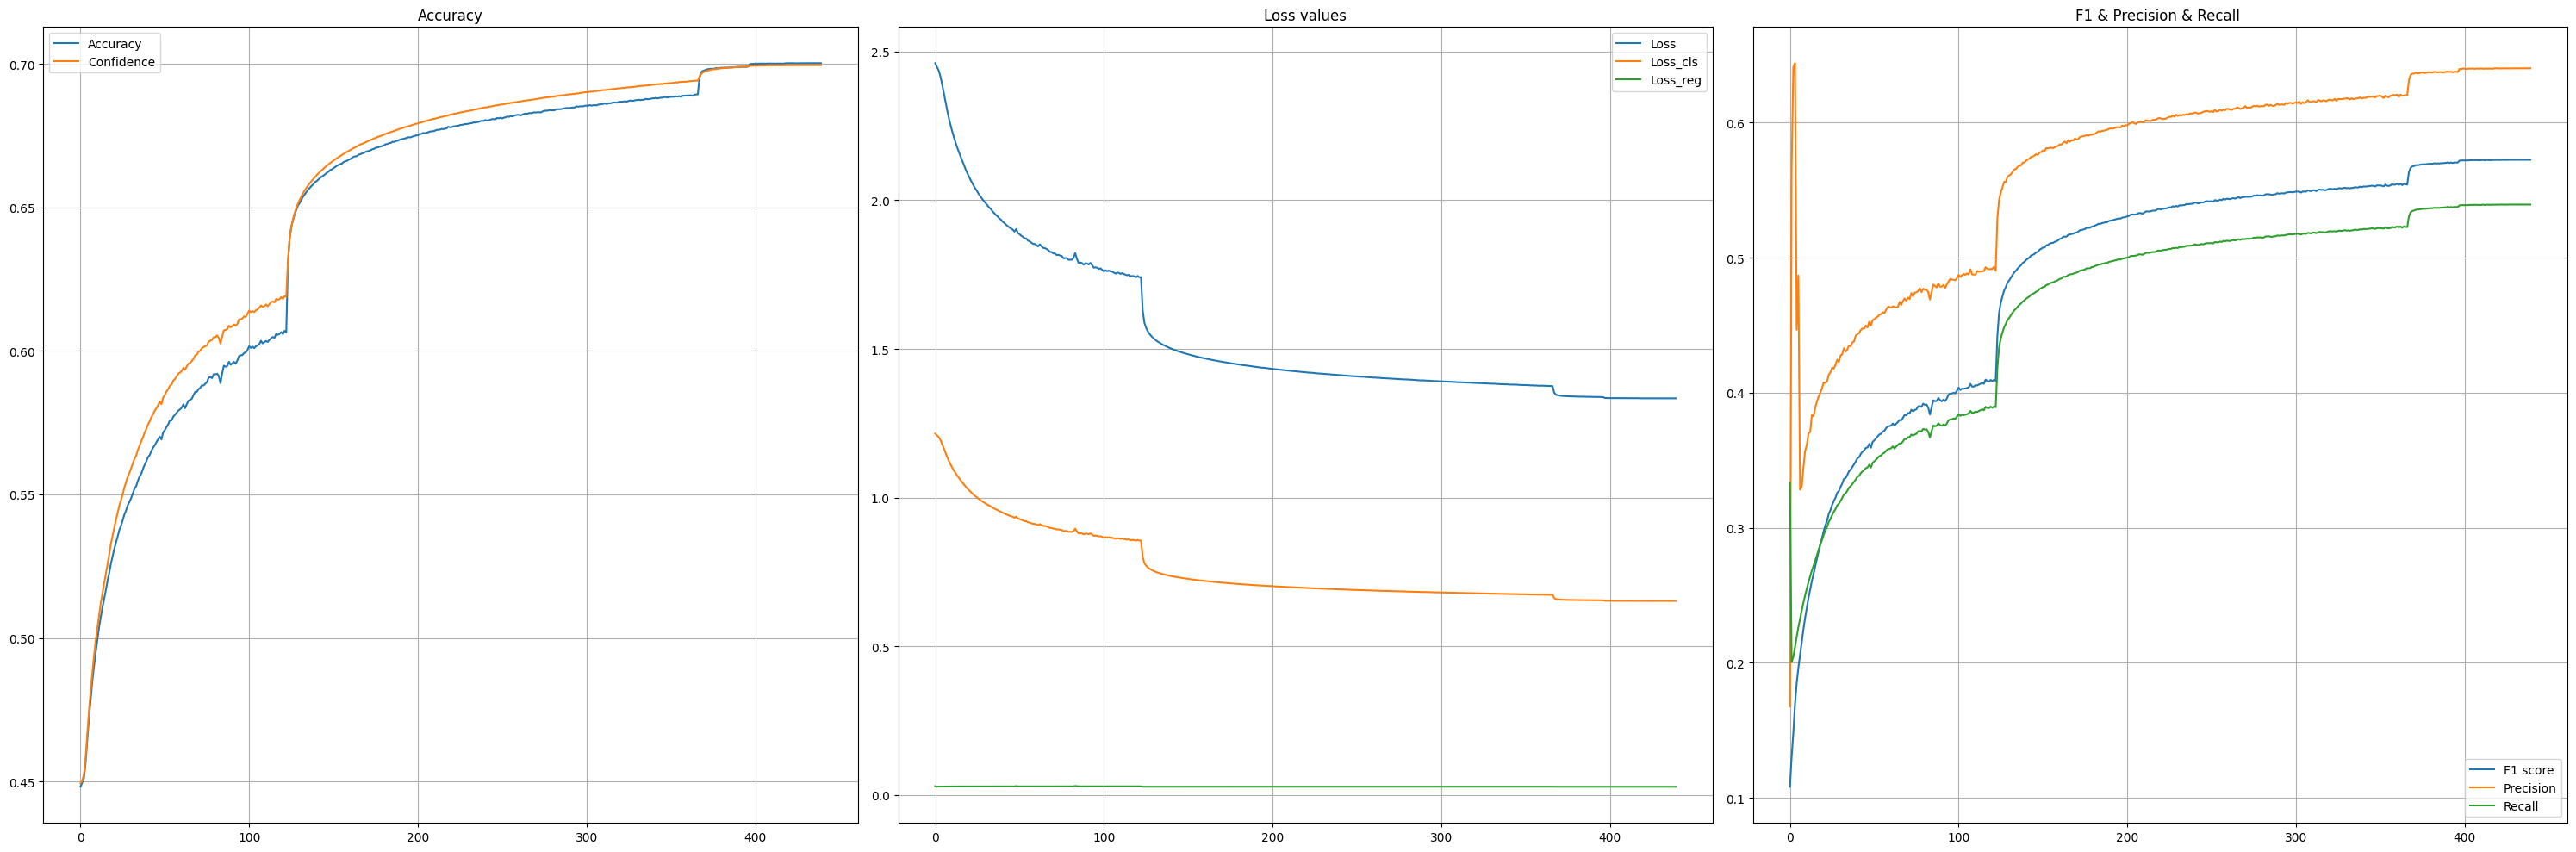

In [2]:
# with open(f'../model/trainlog/{regi_time}_lstm_train_log.pkl', 'rb') as f:
#     history = pickle.load(f)

with open(f'../model/trainlog/250710_190844_lstm_train_log.pkl', 'rb') as f:
    history = pickle.load(f)
# epochs = range(1, len(history['f1']) + 1)
epochs = range(len(history['accuracy']))

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.plot(epochs, history['accuracy'], label='Accuracy')
plt.plot(epochs, history['confidence'], label='Confidence')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs, history['loss'], label='Loss')
plt.plot(epochs, history['loss_cls'], label='Loss_cls')
plt.plot(epochs, history['loss_reg'], label='Loss_reg')
plt.legend()
plt.grid()
plt.title('Loss values')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(epochs, history['f1'], label='F1 score')
plt.plot(epochs, history['precision'], label='Precision')
plt.plot(epochs, history['recall'], label='Recall')
plt.legend()
plt.grid()
plt.title('F1 & Precision & Recall ')

plt.show()

In [35]:
# 예측 펑션
def predict_future(station_name, evse_name, df_raw, col_transformer, model, device='cuda'):
    model.eval()
    target_reg = 'kwh_per_usage_time'
    # 1. 입력 데이터 필터링 (최근 24개만 사용)
    evse_list = df['evse_name'].to_list()
    station_location_list = df['station_location'].to_list()
    
    # station-evse 조합 존재 확인
    match = df_raw[
        (df_raw['station_location'] == station_name) &
        (df_raw['evse_name'] == evse_name)
    ]
    
    if station_name not in df_raw['station_location'].unique():
        raise ValueError(f"❌ '{station_name}'이라는 충전소는 존재하지 않습니다.")
    if evse_name not in df_raw['evse_name'].unique():
        raise ValueError(f"❌ '{evse_name}'이라는 기기는 존재하지 않습니다.")
    
    match = df_raw[(df_raw['station_location'] == station_name) & (df_raw['evse_name'] == evse_name)]
    if match.empty:
        raise ValueError(f"❌ '{station_name}'의 '{evse_name}' 기기에 대한 데이터가 존재하지 않습니다.")
    
    df_target = match
    df_recent = df_target.sort_values('charging_start_time_ts').iloc[-24:]  # 시간 기준 정렬 +마지막 24시간 시퀀스
    
    if len(df_recent) < 24:
        raise ValueError("해당 기기(station-evse)의 데이터가 24개보다 적습니다.")
    
    X_input_raw = df_recent.copy()  

    # 3. 전처리 적용
    X_input_trans = col_transformer.transform(X_input_raw)  # (24, feature_dim)
    
    # 4. 배치 형태로 변환
    X_input_tensor = torch.tensor(X_input_trans, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 24, feature_dim)

    # 5. 예측 수행
    with torch.no_grad():
        pred_cls, pred_reg = model(X_input_tensor)  # pred_cls: (1, 24, num_classes), pred_reg: (1, 24)

    # 6. 결과 정리
    pred_cls_label = pred_cls.argmax(dim=2).squeeze(0).cpu().numpy()  # (24,)
    pred_reg_val = pred_reg.squeeze(0).cpu().numpy()  # (24,)

    # 회귀 결과 역변환
    reg_scaler = None
    for name, transformer, cols in col_transformer.transformers_:
        if isinstance(cols, list) and target_reg in cols:
            # 해당 컬럼의 인덱스를 찾아서 슬라이싱해 inverse
            col_idx = cols.index(target_reg)
            if hasattr(transformer, 'inverse_transform'):
                pred_reg_val_full = np.zeros((pred_reg_val.shape[0], len(cols)))
                pred_reg_val_full[:, col_idx] = pred_reg_val
                pred_reg_val_inv_full = transformer.inverse_transform(pred_reg_val_full)
                pred_reg_val = pred_reg_val_inv_full[:, col_idx]
                break
    else:
        raise ValueError("회귀 스케일러를 ColumnTransformer에서 찾을 수 없습니다.")
    
    # 정확히 n시간뒤 1개 값만 받고 싶을경우
    n =5
    cls_n = pred_cls_label[n-1]
    reg_n = pred_reg_val[n-1]

    return pred_cls_label, pred_reg_val

In [36]:
df = pd.read_csv('../data/csv/50area_dummy_processed.csv')
station = "st-15"  # 또는 코드화된 값
evse = "st-15_evse-05"
ct = joblib.load('ct_cached.joblib')
cls_preds, reg_preds = predict_future(station, evse, df, ct, model)

print("✅ 분류 결과 (post_charge_departure_range):", cls_preds)
print("💹 회귀 결과 (kwh_per_usage_time):", reg_preds)


✅ 분류 결과 (post_charge_departure_range): [2 2 1 1 1 1 2 2 2 2 2 2 1 1 3 3 1 5 5 1 1 2 2 1]
💹 회귀 결과 (kwh_per_usage_time): [6.97523222 6.75952281 6.80063404 6.84245475 6.9761669  6.85981613
 7.0317091  6.93837244 6.95092641 6.9871675  6.8141225  6.91126442
 7.02373444 6.8141132  6.98551787 6.89516977 6.96585882 7.02245003
 6.98058355 7.0183791  7.06945542 7.05021685 6.63826653 6.60932271]


In [37]:
station = "st-15"  # 또는 코드화된 값
evse = "st-15_evse-05"
ct = joblib.load('ct_cached.joblib')
cls_preds, reg_preds = predict_future(station, evse, df, ct, model)

print("✅ 분류 결과 (post_charge_departure_range):", cls_preds)
print("💹 회귀 결과 (kwh_per_usage_time):", reg_preds)


✅ 분류 결과 (post_charge_departure_range): [2 2 1 1 1 1 2 2 2 2 2 2 1 1 3 3 1 5 5 1 1 2 2 1]
💹 회귀 결과 (kwh_per_usage_time): [6.97523222 6.75952281 6.80063404 6.84245475 6.9761669  6.85981613
 7.0317091  6.93837244 6.95092641 6.9871675  6.8141225  6.91126442
 7.02373444 6.8141132  6.98551787 6.89516977 6.96585882 7.02245003
 6.98058355 7.0183791  7.06945542 7.05021685 6.63826653 6.60932271]


In [38]:
station = "st-15"  # 또는 코드화된 값
evse = "st-15_evse-05"

cls_preds, reg_preds = predict_future(station, evse, df, ct, model)

print("✅ 분류 결과 (post_charge_departure_range):", cls_preds)
print("💹 회귀 결과 (kwh_per_usage_time):", reg_preds)


✅ 분류 결과 (post_charge_departure_range): [2 2 1 1 1 1 2 2 2 2 2 2 1 1 3 3 1 5 5 1 1 2 2 1]
💹 회귀 결과 (kwh_per_usage_time): [6.97523222 6.75952281 6.80063404 6.84245475 6.9761669  6.85981613
 7.0317091  6.93837244 6.95092641 6.9871675  6.8141225  6.91126442
 7.02373444 6.8141132  6.98551787 6.89516977 6.96585882 7.02245003
 6.98058355 7.0183791  7.06945542 7.05021685 6.63826653 6.60932271]


In [39]:
station = "st-00"  # 또는 코드화된 값
evse = "st-00_evse-00"

cls_preds, reg_preds = predict_future(station, evse, df, ct, model)

print("✅ 분류 결과 (post_charge_departure_range):", cls_preds)
print("💹 회귀 결과 (kwh_per_usage_time):", reg_preds)


✅ 분류 결과 (post_charge_departure_range): [1 1 1 2 2 2 2 1 1 1 1 1 2 2 1 1 3 3 3 3 3 3 3 2]
💹 회귀 결과 (kwh_per_usage_time): [63.43789837 63.24012452 63.30128592 63.49232046 63.44292805 63.57388649
 63.76597131 63.23185647 63.31062175 63.58947733 63.42004942 63.48303713
 63.48870282 63.40629073 63.33319697 63.33674459 63.49317235 63.41866655
 63.45843721 63.68961001 63.6376094  63.46124963 63.72297395 63.82972923]


In [40]:
def all_predit():
    stations = df['station_location'].unique().tolist()
    for i in stations:
        evses = df[df['evse_name'].str.startswith(i)]['evse_name'].to_list()
        for j in evses:
            cls_preds, reg_preds = predict_future(i,j,df,ct,model,device)
            cls_series = pd.Series(cls_preds, name=f'{j} = post_charge_departure_range')
            reg_series = pd.Series(reg_preds, name=f'{j} = kwh_per_usage_time')
            combined = pd.concat([cls_series, reg_series], axis=1)
        yield combined
    
gen = all_predit()  # 제너레이터 생성

first_df = next(gen)
second_df = next(gen)

# 결과 확인
second_df

,st-01_evse-01 = post_charge_departure_range,st-01_evse-01 = kwh_per_usage_time
0,1,63.573192
1,1,63.364565
2,1,63.458496
3,1,63.975199
4,1,63.626459
5,1,63.411688
6,1,63.992645
7,1,63.786277
8,2,63.873660
9,2,63.560064


In [ ]:
second_df = next(gen)
second_df

,st-02_evse-01 = post_charge_departure_range,st-02_evse-01 = kwh_per_usage_time
0,1,64.520330
1,1,63.184390
2,3,63.870480
3,2,64.270509
4,2,65.511271
5,1,64.530757
6,1,63.890541
7,1,64.045947
8,1,63.971296
9,3,64.572803


: 